# Noise robustness of persistent homology on greyscale images, across filtrations and persistence signatures
  
  
Author: Renata Turkes, University of Antwerp  
Related article: Renata Turkes, Jannes Nys, Tim Verdonck, Steven Latre, "Noise robustness of persistent homology on greyscale images, across filtrations and persistence signatures", Section 5: Computational experiments.


The goal of this notebook is to explore the robustness to noise of persistent homology (PH) on greyscale images, across different filtrations, persistence signatures and types of noise. The only input necessary for this notebook are variables:
- "data", a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image
- "labels", a num_data_points x 1 numpy array, representing the data class for each image.



## 5.1) (Noisy) Datasets 

The notebook starts by calculating the variable "data_trnsf", which stores the given dataset under a number of affine and noisy transformations, e.g., data_trnsf["rotation 45"] corresponds to the given dataset under rotation. The definition of noise can easily be adjusted, or other types of noise can be considered.

The notebook then calculates persistent homology for every (non-noisy and noisy) image, using the following steps:
- PH1) Construct the input for persistent homology: Build a filtration (nested structured complexes) for each data point.
- PH2) Calculate persistent homology: Calculate persistence intervals (birth and death values of each cycle) for each data point.
- PH3) Construct the output of persistent homology: Represent the persistence intervals of each data point with a persistence signature.  

The persistent homology information is stored into a dictionary "data_sign_homdim_filt_trnsf", so that, e.g., data_sign_homdim_filt_trnsf["PL", "1-dim", "density", "rotation 45"] corresponds to the 1-dim persistence landscapes wrt density filtration on the given dataset under rotation. The definition of filtrations and signatures can easily be adjusted, or other filtrations and signatures can be considered.



## 5.2) Noise robustness

The goal of this section is to answer the following research question: 
> (RQ1) In what way, and to which degree, is the persistent homology information sensitive to noise, across different filtrations and persistence signatures?

The first part of this section is visually summarized with two figures (for 0-dim and 1-dim PH), which depict an example data point (image) under different types of transformations, together with the persistence homology information for each (non-noisy and noisy) image across different filtrations and persistence signatures. This figures helps to understand what noise does to an image, represented with its filtration functions, or persistent homology information.

The second part of this section is summarized with a table of average ($l_p$ or Wasserstein $W_p$) distances between non-noisy and noisy-images. The table helps to understand how much does the noisy image differ from the non-noisy image, represented with its filtration functions, or persistent homoology information (stability theorems).



## 5.3) Noise robustness and discriminative power

The goal of this section is to answer the following research question: 
> (RQ2) How discriminative is the persistent homology information with respect to different filtrations and signatures, on the dataset with noise, compared to the data with no noise?
  
This section is visually summarized with two boxplots (for 0-dim and 1-dim PH), with the accuracy of SVM trained on non-noisy and tested on noisy data on the y-axis, and different types of noise and different data representations on the x-axis. These figures help us understand how well does SVM classify the noisy images after training on non-noisy data, represented with filtration functions, or persistent homology information.

We are less interested in the the absolute values of the SVM accuracy, but rather in the relative decrease of the accuracy for noisy compared to the non-noisy data, which enables us to assess noise robustness. Therefore, we also include a table which gives the drop in SVM accuracy.


The computation times of crucial steps are also stored.


Some interesting articles which employ persistent homology on images, or deal with definition or evaluation of invariance under affine or noise transformations:
- Garin et al, "A topological reading lesson: Classification of MNIST using TDA" (https://arxiv.org/pdf/1910.08345.pdf)   
- Obayashi et al, "Persistence diagrams with linear machine learning models" (https://link.springer.com/content/pdf/10.1007/s41468-018-0013-5.pdf)
- Ilyas et al, "Adversarial examples are not bugs, they are features" (https://arxiv.org/pdf/1905.02175.pdf)
- Goodfellow et al, "Explaining and harnessing adversarial examples" (https://arxiv.org/abs/1412.6572)
- Keras, "Image preprocessing" (https://keras.io/preprocessing/image/)
- Wikipedia, "Image noise" (https://en.wikipedia.org/wiki/Image_noise)

In [1]:
# pip install numpy keras tensorflow gudhi scikit-learn scikit-learn-extra matplotlib pillow pandas POT

import numpy as np # np.loadtxt(), np.sum(), np.max(), np.random.uniform(), etc.
import math # math.floor()

from keras.preprocessing.image import ImageDataGenerator # ImageDataGenerator()

import gudhi as gd # gd.CubicalComplex(), gd.RipsComplex(), gd.SimplexTree(), gd.persistence(), gd.persistence_intervals_in_dimension(), gd.bottleneck_distance()
import gudhi.wasserstein
import gudhi.representations # gd.representations.Landscape(), gd.representations.PersistenceImage()
# other TDA libraries:
# import sklearn_tda # Mathieu Carriere, https://github.com/MathieuCarriere/sklearn-tda 
# import gtda # Guillaume Tauzin, Umberto Lupo, Kathryn Hess, https://github.com/giotto-ai/giotto-tda
# import teaspoon # Elizabeth Munch, https://github.com/lizliz/teaspoon
# import scikit-tda # Chris Trailie, https://github.com/scikit-tda
# import homcloud.interface as hc # Ippei Obayashi, http://www.wpi-aimr.tohoku.ac.jp/hiraoka_labo/homcloud/index.en.html

from sklearn import datasets # datasets.load_digits()
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin # class kernel_rbf(BaseEstimator, TransformerMixin)
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone 
from tempfile import TemporaryDirectory

from scipy.spatial.distance import directed_hausdorff

import matplotlib.pyplot as plt # plt.matshow(), plt.scatter(), plt.hist(), etc.
%matplotlib inline

import time # time.time()
import pickle # pickle.dump(), pickle.load()
from numba import njit, prange # @njit(parallel = True), prange() 
from joblib import Parallel, delayed # Parallel(n_jobs = -1)(delayed(function)(arguments) for arguments in arguments_array)

Using TensorFlow backend.


## Auxiliary functions.

In the cells below, we define auxiliary functions from the above imported packages:
- for affine data transformations, from keras
- for noisy data transformations, from numpy
- for calculation of filtrations, from numpy
- for calculation of persistence, from gudhi
- for calculation of distances, from numpy
- for plotting, from matplotlib

For details on different steps in the TDA pipeline for persistent homology, see https://github.com/GUDHI/TDA-tutorial.  
For documentation on TDA functions from gudhi library, see: http://gudhi.gforge.inria.fr/doc/latest/.

In [2]:
def affine_transform(data, transform_params):
    '''
    Calculate the image under given affine transformation, for each image in the dataset.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    transform_params: parameter for keras.preprocessing.image.ImageDataGenerator which defines the transformation,
    'theta': Float. Rotation angle in degrees.
    'tx': Float. Shift in the x direction.
    'ty': Float. Shift in the y direction.
    'shear': Float. Shear angle in degrees.
    'zx': Float. Zoom in the x direction.
    'zy': Float. Zoom in the y direction.abs
    'flip_horizontal': Boolean. Horizontal flip.
    'flip_vertical': Boolean. Vertical flip.
    'channel_shift_intensity': Float. Channel shift intensity.
    'brightness': Float. Brightness shift intensity.
    e.g., transform_parameters = {'theta':40, 'brightness':0.8, 'zx':0.9, 'zy':0.9}
    
    Output:
    data_trnsf: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under transformation.
    '''
    num_data_points = data.shape[0] 
    num_pixels = data.shape[1] 
    num_x_pixels = np.sqrt(num_pixels).astype(int)
    num_y_pixels = num_x_pixels   
    data_images = data.reshape((num_data_points, num_x_pixels, num_y_pixels))    
    data_trnsf = np.zeros((num_data_points, num_pixels))    
    datagen = ImageDataGenerator()
    for p, image in enumerate(data_images):
        # We first need to represent each image as a num_x_pixels x num_y_pixels x 1 numpy array.
        image_3D_array = np.zeros((num_x_pixels, num_y_pixels, 1))
        for i in range(num_x_pixels):
            for j in range(num_x_pixels):
                image_3D_array[i][j] = [image[i][j]]
        # Next, we transform the image using keras.preprocessing.image import ImageDataGenerator.
        image_trnsf_3D_array = datagen.apply_transform(x = image_3D_array, transform_parameters = transform_params)
        # Finally, we represent the transformed image as a vector of length num_x_pixels * num_y_pixels.
        image_trnsf = np.zeros((num_x_pixels, num_y_pixels))
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                image_trnsf[i][j] = image_trnsf_3D_array[i][j].item()
        data_point_trnsf = image_trnsf.reshape(num_pixels, )
        data_trnsf[p] = data_point_trnsf
    return data_trnsf


def gaussian_noise(data, noise_std_dev):
    '''
    Calculate the image under gaussian noise, for each image in the dataset.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    noise_std_dev: a float, standard deviation of gaussian noise. Most of the values are within +-3std_dev from the mean 0.
    
    Output:
    data_gaussian_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under gaussian noise.
    '''
    data_gaussian_noise = np.zeros(data.shape)    
    for p, data_point in enumerate(data):
        # We apply noise to each image separately, as we want have noise_mean and noise_std_dev for each image (row in data)
        # and not for this to be the mean and std dev for the whole 2D matrix data.
        gaussian_noise = np.random.normal(0, noise_std_dev, data_point.shape)
        data_point_gaussian_noise = data_point + gaussian_noise
        data_gaussian_noise[p] = data_point_gaussian_noise
    data_gaussian_noise = np.clip(data_gaussian_noise, np.min(data), np.max(data))
    return data_gaussian_noise


def salt_and_pepper_noise(data, proportion_noise_pixels):
    '''
    Calculate the image under salt and pepper noise, for each image in the dataset. 
    Salt and pepper noise changes the value of a given ratio of pixels, which are selected randomly, 
    to either salt (white) or pepper (black).
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    proportion_noise_pixels: a float, proportion of pixels to be changed.
    
    Output:
    data_sp_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under salt and pepper noise.    
    '''
    data_sp_noise = np.zeros(data.shape)    
    for p, data_point in enumerate(data):
        # Each pixel changes (pixel_chaned[i, j] = 1) with a given probability.
        pixel_changed = np.random.binomial(1, proportion_noise_pixels, data_point.shape)
        # The pixels which change, change equally likely to salt (white) or peper (black).      
        # For the MNIST images, it might be more reasonable to set the probability of changing to pepper as very large 
        # (e.g., 0.8), since it is only then that something changes for white pixels, which are in the large majority.
        sp_noise = np.random.binomial(1, 0.5, data_point.shape) * np.max(data)
        # if pixel_chaned[i][j] = 0
        # data_point_image_sp_noise[i][j] = 1 * data_point_image[i][j] + 0 * sp_noise = data_point_image[i][j]
        # if pixel_chaned[i][j] = 1
        # data_point_image_sp_noise[i][j] = 0 * data_point_image[i][j] + 1 * sp_noise = sp_noise[i][j]     
        data_point_sp_noise = (1 - pixel_changed)*data_point + pixel_changed*sp_noise       
        data_sp_noise[p] = data_point_sp_noise
    return data_sp_noise  
    
    
def shot_noise(data, pixel_scaling_factor):
    '''
    Calculate the image under shot noise, for each image in the dataset. 
    Shot noise has a root-mean-square value proportional to the square root of the image intensity, 
    and the noise at different pixels are independent of one another. Shot noise follows a Poisson distribution, 
    which except at very high intensity levels approximates a Gaussian distribution of only positive numbers.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    pixel_scaling_factor: a float, level of noise.
    
    Output:
    data_shot_noise: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image under shot noise.    
    '''
    data_shot_noise = np.zeros(data.shape)   
    pixel_scaling_factor = 1 / pixel_scaling_factor 
    for p, data_point in enumerate(data):
        # The Poisson noise is signal dependent; it is not additive as Gaussian noise. 
        # Each new pixel is defined as a value which is drawn from a "normal" positive (i.e., Poisson) distribution
        # with distribution mean being the original pixel value. 
        data_point_shot_noise = np.random.poisson(data_point * pixel_scaling_factor) / float(pixel_scaling_factor) 
        data_shot_noise[p] = data_point_shot_noise
    data_shot_noise = np.clip(data_shot_noise, np.min(data), np.max(data))   
    return data_shot_noise

In [3]:
def binary_filtration_function(data, threshold_grsc_perc):
    '''
    Calculate the binary filtration function values for each image in the dataset. 
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    binary filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_pixels = data.shape[1]
    filt_func_vals_data = np.zeros((num_data_points, num_pixels))
    for p, data_point in enumerate(data): 
        filt_func_vals_data[p] = data_point > threshold_grsc_perc * np.max(data_point)
        # Pixels with the lowest filtration function values appear first in the filtration. 
        filt_func_vals_data[p] = 1 - filt_func_vals_data[p]
    return filt_func_vals_data    


def greyscale_filtration_function(data):
    '''
    Calculate the greyscale filtration function values for each image in the dataset. 
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    greyscale filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_pixels = data.shape[1]
    filt_func_vals_data = np.zeros((num_data_points, num_pixels))
    for p, data_point in enumerate(data):     
        # Pixels with the lowest filtration function values appear first in the filtration. 
        filt_func_vals_data[p] = np.max(data_point) - data_point        
    return filt_func_vals_data    


def density_filtration_function(data, threshold_grsc_perc, max_dist):  
    '''
    Calculate the density filtration function values for each image in the dataset. 
    Density filtration function counts the number of dark-enough pixels in an image, within a given distance.
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    max_dist: a non-negative integer, representing the size of the considered neighborhood for each pixel in an image.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    density filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))    
    point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
    p = 0
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            point_cloud_complete[p, 0] = j
            point_cloud_complete[p, 1] = num_y_pixels - i
            p = p + 1            
    for p, data_point in enumerate(data): 
        point_cloud = build_point_cloud(data_point, threshold_grsc_perc)        
        kdt = KDTree(point_cloud, leaf_size = 30, metric = "euclidean") 
        num_nbhs = kdt.query_radius(point_cloud_complete, r = max_dist, count_only = True)  
        filt_func_vals = num_nbhs
        max_num_nbhs = 2 * max_dist**2 + 2 * max_dist + 1 # num of pixels in euclidean ball with radius max_dist
        filt_func_vals = max_num_nbhs - filt_func_vals
#         # Cut-off density value (so that density does not also reflect the size of the hole).
#         max_filt_func_val = np.max(filt_func_vals)
#         filt_func_vals[filt_func_vals > 0.65 * max_filt_func_val] = max_filt_func_val # 0.4 in carriere2018statistical  
        filt_func_vals_data[p] = filt_func_vals         
    return filt_func_vals_data


def radial_filtration_function(data, threshold_grsc_perc, x_pixel, y_pixel):  
    '''
    Calculate the radial filtration function values for each image in the dataset. 
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    x_pixel, y_pixel: integers, coordinates of the reference pixel.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    radial filtration function on each pixel of an image.
    '''
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels    
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))
    for p, data_point in enumerate(data):                   
        image = data_point.reshape((num_x_pixels, num_y_pixels))    
        binary_image = image >= threshold_grsc_perc * np.max(image)         
        filt_func_vals = np.zeros((num_x_pixels, num_y_pixels))
        point_reference = np.array([x_pixel, y_pixel])
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                point = np.array([i, j])
                filt_func_vals[i, j] = np.linalg.norm(point - point_reference, ord = 2)  
                # filt_func_vals[i, j] = np.inner(point, point_reference)   
        filt_func_vals[binary_image == 0] = np.max(filt_func_vals)                    
        filt_func_vals_data[p] = filt_func_vals.reshape((num_x_pixels * num_y_pixels, ))                 
    return filt_func_vals_data


def build_point_cloud(data_point, threshold_grsc_perc): 
    '''
    Calculate the point cloud from an image.
    
    Input:
    data_point: a num_pixels x 1 numpy array, representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    
    Output:
    point_cloud: a num_black_pixels_data_point x 2 numpy array, x and y coordinates of each point cloud point.
    '''    
    num_x_pixels = np.sqrt(data_point.shape[0]).astype(int)
    num_y_pixels = num_x_pixels     
    image = data_point.reshape((num_x_pixels, num_y_pixels))    
    binary_image = image >= threshold_grsc_perc * np.max(image)          
    num_black_pixels = np.sum(binary_image) 
    point_cloud = np.zeros((num_black_pixels, 2))
    point = 0        
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            if binary_image[i, j] > 0:
                point_cloud[point, 0] = j
                point_cloud[point, 1] = num_y_pixels - i
                point = point + 1        
    return point_cloud


def distance_filtration_function(data, threshold_grsc_perc):
    return dtm_filtration_function(data, threshold_grsc_perc, 0)


def dtm_filtration_function(data, threshold_grsc_perc, m):          
    '''
    Compute the DTM filtration function values (with exponent p=2) of the empirical measure of a point cloud,
    obtained from each image in the dataset.
    This is an adaption from DTM implementation available at: 
    https://github.com/GUDHI/TDA-tutorial/blob/master/DTM_filtrations.py (from Anai et al, DTM-based filtrations).
    
    Input:
    data: a num_data_poins x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    threshold_grsc_perc: a float in [0,1], representing the threshold greyscale value percentage to obtain the binary image.
    m: a float in [0, 1] reflecting the number of neighbors to be considered for each point in point cloud.
    
    Output:
    filt_func_vals_data: a num_data_poins x num_pixels numpy array, with each row representing the values of the 
    DTM filtration function on discretized R^d.
    '''      
    num_data_points = data.shape[0]
    num_x_pixels = np.sqrt(data.shape[1]).astype(int)
    num_y_pixels = num_x_pixels    
    filt_func_vals_data = np.zeros((num_data_points, num_x_pixels * num_y_pixels))    
    point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
    p = 0
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            point_cloud_complete[p, 0] = j
            point_cloud_complete[p, 1] = num_y_pixels - i
            p = p + 1    
    for p, data_point in enumerate(data):    
        point_cloud = build_point_cloud(data_point, threshold_grsc_perc)        
        kdt = KDTree(point_cloud, leaf_size = 30, metric = "euclidean")         
        num_points = point_cloud.shape[0]
        k = math.floor(m * num_points) + 1 # number of neighbors
        dists_to_nbhs, _ = kdt.query(point_cloud_complete, k, return_distance = True)  
        filt_func_vals = np.sqrt(np.sum(dists_to_nbhs*dists_to_nbhs, axis = 1) / k) 
        # Cut-off DTM value, as in carriere2018statistical. No, because in this case DTM does not capture size of hole.
#         max_filt_func_val = np.max(filt_func_vals)
#         filt_func_vals[filt_func_vals > 0.5 * max_filt_func_val] = max_filt_func_val
        filt_func_vals_data[p] = filt_func_vals  
    return filt_func_vals_data


def weighted_simplex_tree(point_cloud, filt_func_vals_point_cloud, max_filt_func_val):  
    '''
    Compute the simplex tree, weighted by the given filtration function.
    This is an adaption from weighted simplex tree implementation available at: 
    https://github.com/GUDHI/TDA-tutorial/blob/master/DTM_filtrations.py
    
    Input:
    point_cloud: a num_points x 2 numpy array representing num_points points in R^2.
    filt_func_vals: a num_points x 1 numpy array, representing the values of the filtration function on the point cloud. 
    max_filt_func_val: maximal filtration value of simplices when building the complex.
    
    Output:
    weighted_simplex_tree: a gudhi.SimplexTree.
    '''   
    # Create an empty simplex tree.
    weighted_simplex_tree = gd.SimplexTree()
    num_points = point_cloud.shape[0]
    # Add vertices to the simplex tree.
    for p in range(num_points): 
        filt_func_val_vertex = filt_func_vals_point_cloud[p]
        if filt_func_val_vertex < max_filt_func_val:
            weighted_simplex_tree.insert([p], filtration = filt_func_val_vertex)    
    # Add edges to the simplex tree.
    distances = euclidean_distances(point_cloud)
    for p in range(num_points): 
        for q in range(p):  
            if distances[p][q] <= np.abs(filt_func_vals_point_cloud[p] - filt_func_vals_point_cloud[q]):
                filt_func_val_edge = 2 * np.maximum(filt_func_vals_point_cloud[p], filt_func_vals_point_cloud[q])
            else:
                filt_func_val_edge = (filt_func_vals_point_cloud[p] + filt_func_vals_point_cloud[q] + distances[p][q]) # / 2
            if filt_func_val_edge < max_filt_func_val:
                weighted_simplex_tree.insert([p, q], filtration = filt_func_val_edge)
    weighted_simplex_tree.expansion(2)      
    return weighted_simplex_tree

In [4]:
def pers_intervals_across_homdims(filt_func_vals_data, filt = " ", data = [], threshold_grsc_perc = 0.5, pers_hom_params = []):
    '''
    Compute persistent homology with respect to the given filtration.    
    
    Input:
    > filt_func_vals_data: a num_data_points x num_pixels numpy array, with each row representing the filtration function 
    values on each pixel/cell in discretized R^2.
    > filt: a string that determines the choice of filtration.
    > data: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    Persistent homology is calculated on a filtration (and not on data), but for the PH calculated with respect to 
    simplicial complexes built on point clouds, GUDHI implementation (also) requires the point cloud itself, in order to 
    calculate the distances between point cloud points which determine when an edge appears in the filtration.
    > threshold_grsc_perc: a float in [0, 1], representing the threshold greyscale value percentage to obtain the binary image,
    also necessary to build the point cloud from data.
    > pers_hom_params: any additional parameters that might be needed for the calculation of PH with respect to some 
    filtrations. For instance, the calculation of PH with respect to simplicial complexes has an additional parameter which 
    corresponds to the maximal length of an edge in the Vietoris-Rips simplicial complex, or more generally, the maximum 
    filtration function value for a weighted Rips simplicial complex (where point cloud points do not have zero filtration 
    function value).
    
    Output:
    > pers_intervals_homdim0_data: list of persistence intervals (b, d) corresponding to 0-dim cycles (connected components).
    > pers_intervals_homdim1_data: list of persistence intervals (b, d) corresponding to 0-dim cycles (holes).
    '''    
    pers_intervals_homdim0_data = []
    pers_intervals_homdim1_data = []   

    for i, filt_func_vals_data_point in enumerate(filt_func_vals_data):   
        
        if(filt == "Rips"):
            data_point = data[i]
            point_cloud = build_point_cloud(data_point, threshold_grsc_perc)
            # Any cycle will the lifespan greater than max_edge_length will have a death value of max_edge_length.
            max_edge_length = pers_hom_params[0]  
            simplicial_complex = gd.RipsComplex(points = point_cloud, max_edge_length = max_edge_length)
            simplex_tree = simplicial_complex.create_simplex_tree(max_dimension = 2)  
        
        elif(filt == "DTM"):          
           
            # To build the weighted simplicial complex, we need:
            # 1) point cloud
            data_point = data[i]
            point_cloud = build_point_cloud(data_point, threshold_grsc_perc)                        
            # 2) values of filtration function only on point cloud points
            num_points = point_cloud.shape[0]
            filt_func_vals_point_cloud = np.zeros(num_points)
            num_x_pixels = np.sqrt(filt_func_vals_data.shape[1]).astype(int) 
            num_y_pixels = num_x_pixels
            filt_func_vals_data_point = filt_func_vals_data_point.reshape((num_x_pixels, num_y_pixels))            
            # In build point cloud, image -> point cloud: x = j, y = num_y_pixels - i,
            # so that an inverse transformation is necessary here: j = x, i = num_y_pixels - y.                
            for p, point in enumerate(point_cloud):  
                i = num_y_pixels - point[1].astype(int)
                j = point[0].astype(int)
                filt_func_vals_point_cloud[p] = filt_func_vals_data_point[i, j]
            # 3) maximum filtration function value
            max_filt_func_val = pers_hom_params[0]            
            simplex_tree = weighted_simplex_tree(point_cloud, filt_func_vals_point_cloud, max_filt_func_val = max_filt_func_val)       
        
        else:                       
            num_x_pixels = np.sqrt(filt_func_vals_data.shape[1]).astype(int) 
            num_y_pixels = num_x_pixels
            simplicial_complex = gd.CubicalComplex(dimensions = [num_x_pixels, num_y_pixels], 
                                                   top_dimensional_cells = filt_func_vals_data_point) 
            simplex_tree = simplicial_complex # CubicalComplex is similar to simplex tree

        homdims_pers_intervals = simplex_tree.persistence() # needs to be called before persistence_intervals_in_dimension()           
        pers_intervals_homdim0 = simplex_tree.persistence_intervals_in_dimension(0)
        pers_intervals_homdim1 = simplex_tree.persistence_intervals_in_dimension(1)        
       
        # If the list of persistence intervals is empty, gd.representations.PersistenceImage().fit_transfrom()
        # returns an error. Therefore, we replace such lists with [[0, 0]], and this has no influence on the 
        # calculation of Wasserstein distances.
        if(len(pers_intervals_homdim0) == 0):
            pers_intervals_homdim0 = np.asarray([[0, 0]])
        if(len(pers_intervals_homdim1) == 0):
            pers_intervals_homdim1 = np.asarray([[0, 0]])     

        pers_intervals_homdim0_data.append(pers_intervals_homdim0)
        pers_intervals_homdim1_data.append(pers_intervals_homdim1)

    return pers_intervals_homdim0_data, pers_intervals_homdim1_data

In [5]:
def l_p_distances(data_1, data_2, p):
    '''
    Calculate l_p distance between an image in one dataset, and the corresponding image in the other dataset.
    
    Input:
    > data_1, data_2: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values 
    of an image.
    > p: a float in [1, \infty], reflecting the choice of l_p metric.
    
    Output:
    > dists_data_1_2: a num_data_points x 1 array, with each row representing the the distance between an image in data_1
    and the corresponding image (in the same row) in data_2.
    ''' 
    num_data_points = data_1.shape[0]
    dists_data_1_2 = np.zeros((num_data_points, ))
    for i in range(num_data_points):
        dists_data_1_2[i] = np.linalg.norm(data_1[i] - data_2[i], ord = p)
    return dists_data_1_2


def wasserstein_p_q_distances(pers_intervals_homdim_data_1, pers_intervals_homdim_data_2, p, q):
    '''
    Calculate Wasserstein_p_g distance between an persistence diagram in one dataset, and the corresponding 
    persistence diagram in the other dataset.
    
    Input:
    > pers_intervals_homdim_data_1, pers_intervals_homdim_data_2: lists of num_data_points elements, 
    each a num_cycles x 2 numpy array of birth and death values for each cycle in the given homological dimension
    (a persistence diagram).
    > p, q: floats in [1, \infty], reflecting the choice of Wasserstein_p_q metric.
    
    Output:
    > dists_pers_intervals_homdim_data_1_2: a num_data_points x 1 array, with each row representing the the distance 
    between a persistence diagram in pers_intervals_homdim_data_1 and the corresponding persistence diagram (in the same row)
    in pers_intervals_homdim_data_2.
    ''' 
    num_data_points = len(pers_intervals_homdim_data_1)
    dist_pers_intervals_homdim_data_1_2 = np.zeros((num_data_points, ))
    for i in range(num_data_points):
        if p == np.inf:
            dist_pers_intervals_homdim_data_1_2[i] = gd.bottleneck_distance(pers_intervals_homdim_data_1[i], 
                                                                            pers_intervals_homdim_data_2[i], e = 0)
        else:
            dist_pers_intervals_homdim_data_1_2[i] = gudhi.wasserstein.wasserstein_distance(pers_intervals_homdim_data_1[i], 
                                                                                            pers_intervals_homdim_data_2[i], 
                                                                                            order = p, internal_p = q)
    return dist_pers_intervals_homdim_data_1_2


@njit(parallel = True)
def l_p_distance_matrix(data, p):
    '''
    Calculate l_p distance between any two images in the given dataset.
    
    Input:
    > data: a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
    > p: a float in [1, \infty], reflecting the choice of l_p metric.
    
    Output:
    > distance_matrix_data: a num_data_points x num_data_point numpy array, with each element corresponding to the distance
    between two images.    
    ''' 
    num_data_points = len(data)
    distance_matrix_data = np.zeros((num_data_points, num_data_points))
    for i in prange(num_data_points):
        for j in prange(i):
            distance_matrix_data[i, j] = np.linalg.norm(data[i] - data[j], ord = p)
    # Distance matrix elements above the diagonal.
    distance_matrix_data =  distance_matrix_data + distance_matrix_data.transpose()
    return distance_matrix_data


def wasserstein_p_q_distance_matrix(pers_intervals_homdim, p, q):
    '''
    Calculate the Wasserstein W_p_q distance between any two persistence diagrams in the given dataset.
    
    Input:
    > pers_intervals_homdim: a list of num_data_points elements, each a num_cycles x 2 numpy array of birth and death
    values for each cycle in the given homological dimension.
    > p, q: floats in [1, \infty], reflecting the choice of Wasserstein_p_q metric.
    
    Output:
    > distance_matrix_data: a num_data_points x num_data_point numpy array, with each element corresponding to the distance
    between two persistence diagrams.    
    ''' 
    num_data_points = len(pers_intervals_homdim)
    distance_matrix_homdim = np.zeros((num_data_points, num_data_points))
    for i in range(num_data_points):
        for j in range(i):
            if p == np.inf:
                distance_matrix_homdim[i, j] = gd.bottleneck_distance(pers_intervals_homdim[i], pers_intervals_homdim[j], e = 0) # e=0?
            else:
                distance_matrix_homdim[i, j] = gudhi.wasserstein.wasserstein_distance(pers_intervals_homdim[i], 
                                                                                      pers_intervals_homdim[j], 
                                                                                      order = p, internal_p = q)
    # Distance matrix elements above the diagonal.
    distance_matrix_homdim = distance_matrix_homdim + distance_matrix_homdim.transpose()
    return distance_matrix_homdim

In [6]:
def plot_image(image, vmin, vmax, axes):
    '''
    Plot the given image.
    
    Input:
    > image: a num_x_pixels x num_y_pixels numpy array.
    > vmin, vmax: mininum and maximum pixel value.
    > axes: an object of class Axes, axes to plot the image.  
    ''' 
    axes.matshow(image, cmap = plt.cm.gray_r, vmin = vmin, vmax = vmax)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xticklabels([])
    axes.set_yticklabels([])

    
def plot_PD(PD, xymax, axes):    
    '''
    Plot the given persistence diagram (PD).
    
    Input:
    > PD: a num_cycles x 2 numpy array of birth and death values for each cycle, i.e., a persistence diagram (PD).
    > xymax: a positive float, maximum value of the plot x and y axis.
    > axes: an object of class Axes, axes to plot the PD.  
    ''' 
    axes.scatter(PD[:, 0], PD[:, 1], 50, c = "red")
    axes.set_aspect(aspect = 'equal')
    axes.set_xlim(-0.05 * xymax, 1.1 * xymax)
    axes.set_ylim(-0.05 * xymax, 1.1 * xymax)
    x = np.arange(-0.05 * xymax, 1.1 * xymax, 0.01)
    axes.plot(x, x, c = 'black') # plot the diagonal    
    intervals_unique, multiplicities = np.unique(PD, axis = 0, return_counts = True) 
    for i, multiplicity in enumerate(multiplicities):
        if multiplicity > 1: # Annotate a persistence interval/PD point only if it appears multiple times, for visual clarity.
            axes.annotate(multiplicity, xy = (intervals_unique[i, 0], intervals_unique[i, 1]), ha = "left", va = "bottom",
                          xytext = (5, 0), textcoords = "offset points", fontsize = 15, color = "red")    
    
    
def plot_PL(PL, num_lndscs, lndsc_resolution, ymax, axes):
    '''
    Plot the given persistence landscape (PL).
    
    Input:
    > PL: a num_lndscs x lndsc_resolution x 1 numpy array, a persistence landscape (PL).
    > num_lndscs: a natural number, number of different landscape functions.
    > lndsc_resolution: a natural number, number of equidistant point that the landscape function is evaluated on to obtain
    the vectorized persistence landscape.
    > ymax: a positive float, maximum value of the plot y-axis.
    > axes: an object of class Axes, axes to plot the PL.  
    ''' 
    for i in range(num_lndscs):
        axes.plot(PL[i*lndsc_resolution : (i+1)*lndsc_resolution], linewidth = 3)
        axes.set_ylim(0, 1.1 * ymax) 
        

def plot_PI(PI, pers_image_resolution, vmin, vmax, axes):
    '''
    Plot the given persistence image (PI).
    
    Input:
    > PI: a PI_resolution*PI_resolution x 1 numpy array, a persistence image (PI).
    > PI_resolution: a natural number, resolution of the persistence image.
    > lndsc_resolution: a natural number, number of equidistant point that the landscape function is evaluated on to obtain
    the vectorized persistence landscape.
    > vmin, vmax: mininum and maximum pixel value.
    > axes: an object of class Axes, axes to plot the image.  
    ''' 
    plot_image(np.flip(PI.reshape((pers_image_resolution, pers_image_resolution)), 0), vmin = vmin, vmax = vmax, axes = axes)


def plot_bar_containers(x_ticks_labels, y_values_per_bar_container, legend_labels):  
    '''
    Plot the grouped bar chart with given values.
    
    Input:
    > x_tick_labels: a list of string labels on the x-axis.
    > y_values_per_bar_container: a dictionary, with each element being a list of y-axis values for a specific 
    group/color/legend item.
    > legend labels: a list of string legend labels.
    ''' 
    num_x_ticks = len(x_ticks_labels) 
    x_ticks = np.arange(num_x_ticks)      
    num_bars_per_x_tick = len(y_values_per_bar_container) # = len(legend_labels)   
    width_bar = 0.65 * 1/num_bars_per_x_tick
    width_from_x_tick = np.arange(num_bars_per_x_tick) - np.floor(num_bars_per_x_tick/2)  # (..., -3, -2, -1, 0, 1, 2, 3, ...)
    fig, axes = plt.subplots(figsize = (20, 7)) 
    cmap = plt.get_cmap('tab20') # we have two levels of each type of noise
    bar_colors = ["black"] + [cmap.colors[t] for t in range(16)] # no-noise and two levels of 8 trnsfs     
    for t, legend_label in enumerate(legend_labels):    
        axes.bar(x_ticks + width_from_x_tick[t] * width_bar, y_values_per_bar_container[legend_label], width_bar, 
                 label = legend_label, color = bar_colors[t])        
    axes.set_xticks(x_ticks)
    axes.set_xticklabels(x_ticks_labels, fontsize = 10)
    axes.set_axisbelow(True)
    return fig, axes

## 5.1) (Noisy) Datasets

This notebook relies on a labeled dataset of greyscale images, stored in two variables:
- $\color{blue}{\text{data}},$ a num_data_points x num_pixels numpy array, with each row representing the greyscale pixel values of an image.
- $\color{blue}{\text{labels}},$ a num_data_points x 1 numpy array, with each row representing the label of an image.  

It is easy to calculate the following variables:
- min_data
- max_data
- num_data_points
- num_x_pixels
- num_y_pixels
- num_pixels
- data_images = a num_data_points x num_x_pixels x num_y_pixels numpy array,  

that will be used throughout the noteboox.

For the given dataset of greyscale images, we consider a few most common types of noise to be expected, three types of affine, three types of noisy transformations, change in image brightness and contrast, each at two different levels. The (noisy) datasets are stored in the dictionary:
- $\color{red}{\text{data_trnsf}}.$ 

We are interested in computing the persistent homology for each (non-noisy and noisy) image in data_trnsf. The input for persistent homology is a filtration, so we first calculate the filtration function values across different filtrations, stored in the dictionary:
- $\color{red}{\text{data_filt_trnsf}}.$  

Finally, we calculate a number of different persistence signatures for each of the filtrations, stored in the dictionary:
- $\color{red}{\text{data_sign_homdim_filt_trnsf}}.$  


Some of the elements in these dictionaries are:  
- data_filt_trnsf["grsc", "rotation 45"] = num_data_points x num_pixels numpy array, dataset of images under rotation, represented with a vector of its greyscale filtration function values
- data_sign_filt_homdim_trnsf["PD", "0-dim", "density", "rotation 45"] = list of num_data_points, dataset of images under rotation, represented with its 0-dim persistent diagram (list of persistence intervals) wrt density filtration  
- data_sign_filt_homdim_trnsf["PL", "0-dim", "density", "rotation 45"] = num_data_points x (num_lndscs * lndsc_resolution) numpy array, dataset of images under rotation, represented with its 0-dim persistent landscape (a vector) wrt density filtration.  

In [7]:
start_time = time.time()

In [8]:
# # Store variables "data" and "labels".
# # Example 1: MNIST, 1797 8x8 greyscale images.

# # Load data.
# digits = datasets.load_digits() # standard sklearn dataset

# # Explore data.
# print("type(digits) = ", type(digits), "\n")
# print("type(digits.data) = ", type(digits.data))
# print("digits.data.shape = ", digits.data.shape, "\n")
# print("type(digits.target) = ", type(digits.target))
# print("digits.target.shape = ", digits.target.shape, "\n")

# # Check for missing or NaN values and replace if necessary.

# # Pre-process the data.
# data = digits.data
# labels = digits.target

In [9]:
# Store variables "data" and "labels".
# Example 2: MNIST, 70 000 28x28 greyscale images.

# Load data.
# labels_and_data = np.loadtxt("C:/Users/renat/Documents_RT/DATASETS/MNIST/mnist_train.csv", delimiter=',') 
labels_and_data = np.loadtxt("C:/Users/renat/Documents_RT/DATASETS/MNIST/mnist_small.csv", delimiter=',') 
# labels_and_data = np.loadtxt("DATASETS/mnist_small.csv", delimiter = ',')
# labels_and_data = np.loadtxt("DATASETS/mnist.csv", delimiter = ',')

# Explore data.
print("type(labels_and_data) = ", type(labels_and_data))
print("labels_and_data.shape =", labels_and_data.shape)

# Check for missing or NaN values and replace if necessary.

# Pre-process the data.
data = labels_and_data[:, 1:]
labels = labels_and_data[:, 0]
labels = labels.astype(int)

type(labels_and_data) =  <class 'numpy.ndarray'>
labels_and_data.shape = (300, 785)


In [10]:
# # Store variables "data" and "labels".
# # Example 3: imec radar dataset, 6850 28x28 greyscale images.

# # Load data.
# data = np.loadtxt("C:/Users/renat/Documents_RT/DATASETS/radar/radar_train_data_v1_1.txt") 
# labels = np.loadtxt("C:/Users/renat/Documents_RT/DATASETS/radar/radar_train_label_v1_1.txt") 
# labels = labels.astype(int)

# # Explore data.

# # Check for missing or NaN values and replace if necessary.

# # Pre-process the data.
# # The images in this dataset have a large portion of very dark pixels, and since we consider that it is the black pixels
# # that carry the most important information (and sometimes construct point clouds corresponding to the images),
# # it might be better to consider the "inverse" images:
# data = np.max(data) - data

In [11]:
# Compute min_data, max_data, num_data_points, num_x_pixels, num_y_pixels, num_pixels and data images.

# For testing purposes, we can consider a smaller subset of the dataset.
data_subset_size = 70
data = data[0:data_subset_size, :] 
labels = labels[0:data_subset_size]

# Calculate some auxiliary variables used throughout the notebook.
min_data = np.min(data)
max_data = np.max(data)
num_data_points = labels.size
num_x_pixels = np.sqrt(data.shape[1]).astype(int)
num_y_pixels = num_x_pixels
num_pixels = num_x_pixels * num_y_pixels
data_images = data.reshape((num_data_points, num_x_pixels, num_y_pixels))

type(data) = <class 'numpy.ndarray'>
data.shape = (70, 784) 

type(labels) = <class 'numpy.ndarray'>
labels.shape = (70,) 

min_data = 0.0
max_data = 255.0 

num_data_points = 70
num_x_pixels = 28
num_y_pixels = 28
num_pixels = 784 

type(data_images) = <class 'numpy.ndarray'>
data_images.shape = (70, 28, 28) 



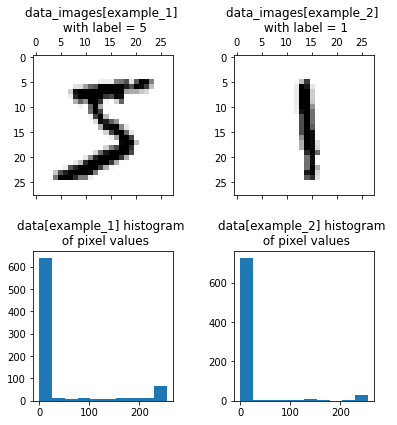

data_images[example_1] = 
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172.

In [12]:
# Auxiliary cell to explore the dataset and visualize a few example images.

# Explore the dataset.
print("type(data) =", type(data))
print("data.shape =", data.shape, "\n")
print("type(labels) =", type(labels))
print("labels.shape =", labels.shape, "\n")
print("min_data =", min_data)
print("max_data =", max_data, "\n")
print("num_data_points =", num_data_points)
print("num_x_pixels =", num_x_pixels)
print("num_y_pixels =", num_y_pixels)
print("num_pixels =", num_pixels, "\n")
print("type(data_images) =", type(data_images))
print("data_images.shape =", data_images.shape, "\n")

# Visualize two example data points, i.e., two example images.
example_1 = 0
example_2 = 8
label_1 = labels[example_1]
label_2 = labels[example_2]
num_fig_rows = 2
num_fig_cols = 2
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
axes[0, 0].matshow(data_images[example_1], cmap = plt.cm.gray_r)
axes[0, 0].set_title("data_images[example_1] \n with label = %i" %label_1)   
axes[0, 1].matshow(data_images[example_2], cmap = plt.cm.gray_r)
axes[0, 1].set_title("data_images[example_2] \n with label = %i" %label_2) 
axes[1, 0].hist(data[example_1], range = (0, np.max(data[example_1])))
axes[1, 0].set_title("data[example_1] histogram \n of pixel values")
axes[1, 1].hist(data[example_2], range = (0, np.max(data[example_2])))
axes[1, 1].set_title("data[example_2] histogram \n of pixel values")
plt.show()

print("data_images[example_1] = \n", data_images[example_1])

In [13]:
# # Auxiliary cell for 28 x 28 images to check if some of the auxiliary functions return reasonable results.

# print("Poisson noise with scaling factor p transforms an array less than with scaling factor q, if p<q:")
# pixel_scaling_factor_1 = 1
# pixel_scaling_factor_2 = 5
# pixel_scaling_factor_1 = 1 / pixel_scaling_factor_1
# pixel_scaling_factor_2 = 1 / pixel_scaling_factor_2
# a = np.array([25, 50, 125, 250, 30, 100, 120, 40, 10, 80])
# a_poisson = np.random.poisson(a)
# a_poisson_1 = np.random.poisson(a * pixel_scaling_factor_1) / float(pixel_scaling_factor_1)
# a_poisson_2 = np.random.poisson(a * pixel_scaling_factor_2) / float(pixel_scaling_factor_2)
# print("a = ", a)
# print("a_poisson = ", a_poisson)
# print("a_poisson_1 = ", a_poisson_1)
# print("a_poisson_2 = ", a_poisson_2)
# print("l2_distance(a, a_poisson_1) = ", np.around(np.linalg.norm(a - a_poisson_1), 2))
# print("l2_distance(a, a_poisson_2) = ", np.around(np.linalg.norm(a - a_poisson_2), 2))
# print("\n\n\n")


# print("Image, built point cloud and DTM(m=0) filtration function values on the point cloud points correspond well:")
# data_point = np.copy(data[11])
# image = data_point.reshape((num_x_pixels, num_y_pixels))
# point_cloud = build_point_cloud(data_point, 0.5) 
# num_points = point_cloud.shape[0]
# filt_func_vals_point_cloud = np.zeros(num_points)
# filt_func_vals_data_point = dtm_filtration_function(np.asarray([data_point]), 0.5, 0)[0]
# filt_func_vals_data_point = filt_func_vals_data_point.reshape((num_x_pixels, num_y_pixels))   
# binary_image_test = np.zeros((num_x_pixels, num_y_pixels)) 
# for p, point in enumerate(point_cloud):  
#     i = num_y_pixels - point[1].astype(int)
#     j = point[0].astype(int)
#     filt_func_vals_point_cloud[p] = filt_func_vals_data_point[i, j]
#     binary_image_test[i, j] = 1    
# print("DTM(m=0) filt_func_vals_point_cloud (should be zero) =", filt_func_vals_point_cloud)
# num_fig_rows = 1
# num_fig_cols = 3
# subfig_height = 2
# subfig_width = 2
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 0.5) 
# axes[0].matshow(image)
# axes[1].scatter(point_cloud[:, 0], point_cloud[:, 1])
# axes[1].set_xlim(0, num_x_pixels)
# axes[1].set_ylim(0, num_x_pixels)
# axes[2].matshow(binary_image_test)
# plt.show()
# print("\n\n\n")


# print("Rips filtration function == DTM(m=0) filtration function:")
# data_point_1 = np.copy(data[0])
# data_point_2 = np.copy(data[47])
# data_temp = np.asarray([data_point_1, data_point_2])
# filt_func_vals_rips = distance_filtration_function(data_temp, 0.5)
# filt_func_vals_dtm = dtm_filtration_function(data_temp, 0.5, 0)
# print(filt_func_vals_rips[0] == filt_func_vals_dtm[0])
# print(filt_func_vals_rips[1] == filt_func_vals_dtm[1])
# print("\n\n\n")


# print("Image, built point cloud, density and DTM filtration function:")
# # Image.
# data_point = np.copy(data[18]) 
# data_point[14*28+26] = 255 # add outlying black pixel in the backround, far away from the point cloud
# # data_point[14*28+14] = 255 # add outlying black pixel in the middle of the hole
# # Point cloud.
# point_cloud = build_point_cloud(data_point, threshold_grsc_perc = 0.5)
# # Reference point cloud for density and DTM filtration functions.
# point_cloud_complete = np.zeros((num_x_pixels * num_y_pixels, 2))
# p = 0
# for i in range(num_x_pixels):
#     for j in range(num_y_pixels):
#         point_cloud_complete[p, 0] = j
#         point_cloud_complete[p, 1] = num_y_pixels - i
#         p = p + 1         
# # Density filtration function.
# kdt_1 = KDTree(point_cloud, leaf_size = 30, metric = "euclidean") 
# num_nbhs = kdt_1.query_radius(point_cloud_complete, r = 1, count_only = True)  
# filt_func_vals_1 = num_nbhs
# filt_func_vals_1 = np.max(filt_func_vals_1) - filt_func_vals_1
# # max_filt_1 = np.max(filt_func_vals_1)
# # filt_func_vals_1[filt_func_vals_1 > 0.8 * max_filt_1] = max_filt_1    
# # DTM filtration function.
# kdt_2 = KDTree(point_cloud, leaf_size = 30, metric = "euclidean")   
# num_points = point_cloud.shape[0]
# k = math.floor(0.05 * num_points) + 1
# dists_to_nbhs, indices_of_nbhs = kdt_2.query(point_cloud_complete, k, return_distance = True)  
# # print(point_cloud.shape)
# # print(dists_to_nbhs.shape)
# # print(indices_of_nbhs.shape)
# # print(dists_to_nbhs)
# # print(indices_of_nbhs)
# filt_func_vals_2 = np.sqrt(np.sum(dists_to_nbhs**2, axis = 1) / k) 
# # max_filt_2 = np.max(filt_func_vals_2)
# # filt_func_vals_2[filt_func_vals_2 > 0.4 * max_filt_2] = max_filt_2    
# # Plot image, point cloud, density and DTM filtration functions.
# num_fig_rows = 1
# num_fig_cols = 4
# subfig_height = 2
# subfig_width = 2
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 0.5) 
# axes[0].matshow(data_point.reshape((num_x_pixels, num_y_pixels)))
# axes[1].scatter(point_cloud[:, 0], point_cloud[:, 1])
# axes[1].set_xlim(0, num_x_pixels)
# axes[1].set_ylim(0, num_x_pixels)
# axes[2].matshow(filt_func_vals_1.reshape((num_x_pixels, num_y_pixels)), cmap = plt.cm.gray_r)
# axes[3].matshow(filt_func_vals_2.reshape((num_x_pixels, num_y_pixels)), cmap = plt.cm.gray_r)
# plt.show()
# print("\n\n\n")


# print("Image as a distance function or a point cloud:")
# # Images.
# data_point_1 = np.copy(data[1])
# data_point_2 = np.copy(data_point_1)
# data_point_2[14*28+14] = 255 # add outlying black pixel in the backround, in the middle of the hole
# # data_point_2 = np.copy(data[7])
# # data_point_2 = np.copy(data_trnsf["translation -2 -2"][1])
# data_1_2 = np.asarray([data_point_1, data_point_2])
# # Distance functions.
# data_1_2_distance_function = distance_filtration_function(data_1_2, threshold_grsc_perc = 0.5)
# data_point_1_distance_function = data_1_2_distance_function[0]
# data_point_2_distance_function = data_1_2_distance_function[1]
# # Point clouds.
# data_point_1_point_cloud = build_point_cloud(data_point_1, threshold_grsc_perc = 0.5)
# data_point_2_point_cloud = build_point_cloud(data_point_2, threshold_grsc_perc = 0.5)
# distance_distance_functions = np.linalg.norm(data_point_1_distance_function - data_point_2_distance_function, ord = np.inf)
# distance_point_clouds = max(directed_hausdorff(data_point_1_point_cloud, data_point_2_point_cloud)[0], 
#                             directed_hausdorff(data_point_2_point_cloud, data_point_1_point_cloud)[0])
# print("l_infty distance between the two images, represented with their distance functions = ", distance_distance_functions)
# print("hausdorff distance between the two images, represented with their point clouds = ", distance_point_clouds)
# # Visualize images, distance functions and point clouds.
# num_fig_rows = 3
# num_fig_cols = 2
# subfig_height = 2
# subfig_width = 2
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 0.5)
# plot_image(data_point_1.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2), axes = axes[0, 0])
# plot_image(data_point_2.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2), axes = axes[0, 1])
# plot_image(data_point_1_distance_function.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2_distance_function), axes = axes[1, 0])
# plot_image(data_point_2_distance_function.reshape((num_x_pixels, num_y_pixels)), vmin = 0, vmax = np.max(data_1_2_distance_function), axes = axes[1, 1])
# axes[2, 0].scatter(data_point_1_point_cloud[:, 0], data_point_1_point_cloud[:, 1], 5, c = "red")
# axes[2, 0].set_xlim(0, num_x_pixels)
# axes[2, 0].set_ylim(0, num_x_pixels)
# axes[2, 1].scatter(data_point_2_point_cloud[:, 0], data_point_2_point_cloud[:, 1], 5, c = "red")
# axes[2, 1].set_xlim(0, num_x_pixels)
# axes[2, 1].set_ylim(0, num_x_pixels)
# plt.show()
# print("\n\n\n")
# # Distance function is continuous, but the volume below the function (the integral) is equal to the sum of volumes
# # below each grid cell, since in our definition of the point cloud, one non-white pixel corresponds to one point cloud point.


# print("PH wrt Rips filtration, caclulated on a simplicial complex on a point cloud, or on a cubical complex and distance function:")
# data_point = np.copy(data[17])
# # Image is considered as a point cloud.
# filt_func_vals_data_point_point_cloud = build_point_cloud(data_point, threshold_grsc_perc = 0.5)
# simplicial_complex_point_cloud = gd.RipsComplex(points = filt_func_vals_data_point_point_cloud, max_edge_length = np.inf)
# simplex_tree_point_cloud = simplicial_complex_point_cloud.create_simplex_tree(max_dimension = 2)  
# PDs_point_cloud = simplex_tree_point_cloud.persistence() 
# PD0_point_cloud = simplex_tree_point_cloud.persistence_intervals_in_dimension(0)
# PD1_point_cloud = simplex_tree_point_cloud.persistence_intervals_in_dimension(1)
# # Image is considered as a grid of pixel values.
# filt_func_vals_data_point_cubical = distance_filtration_function(np.asarray([data_point]), threshold_grsc_perc =0.5)[0]
# # print("filt_func_vals_data_point_cubical = \n", filt_func_vals_data_point_cubical)
# simplicial_complex_cubical = gd.CubicalComplex(dimensions = [num_x_pixels, num_y_pixels], top_dimensional_cells = filt_func_vals_data_point_cubical) 
# simplex_tree_cubical = simplicial_complex_cubical 
# PDs_cubical = simplex_tree_cubical.persistence() 
# PD0_cubical = simplex_tree_cubical.persistence_intervals_in_dimension(0)
# PD1_cubical = simplex_tree_cubical.persistence_intervals_in_dimension(1)
# print("PD0_point_cloud = ", PD0_point_cloud)
# print("PD0_cubical = ", PD0_cubical)
# print("PD1_point_cloud = ", PD1_point_cloud)
# print("PD1_cubical = ", PD1_cubical)
# num_fig_rows = 1
# num_fig_cols = 2
# subfig_height = 2
# subfig_width = 2
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 0.5)
# axes[0].scatter(filt_func_vals_data_point_point_cloud[:, 0], filt_func_vals_data_point_point_cloud[:, 1])
# axes[0].set_xlim(0, num_x_pixels)
# axes[0].set_ylim(0, num_x_pixels)
# axes[1].matshow(filt_func_vals_data_point_cubical.reshape((num_x_pixels, num_y_pixels)))
# plt.show()
# print("\n\n\n")
# # The two approaches do not yield exactly the same lists of persistence intervals:
# # 0-dim intervals for point clouds include a connected component (with small persistence) for each point cloud point,
# # which does not appear for cubical complex.
# # 1-dim intervals for point clouds are born at the max dist between two nbh point cloud points along the hole,
# # whereas they are born usually at 0 for cubical complex. For point clouds, they die at the shortest diameter of the hole, 
# # which is the same for cubical (largest distance within a hole to a black pixel). 
# # However, there are many small "holes" for point clouds.
# # The two approaches thus yield similar results, except for the points close to the diagonal (noise).

In [14]:
# Compute "data_trnsf", dictionary which stores the given dataset of images under given transformations. 
data_trnsf = {}

# Make a choice on the set of transformations to be considered in the experiments.
trnsfs = ["no noise", 
          "rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", 
          "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
          "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
          "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", 
          "shot noise 50", "shot noise 100"]
# If we wish to investigate only some types of noise, or shorten the computation time, we can consider e.g.:
# trnsfs = ["no noise", "rotation -90", "translation -2 -2", "stretch-shear-flip 0.75 -20 v", "brightness 100", "contrast 0.5",          
#          "gaussian noise 20", "salt and pepper noise 20", "shot noise 100"]

num_trnsfs = len(trnsfs)
data_trnsf["no noise"] = data

print("Constructing the data under transformations, when images are represented as greyscale pixel values...")
t0 = time.time()

data_trnsf["rotation 45"] = affine_transform(data, {'theta':45})
data_trnsf["rotation -90"] = affine_transform(data, {'theta':-90})
data_trnsf["translation 1 1"] = affine_transform(data, {'tx':1, 'ty':1})
data_trnsf["translation -2 -2"] = affine_transform(data, {'tx':-2, 'ty':-2})
data_trnsf["stretch-shear-flip 1.5 10 h"] = affine_transform(data, {'zx':1.5, 'shear':10, 'flip_horizontal':True})
data_trnsf["stretch-shear-flip 0.75 -20 v"] = affine_transform(data, {'zx':0.75, 'shear':-20, 'flip_vertical':True})

data_trnsf["brightness -50"] = data - 50
data_trnsf["brightness -50"] = np.clip(data_trnsf["brightness -50"], min_data, max_data)
data_trnsf["brightness 100"] = data + 100
data_trnsf["brightness 100"] = np.clip(data_trnsf["brightness 100"], min_data, max_data) 
data_trnsf["contrast 2"] = data * 2
data_trnsf["contrast 2"] = np.clip(data_trnsf["contrast 2"], min_data, max_data)
data_trnsf["contrast 0.5"] = data * 0.5
data_trnsf["contrast 0.5"] = np.clip(data_trnsf["contrast 0.5"], min_data, max_data)

data_trnsf["gaussian noise 10"] = gaussian_noise(data, noise_std_dev = 10) 
data_trnsf["gaussian noise 20"] = gaussian_noise(data, noise_std_dev = 20) 
data_trnsf["salt and pepper noise 5"] = salt_and_pepper_noise(data, proportion_noise_pixels = 0.05)
data_trnsf["salt and pepper noise 10"] = salt_and_pepper_noise(data, proportion_noise_pixels = 0.1)
data_trnsf["shot noise 50"] = shot_noise(data, pixel_scaling_factor = 50) 
data_trnsf["shot noise 100"] = shot_noise(data, pixel_scaling_factor = 100) 
# from skimage.util import img_as_float, random_noise
# data_trnsf["gaussian noise 10"] = 255 * random_noise(data, mode = "gaussian", var = 0.1) # variance is for the range [0,1]
# data_trnsf["gaussian noise 20"] = 255 * random_noise(data, mode = "gaussian", var = 0.2)
# data_trnsf["salt and pepper noise 5"] = 255 * random_noise(data, mode = "s&p", amount = 0.1, salt_vs_pepper = 0.2)
# data_trnsf["salt and pepper noise 20"] = 255 * random_noise(data, mode = "s&p", amount = 0.2, salt_vs_pepper = 0.2)
# data_trnsf["shot noise 50"] = 255 * random_noise(data*1, mode = "poisson") / 1
# data_trnsf["shot noise 100"] = 255 * random_noise(data*0.75, mode = "poisson") / 0.75

with open("VARIABLES/data_trnsf.pkl", "wb") as f:
    pickle.dump(data_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s" % runtime)

Constructing the data under transformations, when images are represented as greyscale pixel values...
Runtime = 0.597 s


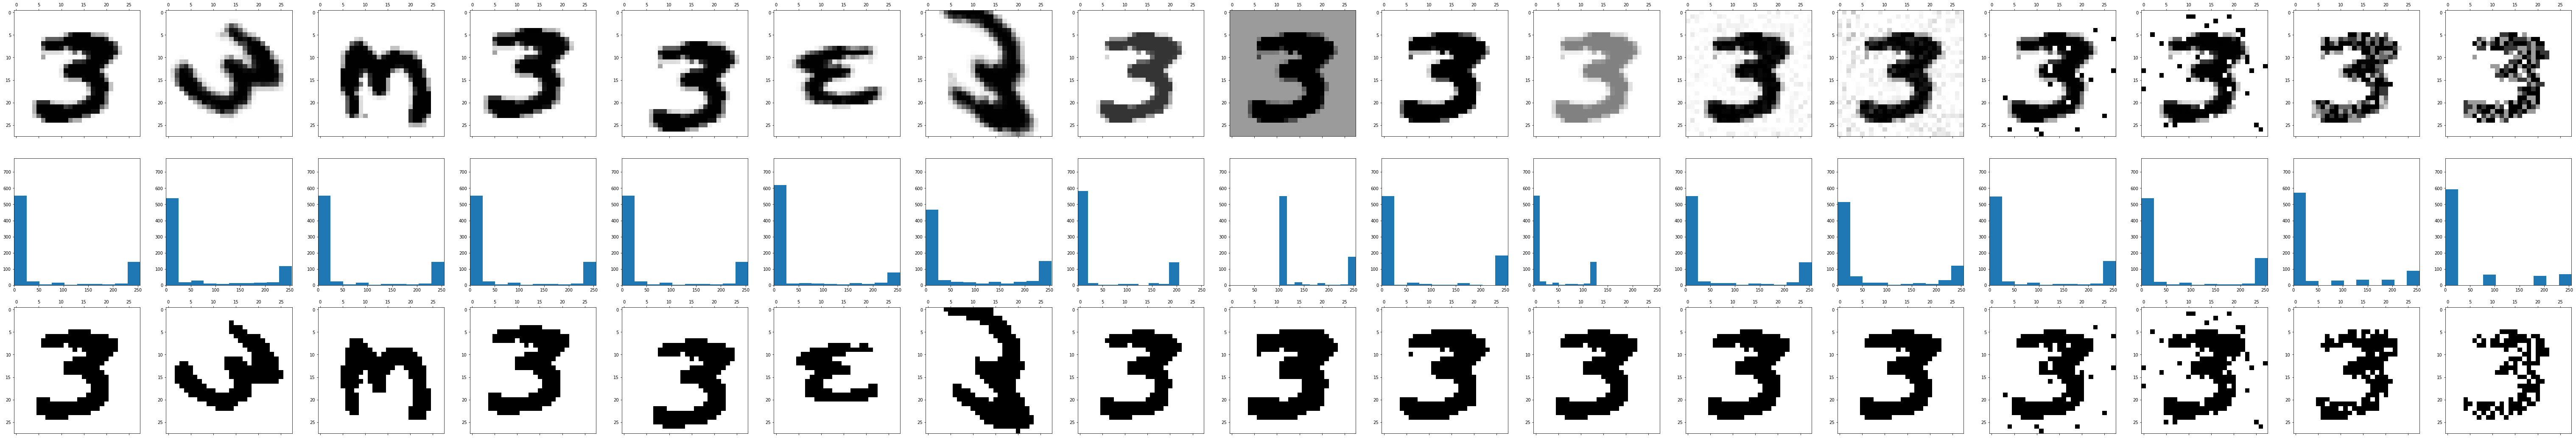

Maximum greyscale value =
no noise : 255.0
rotation 45 : 255.00000000000003
rotation -90 : 255.0
translation 1 1 : 255.0
translation -2 -2 : 255.0
stretch-shear-flip 1.5 10 h : 255.00000000000003
stretch-shear-flip 0.75 -20 v : 255.0
brightness -50 : 205.0
brightness 100 : 255.0
contrast 2 : 255.0
contrast 0.5 : 127.5
gaussian noise 10 : 255.0
gaussian noise 20 : 255.0
salt and pepper noise 5 : 255.0
salt and pepper noise 10 : 255.0
shot noise 50 : 255.0
shot noise 100 : 255.0

Distance(noisy image, non-noisy image) =
no noise : 0.0
rotation 45 : 3043.0
rotation -90 : 3702.0
translation 1 1 : 1965.0
translation -2 -2 : 2993.0
stretch-shear-flip 1.5 10 h : 3368.0
stretch-shear-flip 0.75 -20 v : 3069.0
brightness -50 : 743.0
brightness 100 : 2499.0
contrast 2 : 675.0
contrast 0.5 : 1628.0
gaussian noise 10 : 215.0
gaussian noise 20 : 419.0
salt and pepper noise 5 : 1066.0
salt and pepper noise 10 : 1432.0
shot noise 50 : 1113.0
shot noise 100 : 1506.0

Number of black pixels in binary im

In [15]:
# Auxiliary cell to visualize and explores\ different types of noise,
# and to guide the choice of parameters for transformations in the previous cell.

# Construct the image datasets, for visualization purposes.
data_images_trnsf = {}
for trnsf in trnsfs:
    data_images_trnsf[trnsf] = data_trnsf[trnsf].reshape((num_data_points, num_x_pixels, num_y_pixels))  
        
# Visualize different transformations for an example image.
example = 27
num_fig_rows = 3
num_fig_cols = num_trnsfs
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for t, trnsf in enumerate(trnsfs):
    # Image.
    axes[0, t].matshow(data_images_trnsf[trnsf][example], cmap = plt.cm.gray_r, vmin = min_data, vmax = max_data)
    # Histogram of pixel values.
    axes[1, t].hist(data_trnsf[trnsf][example])
    axes[1, t].set_xlim(np.min(data), np.max(data))
    axes[1, t].set_ylim(0, num_pixels)  
    # Binary image.
    axes[2, t].matshow(data_images_trnsf[trnsf][example] > 0.5 * np.max(data_images_trnsf[trnsf][example]),
                       cmap = plt.cm.gray_r)
plt.show()  
    
# Explore different transformations for an example image.
print("Maximum greyscale value =")
for trnsf in trnsfs:
    print(trnsf, ":", np.max(data_trnsf[trnsf]))
print()
print("Distance(noisy image, non-noisy image) =")
for trnsf in trnsfs:
    print(trnsf, ":", np.around(np.linalg.norm(data_trnsf[trnsf][example] - data_trnsf["no noise"][example]), 0))
print()
print("Number of black pixels in binary image (above given threshold greyscale value) =")
for trnsf in trnsfs:
    print(trnsf, ":", np.sum(data_images_trnsf[trnsf][example] > 0.5 * np.max(data_trnsf[trnsf][example])))
print()

C:\Users\renat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


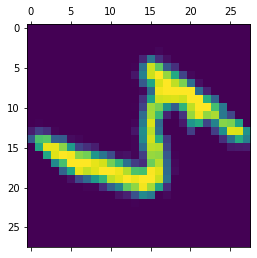

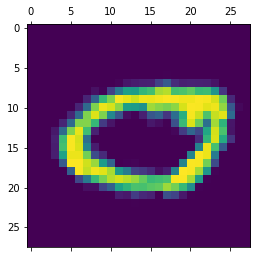

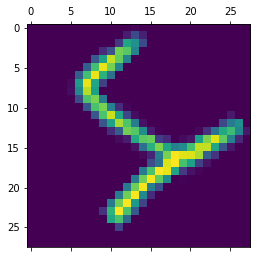

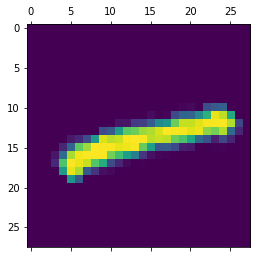

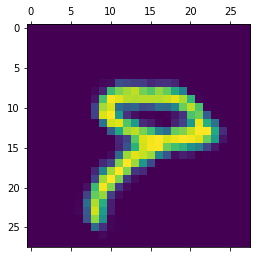

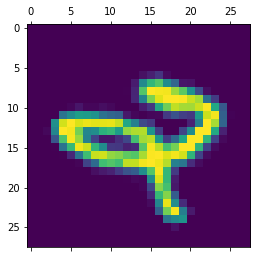

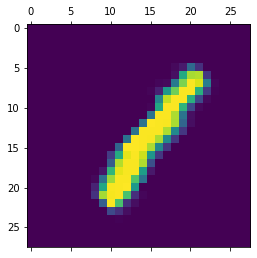

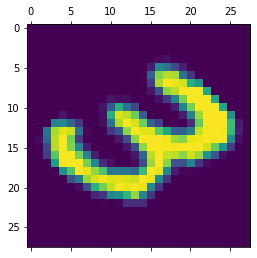

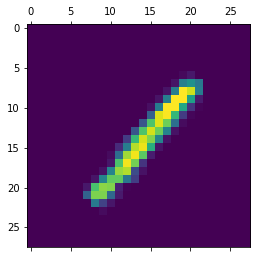

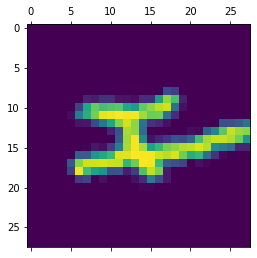

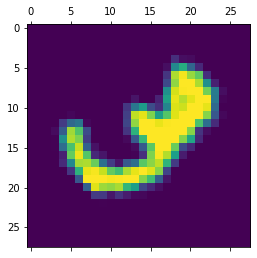

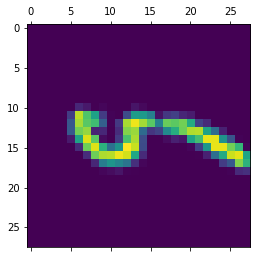

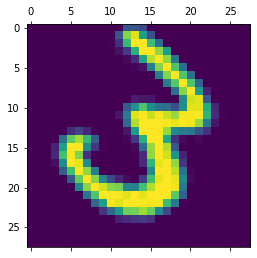

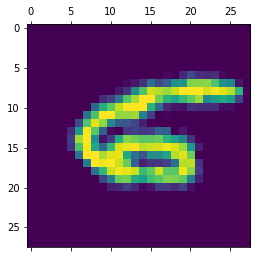

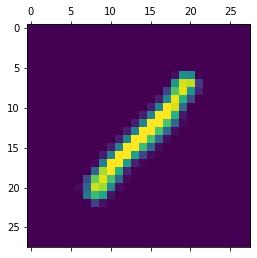

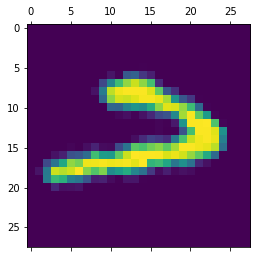

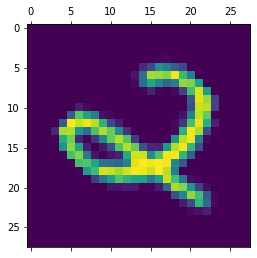

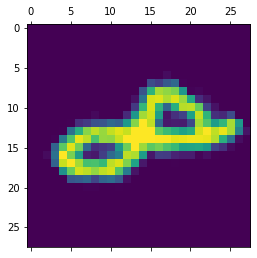

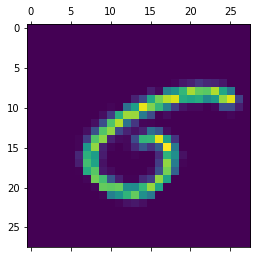

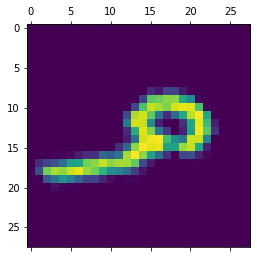

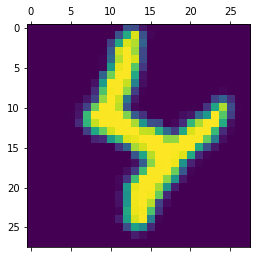

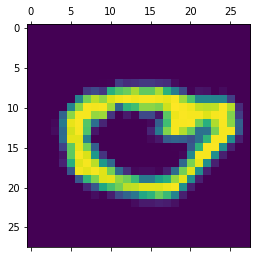

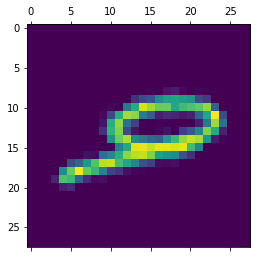

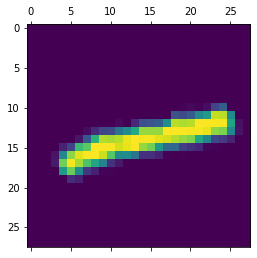

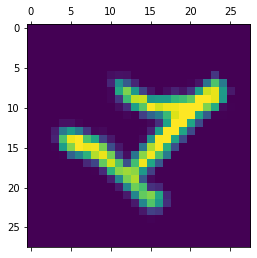

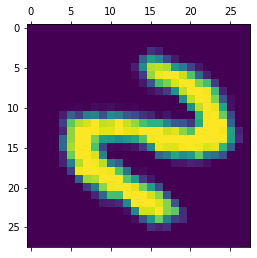

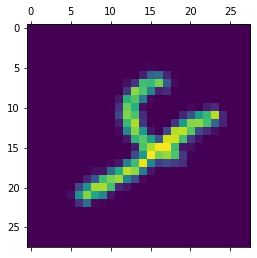

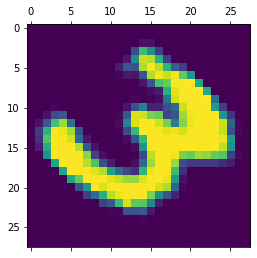

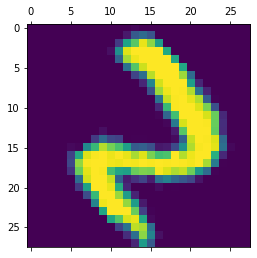

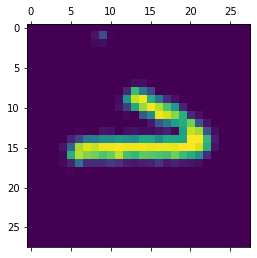

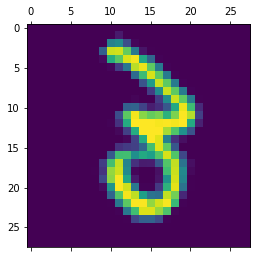

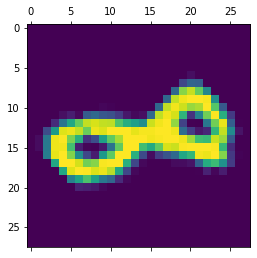

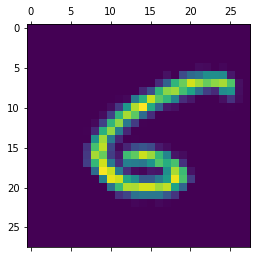

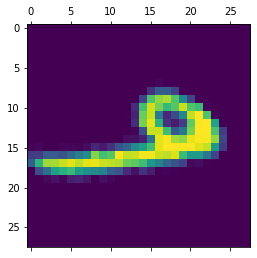

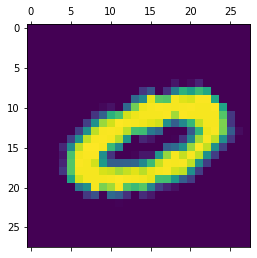

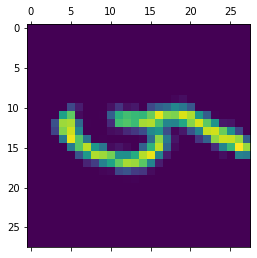

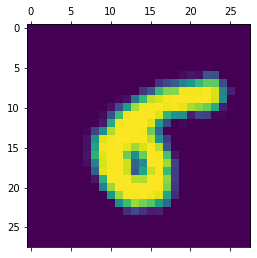

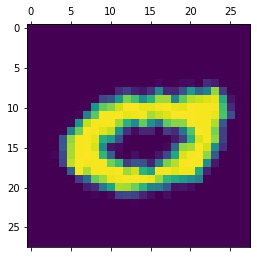

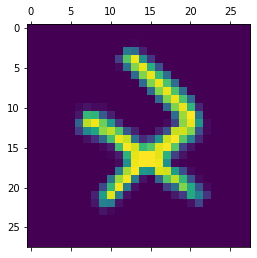

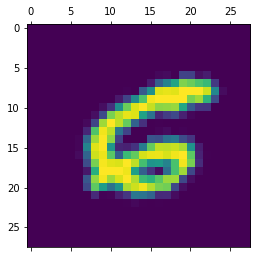

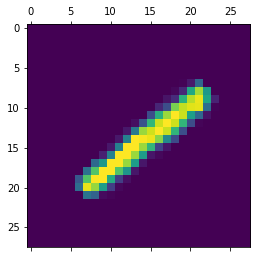

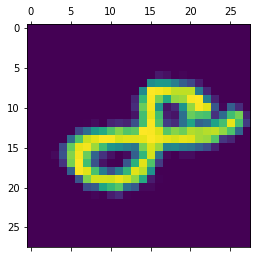

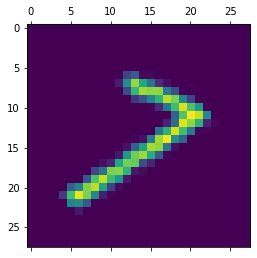

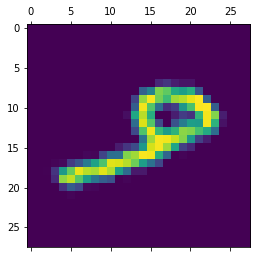

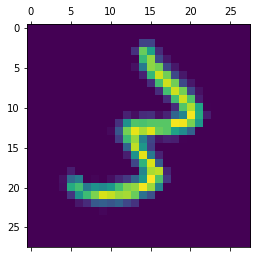

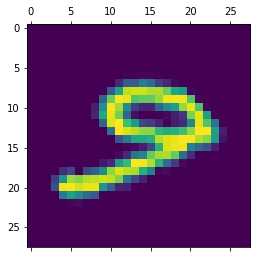

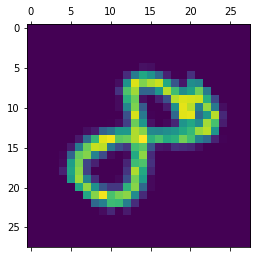

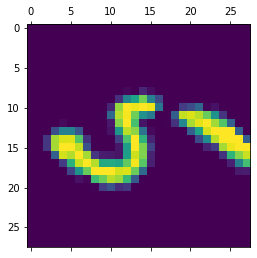

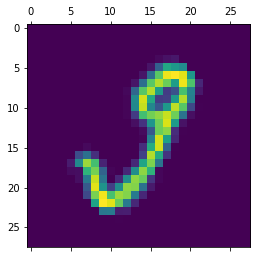

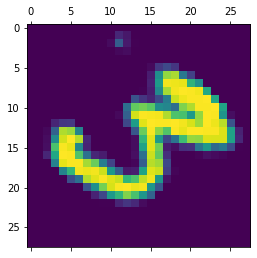

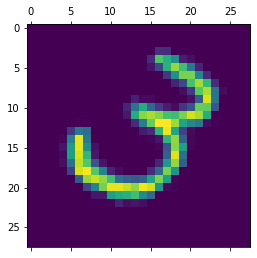

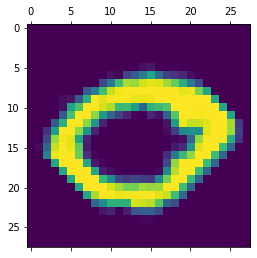

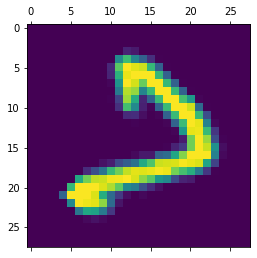

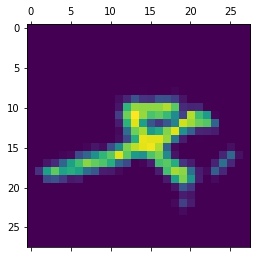

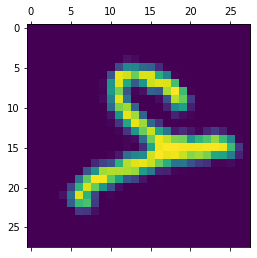

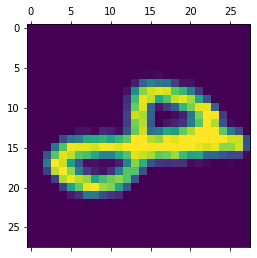

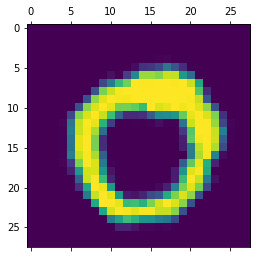

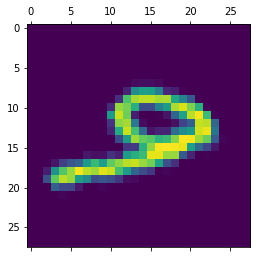

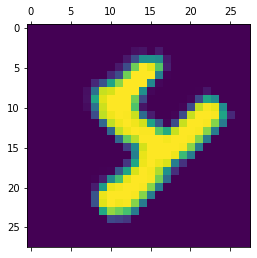

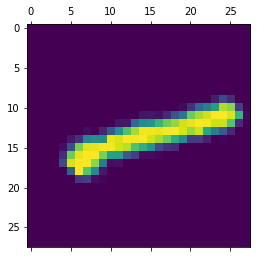

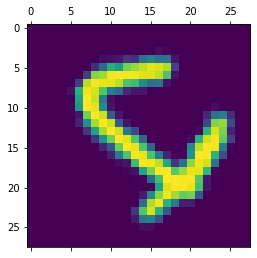

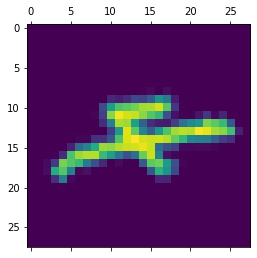

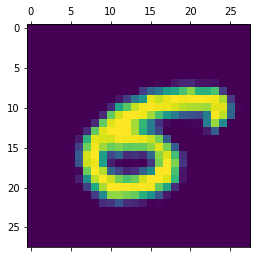

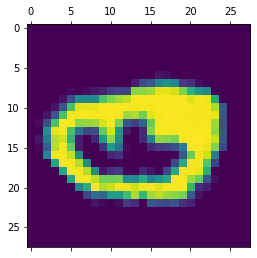

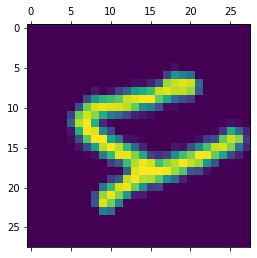

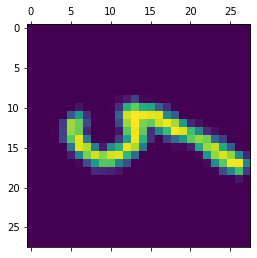

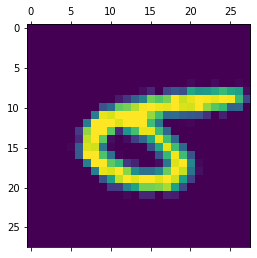

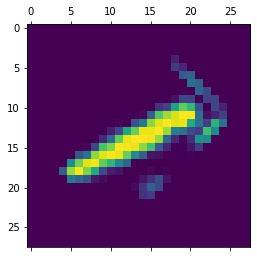

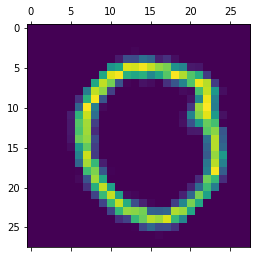

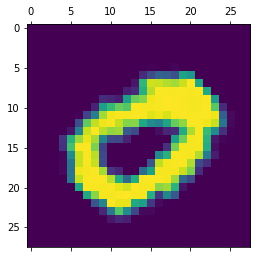

In [16]:
for i in range(70):
    # plt.matshow(data_images_trnsf["no noise"][i])
    plt.matshow(data_images_trnsf["rotation 45"][i])



 1-dim PH wrt chosen filtration: 
 

data point 1 : 
 [[3.91421356 4.24264069]
 [3.97196014 4.30038727]
 [4.07923527 4.32954938]
 [4.10495331 4.32954938]
 [4.10727513 4.35758924]
 [4.13299316 4.35758924]
 [4.13299316 4.35758924]
 [4.13299316 4.35758924]
 [4.13299316 4.35758924]
 [4.13299316 4.35758924]
 [4.10727513 4.35758924]
 [4.13299316 4.35758924]
 [4.10866406 4.40956595]
 [4.23535036 4.44173879]
 [4.25957604 4.44173879]
 [4.25957604 4.44173879]
 [4.29052595 4.46486436]
 [4.29052595 4.46486436]
 [4.31510025 4.46486436]
 [4.18841396 4.46731254]
 [4.18755634 4.46877674]
 [4.31624398 4.4905824 ]
 [4.24026829 4.4905824 ]
 [4.39107595 4.51167795]
 [4.36650165 4.51167795]
 [4.36650165 4.54084006]
 [4.36650165 4.54084006]
 [4.39107595 4.54084006]
 [4.4357688  4.54720672]
 [4.4357688  4.54720672]
 [4.4357688  4.54720672]
 [4.4357688  4.54720672]
 [4.31318964 4.54991557]
 [4.48733817 4.56541436]
 [4.50382186 4.57473196]
 [4.50382186 4.57473196]
 [4.57865382 4.62203869]
 [4.57865382 4.62203

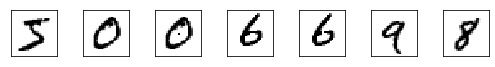

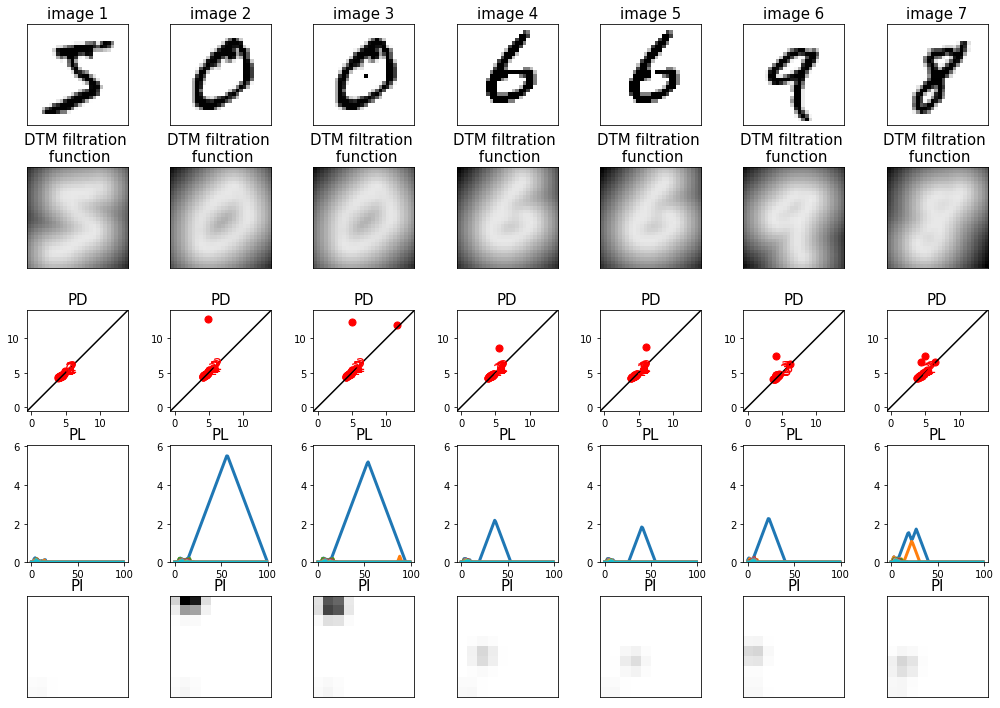

In [17]:
# Auxiliary cell for 28 x 28 images (or without data_4 and data_5 for any dataset) 
# to gain some initial insights into the discriminative power and noise robustness
# (under affine transformations, change of a greyscale value of a single pixel,
# change in brightness or noisy transformations)
# (Table 1 in turkevs2021noise),
# and to guide the choice of filtration and signature parameters,
# prior to the calculation of filtration functions and PH on the complete dataset.

# Choose images.
data_1 = np.copy(data[0])
data_2 = np.copy(data[47])
data_3 = np.copy(data[1])
data_4 = np.copy(data_3)
data_4[14*28+14] = 255 # add outlying black pixel in the background, in the middle of the hole
# data_4[2*28-2] = 255 # add outlying black pixel in the background
data_5 = np.copy(data[66])
data_5[12*28+14] = 0 
data_5[12*28+15] = 0 
data_5[12*28+16] = 0 
data_5[12*28+17] = 0 
data_5[14*28+14] = 0 
data_5[14*28+15] = 0 
data_5[14*28+16] = 0 
# data_5 = np.copy(data_trnsf["salt and pepper noise 10"][1])
data_6 = np.copy(data_5)
data_6[13*28+14] = 0 # replace a black pixel on the hole with a white pixel, disconnect the hole
data_7 = np.copy(data[18])
data_8 = np.copy(data[4])
data_translated_up = affine_transform(data, {'tx':5, 'ty':5})
data_9 = np.copy(data_translated_up[4])
data_10 = np.copy(data[17])
data_11 = np.copy(data_trnsf["brightness 100"][17])
data_12 = np.copy(data_trnsf["salt and pepper noise 10"][17])
data_13 = np.copy(data_trnsf["shot noise 100"][17])
# data_temp = np.asarray([data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10, data_11, data_12, data_13])
data_temp = np.asarray([data_1, data_3, data_4, data_5, data_6, data_8, data_10])

# Choose filtration function.
filt_temp = "DTM"

# Choose filtration function parameters and calculate filtration function values.
if filt_temp == "binary":
    filt_func_vals_temp = binary_filtration_function(data_temp, 0.5)
if filt_temp == "grsc":
    filt_func_vals_temp = greyscale_filtration_function(data_temp)
if filt_temp == "density":
    filt_func_vals_temp = density_filtration_function(data_temp, 0.5, 1) 
if filt_temp == "radial":
    filt_func_vals_temp = radial_filtration_function(data_temp, 0.5, 0, 0)
if filt_temp == "Rips":
    filt_func_vals_temp = distance_filtration_function(data_temp, 0.5)
if filt_temp == "DTM":
    filt_func_vals_temp = dtm_filtration_function(data_temp, 0.5, 0.1)

# Choose PD parameters (for Rips and DTM) and calculate PDs.
PDs0, PDs1 = pers_intervals_across_homdims(filt_func_vals_temp, filt_temp, data_temp, 0.5, [np.inf])
    
# Choose homological dimension.
homdim_temp = "1-dim"
if homdim_temp == "0-dim":
    PDs_temp = PDs0
    # Although the filtration function values are all finite, 0-dim PDs can contain features with np.inf as death value.
    for PD in PDs0:
        max_data_filt_temp = np.max(filt_func_vals_temp)
        for i, pers_interval in enumerate(PD):
            if pers_interval[1] == np.inf:
                if filt_temp != "Rips" and filt_temp != "DTM":
                    pers_interval[1] = max_data_filt_temp
                if filt_temp == "Rips":
                    pers_interval[1] = np.sqrt(num_x_pixels**2 + num_y_pixels**2)
                if filt_temp == "DTM":
                    # This is how the filtration function is calculated on an edge in weighted_simplex_tree() above.
                    pers_interval[1] = max_data_filt_temp + max_data_filt_temp + np.sqrt(num_x_pixels**2 + num_y_pixels**2)
else:
    PDs_temp = PDs1
    
# Print persistence intervals for Table 1 in turkevs2021noise.
print("\n", homdim_temp, "PH wrt chosen filtration: \n \n")
for i, PD in enumerate(PDs_temp): 
    print("data point %d" %(i+1), ": \n", PD, "\n\n")
    

# Calculate maximum value in PDs, to define PI bandwidth
# and to determine the range of x and y-axis in PD plot.
max_PDs_temp = 0
for PD in PDs_temp:
    max_PD = np.max(PD)
    if max_PD > max_PDs_temp:
        max_PDs_temp = max_PD        
    
# Choose PL parameters and calculate PLs.
landscape_ = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
PLs_temp = landscape_.fit_transform(PDs_temp)

# Choose PI parameters and caclulate PIs.
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * max_PDs_temp, 
                                                  weight = lambda x: x[1]**2, resolution = [10, 10])
PIs_temp = pers_image_.fit_transform(PDs_temp)
    
# Print figure of images for Table 1 in turkevs2021noise.
num_fig_rows = 1
num_fig_cols = data_temp.shape[0]
subfig_height = 1
subfig_width = 1
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0) 
for column, data_point in enumerate(data_temp):
    plot_image(data_point.reshape(num_x_pixels, num_y_pixels), vmin = min_data, vmax = max_data, axes = axes[column])
fig.savefig("FIGURES/choice_of_filtration_images", bbox_inches = "tight")


# Plot PDs, PLs, PIs.
num_fig_rows = 5
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = np.min(data_temp), vmax = np.max(data_temp), axes = axes[0, column])
    axes[0, column].set_title("image %d" %(column+1), fontsize = 15)
    # Filtration function values.
    filt_func_vals = np.copy(filt_func_vals_temp[column])
    filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
    plot_image(filt_func_vals, vmin = 0, vmax = np.max(filt_func_vals_temp), axes = axes[1, column]) 
    axes[1, column].set_title(filt_temp + " filtration \n function", fontsize = 15)
    # PD.
    PD = np.copy(PDs_temp[column])
    plot_PD(PD, xymax = max_PDs_temp, axes = axes[2, column]) 
    axes[2, column].set_title("PD", fontsize = 15)   
    # PL.
    PL = np.copy(PLs_temp[column])
    plot_PL(PL, num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs_temp), axes = axes[3, column])
    axes[3, column].set_title("PL", fontsize = 15)
    # PI.
    PI = np.copy(PIs_temp[column])
    plot_PI(PI, pers_image_resolution = 10, vmin = 0, vmax = np.max(PIs_temp), axes = axes[4, column])
    axes[4, column].set_title("PI", fontsize = 15)     
plt.show()

Check how d([0, l], empty) scales with l for PDs, PLs and PIs: 

PD =  [[0 0]]
W2(PD, empty) =  0.0
l2(PL, empty) =  0.0
l2(PI, empty) =  0.0

l2(PI, empty)^2 / l^4 = nan
PD =  [[0 1]]
W2(PD, empty) =  0.5
l2(PL, empty) =  0.01400211447894155
l2(PI, empty) =  0.3052621022055158

l2(PI, empty)^2 / l^4 = 0.09318495104293077
PD =  [[0 2]]
W2(PD, empty) =  1.0
l2(PL, empty) =  1.400491462185103
l2(PI, empty) =  0.2724527270094524

l2(PI, empty)^2 / l^4 = 0.004639405528430449
PD =  [[0 3]]
W2(PD, empty) =  1.5
l2(PL, empty) =  2.010559322510624
l2(PI, empty) =  0.050319633873708844

l2(PI, empty)^2 / l^4 = 3.126006855782848e-05
PD =  [[0 5]]
W2(PD, empty) =  2.5
l2(PL, empty) =  4.495420231582769
l2(PI, empty) =  4.6889981434621246e-05

l2(PI, empty)^2 / l^4 = 3.5178725743026004e-12
PD =  [[ 0 10]]
W2(PD, empty) =  5.0
l2(PL, empty) =  13.064055350531278
l2(PI, empty) =  27.14795484251515

l2(PI, empty)^2 / l^4 = 0.07370114521312418
PD =  [[ 0 15]]
W2(PD, empty) =  7.5
l2(PL, empty) =  23.7

C:\Users\renat\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\renat\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in power


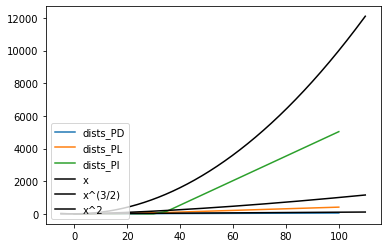

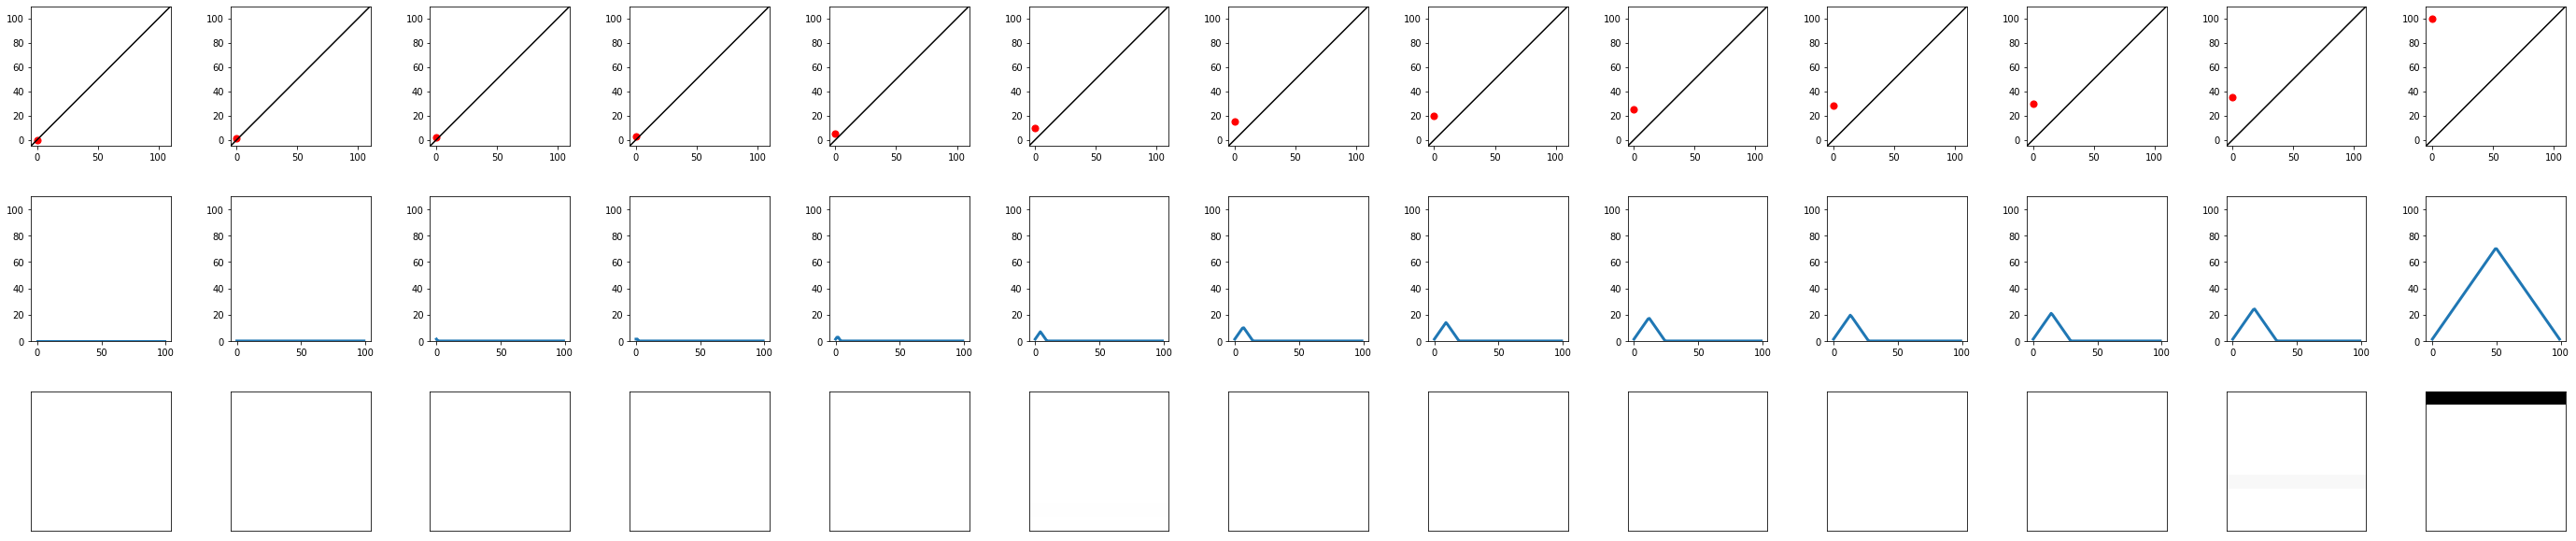

In [18]:
print("Check how d([0, l], empty) scales with l for PDs, PLs and PIs: \n")
ls = np.asarray([0, 1, 2, 3, 5, 10, 15, 20, 25, 28, 30, 35, 100])
# ls = np.asarray([0, 0.1, 0.2, 0.5, 0.75, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8, 2, 2.1, 2.2])
PDs = []    
num_PDs = len(ls)
for l in ls:
    PDs.append(np.asarray([[0, l]]))
landscape_ = gd.representations.Landscape(num_landscapes = 1, resolution = 100)
PLs = landscape_.fit_transform(PDs)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 1, weight = lambda x: x[1]**2, resolution = [10, 10])
# pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 100, weight = lambda x: x[1]**2, resolution = [10, 10])
# pers_image_ = gd.representations.PersistenceImage(bandwidth = 1/np.sqrt(2 * 3.14), weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
# Calculate distances.
dists_PDs = np.zeros(num_PDs)
dists_PLs = np.zeros(num_PDs)
dists_PIs = np.zeros(num_PDs)
for i in range(num_PDs):
    dists_PDs[i] = gudhi.wasserstein.wasserstein_distance(PDs[i], PDs[0], order = 2, internal_p = np.inf)
    dists_PLs[i] = np.linalg.norm(PLs[i] - PLs[0], ord = 2)
    dists_PIs[i] = np.linalg.norm(PIs[i] - PIs[0], ord = 2)
    print("PD = ", PDs[i])
    print("W2(PD, empty) = ", dists_PDs[i])
    print("l2(PL, empty) = ", dists_PLs[i])
    print("l2(PI, empty) = ", dists_PIs[i])
    print()
    
    print("l2(PI, empty)^2 / l^4 =", dists_PIs[i]**2 / ls[i]**4)
    
    

    
# Plot distances.
plt.plot(ls, dists_PDs)
plt.plot(ls, dists_PLs)
plt.plot(ls, dists_PIs)
x = np.arange(-0.05 * np.max(ls), 1.1 * np.max(ls), 0.01)
plt.plot(x, x, c = "black")
plt.plot(x, x**(3/2), c = "black")
plt.plot(x, x**2, c = "black")
plt.legend(("dists_PD", "dists_PL", "dists_PI", "x", "x^(3/2)", "x^2"), loc = "lower left")
plt.show()


num_fig_rows = 3
num_fig_cols = num_PDs
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
for i in range(num_PDs):
    plot_PD(PDs[i], xymax = 100, axes = axes[0, i])
    plot_PL(PLs[i], num_lndscs = 1, lndsc_resolution = 100, ymax = 100, axes = axes[1, i])
    plot_PI(PIs[i], pers_image_resolution = 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, i])


An example (synthetic) PD, and the obtained PL and PI:


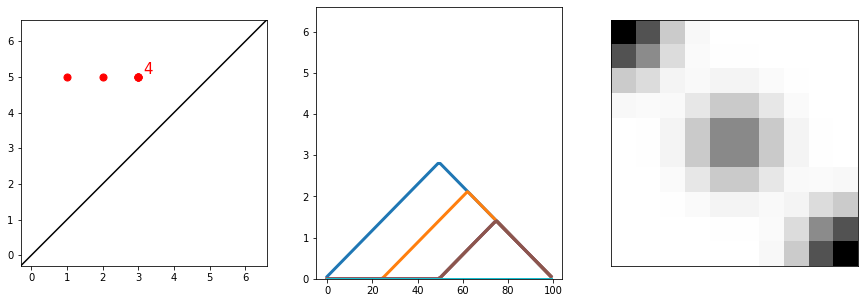

np.max(PI) =  40.743668010641436




d(PH1, PH0) and d(PH2, PH0), when PH points are matched to each other, or when both are matched to diagonal:


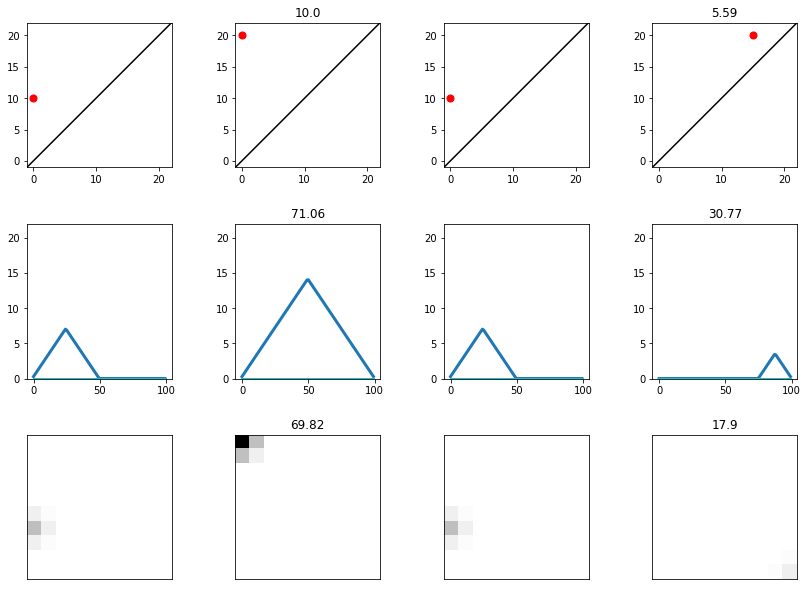





d([0, l], PH_furthest) and d([0, l], PH_empty):
distance^2(PHi, PH0):
PD:   0.000   1600.000   100.000   
PL:   0.000   47126.752   3366.337   
PI:   0.000   164749.859   1474.099   
distance^2(PHi, PH0) / max_distance^2(PH, PH0): 
PD:   0.000   1.000   0.125   
PL:   0.000   1.000   0.071   
PI:   0.000   1.000   0.009   



d([0, l], empty) and d([0, 2l], empty):
d(PH, empty):
PD:   0.000   50.000   100.000   
PL:   0.000   2886.896   8165.374   
PI:   0.000   38.394   202.037   

d**2(PH, empty):
PD:   0.000   2500.000   10000.000   
PL:   0.000   8334166.583   66673332.667   
PI:   0.000   1474.099   40818.940   W2_PD1_empty**2 / W2_PD2_empty**2 =  0.25
l2_PL1_empty**2 / l2_PL2_empty**2 =  0.1249999999999858
l2_PI1_empty**2 / l2_PI2_empty**2 =  0.03611310371720589




PHi is obtained from PH0 by changing the existing lifespan of the cycle, or by including additional cycle:
d(PH_i, PH_0) =
PD:   0.00   2.55   13.24   0.25   4.50   0.50   1.50   0.50   3.91   
PL:   0.00   100.01

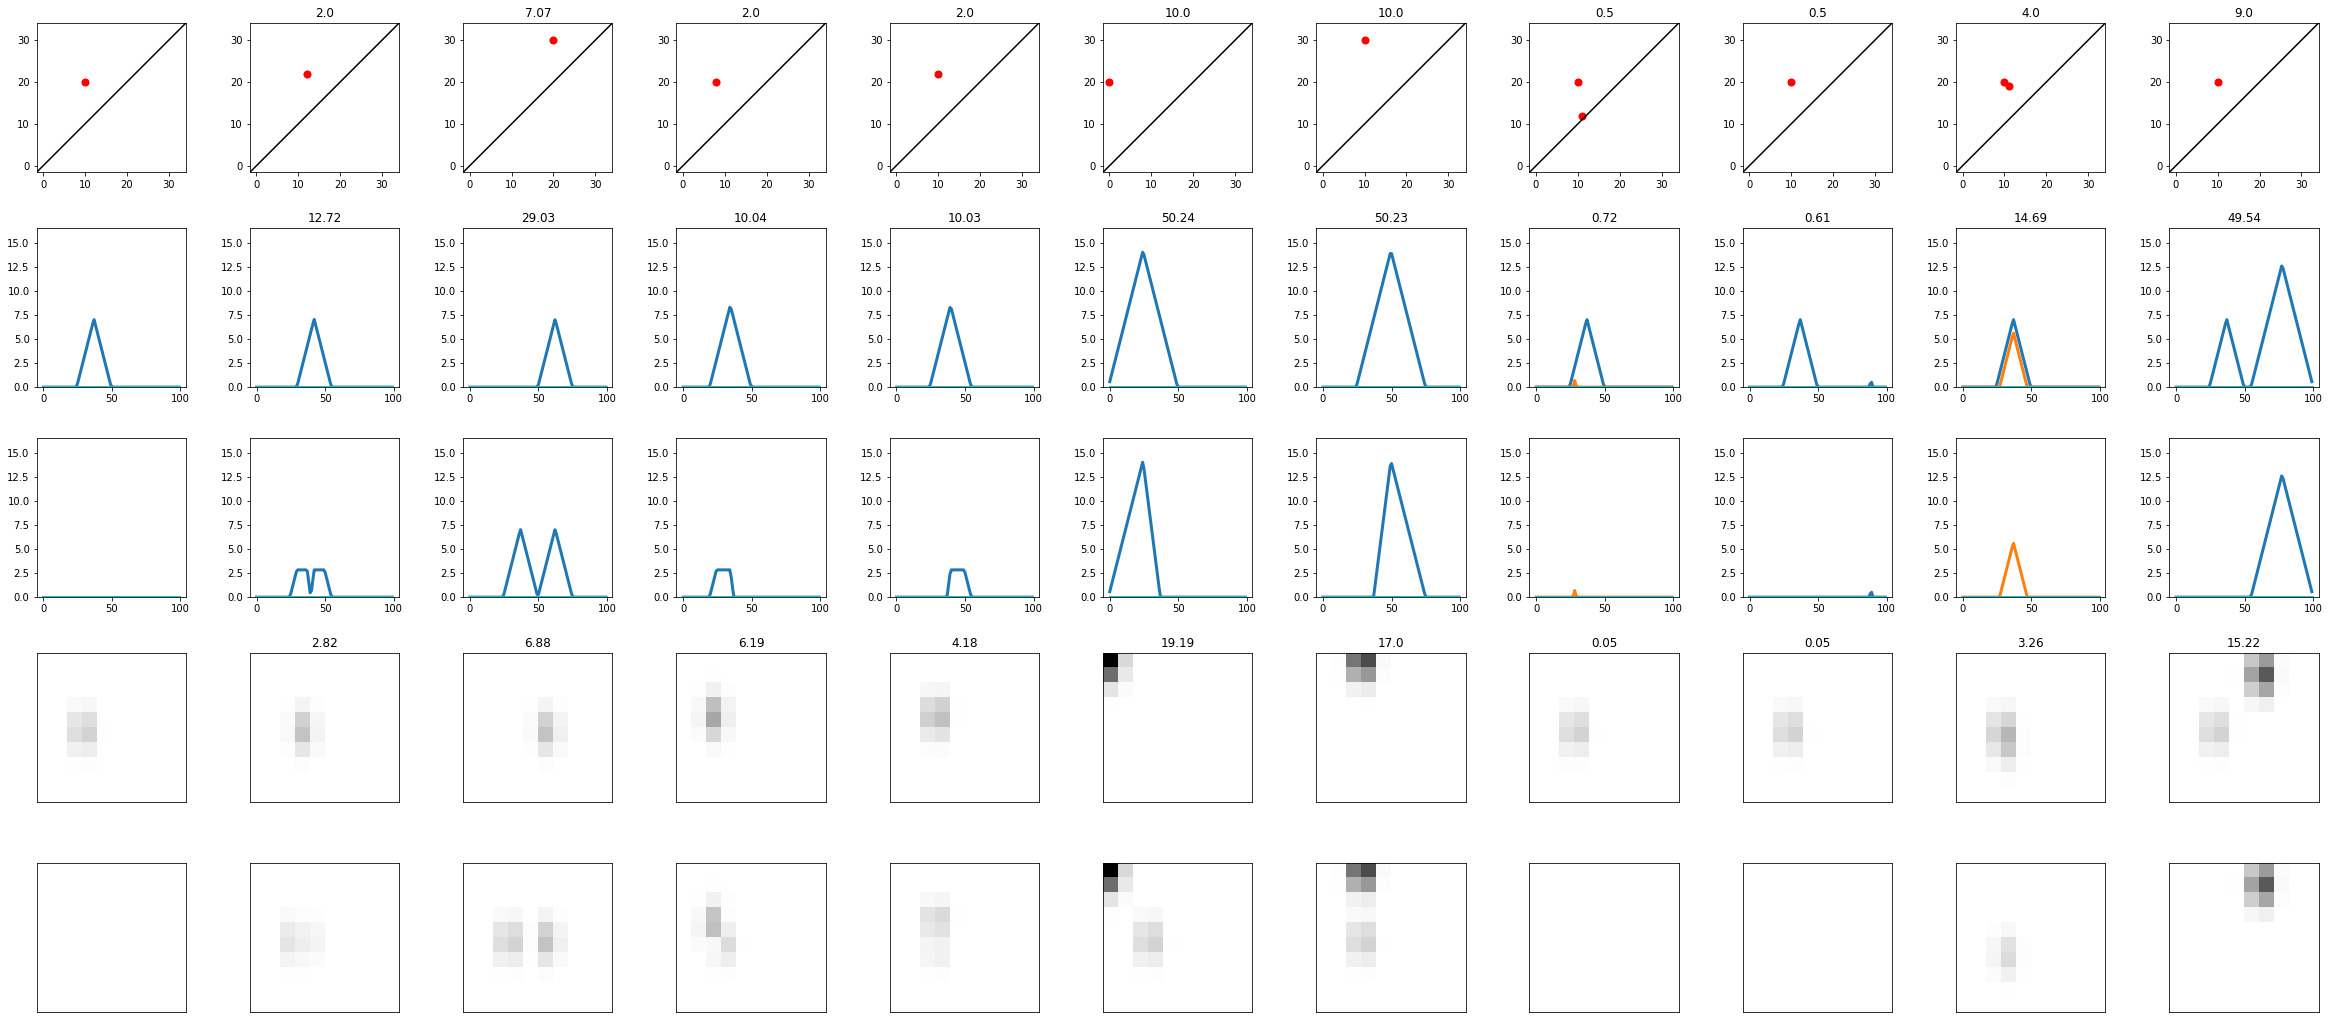

In [19]:
# Auxiliary cell to understand the importance of choice of signatures (on synthetic PDs)
# i.e., to understand how the choice of persistence signature influences the noise robustness
# and discriminative power of PH, i.e., how much does a change from PH to PH' result in a change in d(PH', PH),
# where d(PH', PH) is Wasserstein_2 distance between PDs, or l_2 distance between PLs or PIs.

landscape_ = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 5, weight = lambda x: x[1]**2, resolution = [10, 10])


print("An example (synthetic) PD, and the obtained PL and PI:")
PD = np.asarray([[1, 5], [2, 5], [3, 5], [3, 5], [3, 5], [3, 5]]) 
PL = landscape_.fit_transform([PD])[0]
PI = pers_image_.fit_transform([PD])[0]
num_fig_rows = 1
num_fig_cols = 3
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
plot_PD(PD, xymax = 6, axes = axes[0])
plot_PL(PL, num_lndscs = 10, lndsc_resolution = 100, ymax = 6, axes = axes[1])
plot_PI(PI, 10, vmin = 0, vmax = np.max(PI), axes = axes[2])
plt.show()
print("np.max(PI) = ", np.max(PI))
print("\n\n\n")


print("d(PH1, PH0) and d(PH2, PH0), when PH points are matched to each other, or when both are matched to diagonal:")
PD0 = np.asarray([[0, 10]])
PD1 = np.asarray([[0, 20]]) # points in PD1 and PD0 are matched to each other
PD2 = np.asarray([[15, 20]]) # points in PD2 and PD0 are both matched to diagonal
PDs = [PD0, PD1, PD2]     
PLs = landscape_.fit_transform(PDs)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 20, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
num_fig_rows = 3
num_fig_cols = 4
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
plot_PD(PD0, xymax = 20, axes = axes[0, 0])
plot_PD(PD1, xymax = 20, axes = axes[0, 1])
plot_PD(PD0, xymax = 20, axes = axes[0, 2])
plot_PD(PD2, xymax = 20, axes = axes[0, 3])
plot_PL(PLs[0], num_lndscs = 10, lndsc_resolution = 100, ymax = 20, axes = axes[1, 0])
plot_PL(PLs[1], num_lndscs = 10, lndsc_resolution = 100, ymax = 20, axes = axes[1, 1])
plot_PL(PLs[0], num_lndscs = 10, lndsc_resolution = 100, ymax = 20, axes = axes[1, 2])
plot_PL(PLs[2], num_lndscs = 10, lndsc_resolution = 100, ymax = 20, axes = axes[1, 3])
plot_PI(PIs[0], 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, 0])
plot_PI(PIs[1], 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, 1])
plot_PI(PIs[0], 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, 2])
plot_PI(PIs[2], 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, 3])
axes[0, 1].set_title(np.around(gudhi.wasserstein.wasserstein_distance(PD1, PD0, order = 2, internal_p = np.inf), 2))
axes[0, 3].set_title(np.around(gudhi.wasserstein.wasserstein_distance(PD2, PD0, order = 2, internal_p = np.inf), 2))
axes[1, 1].set_title(np.around(np.linalg.norm(PLs[1] - PLs[0], ord = 2), 2))
axes[1, 3].set_title(np.around(np.linalg.norm(PLs[2] - PLs[0], ord = 2), 2))
axes[2, 1].set_title(np.around(np.linalg.norm(PIs[1] - PIs[0], ord = 2), 2))
axes[2, 3].set_title(np.around(np.linalg.norm(PIs[2] - PIs[0], ord = 2), 2))                                          
plt.show()
print("\n\n\n")


print("d([0, l], PH_furthest) and d([0, l], PH_empty):")
PD_0 = np.asarray([[0, 20]]) 
PD_furthest = np.asarray([[0, 40], [0, 40]]) # most distant PD in [0, 40]x[0, 40], if max two cycles exist
PD_empty = np.asarray([[0, 0]]) 
PDs = [PD_0, PD_furthest, PD_empty]     
PLs = landscape_.fit_transform(PDs)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 40, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
print("distance^2(PHi, PH0):")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.3f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 1, internal_p = np.inf)**2), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.3f}".format(np.linalg.norm(PL - PLs[0], ord = 2)**2), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.3f}".format(np.linalg.norm(PI - PIs[0], ord = 2)**2), end = "   ")
print()
max_PD_dist = gudhi.wasserstein.wasserstein_distance(PD_furthest, PD_0, order = 2, internal_p = np.inf)
max_PL_dist = np.linalg.norm(PLs[1] - PLs[0], ord = 2)
max_PI_dist = np.linalg.norm(PIs[1] - PIs[0], ord = 2)
print("distance^2(PHi, PH0) / max_distance^2(PH, PH0): ")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.3f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 2, internal_p = np.inf)**2 / max_PD_dist**2), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.3f}".format(np.linalg.norm(PL - PLs[0], ord = 2)**2 / max_PL_dist**2), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.3f}".format(np.linalg.norm(PI - PIs[0], ord = 2)**2 / max_PI_dist**2), end = "   ")
print("\n\n\n")


print("d([0, l], empty) and d([0, 2l], empty):")
PD_empty = np.asarray([[0, 0]]) 
PD_1 = np.asarray([[0, 1*100]]) # most distant PD in [0, 10]x[0, 10]
PD_2 = np.asarray([[0, 2*100]]) 
PDs = [PD_empty, PD_1, PD_2]     
landscape_ = gd.representations.Landscape(num_landscapes = 1, resolution = 10000) # PL_num # PL_resolution
PLs = landscape_.fit_transform(PDs)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 200, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
print("d(PH, empty):")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.3f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 1, internal_p = np.inf)), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.3f}".format(np.linalg.norm(PL - PLs[0], ord = 2)), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.3f}".format(np.linalg.norm(PI - PIs[0], ord = 2)), end = "   ")
print("\n\nd**2(PH, empty):")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.3f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 1, internal_p = np.inf)**2), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.3f}".format(np.linalg.norm(PL - PLs[0], ord = 2)**2), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.3f}".format(np.linalg.norm(PI - PIs[0], ord = 2)**2), end = "   ")
W2_PD1_empty = gudhi.wasserstein.wasserstein_distance(PDs[1], PDs[0], order = 1, internal_p = np.inf)
W2_PD2_empty = gudhi.wasserstein.wasserstein_distance(PDs[2], PDs[0], order = 1, internal_p = np.inf)
print("W2_PD1_empty**2 / W2_PD2_empty**2 = ", W2_PD1_empty**2 / W2_PD2_empty**2)
l2_PL1_empty = np.linalg.norm(PLs[1] - PLs[0], ord = 2)
l2_PL2_empty = np.linalg.norm(PLs[2] - PLs[0], ord = 2)
print("l2_PL1_empty**2 / l2_PL2_empty**2 = ", l2_PL1_empty**2 / l2_PL2_empty**2)
l2_PI1_empty = np.linalg.norm(PIs[1] - PIs[0], ord = 2)
l2_PI2_empty = np.linalg.norm(PIs[2] - PIs[0], ord = 2)
print("l2_PI1_empty**2 / l2_PI2_empty**2 = ", l2_PI1_empty**2 / l2_PI2_empty**2)
print("\n\n\n")


print("PHi is obtained from PH0 by changing the existing lifespan of the cycle, or by including additional cycle:")
PD_0 = np.asarray([[1, 5], [2, 3], [4, 7]]) 
PD_1 = np.asarray([[1, 5], [2, 3], [4, 7], [3, 3.5]]) 
PD_2 = np.asarray([[1, 5], [2, 3], [4, 7], [3, 12]]) 
PD_3 = np.asarray([[1, 5], [4, 7]]) 
PD_4 = np.asarray([[1, 5], [2, 3]]) 
PD_5 = np.asarray([[1, 5.5], [2, 3], [4, 7]]) 
PD_6 = np.asarray([[1, 10], [2, 3], [4, 7]]) 
PD_empty = np.asarray([[0, 0]])
PD_furthest = np.asarray([[0, 15], [0, 15], [0, 15]]) # We assume a dataset with maximum 3 cycles in [0,15]x[0,15].
PDs = [PD_0, PD_empty, PD_furthest, PD_1, PD_2, PD_3, PD_4, PD_5, PD_6]     
PLs = landscape_.fit_transform(PDs)
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 15, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
print("d(PH_i, PH_0) =")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.2f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 2, internal_p = np.inf)), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.2f}".format(np.linalg.norm(PL - PLs[0], ord = 2)), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.2f}".format(np.linalg.norm(PI - PIs[0], ord = 2)), end = "   ")
print()
max_PD_dist = gudhi.wasserstein.wasserstein_distance(PD_furthest, PD_empty, order = 2, internal_p = np.inf)
max_PL_dist = np.linalg.norm(PLs[2] - PLs[1], ord = 2)
max_PI_dist = np.linalg.norm(PIs[2] - PIs[1], ord = 2)
print("d(PH_i, PH_0) / max d =")
print("PD:", end = "   ")
for PD in PDs:
    print("{:.3f}".format(gudhi.wasserstein.wasserstein_distance(PD, PDs[0], order = 2, internal_p = np.inf) / max_PD_dist), end = "   ")
print("\nPL:", end = "   ")
for PL in PLs:
    print("{:.3f}".format(np.linalg.norm(PL - PLs[0], ord = 2) / max_PL_dist), end = "   ")    
print("\nPI:", end = "   ")
for PI in PIs: 
    print("{:.3f}".format(np.linalg.norm(PI - PIs[0], ord = 2) / max_PI_dist), end = "   ")
print("\n\n\n")
    

print("PHi is obtained from PH0 by changing the existing lifespan of the cycle, or by including additional cycle:")
PD0 = np.asarray([[10, 20]])
PD1 = np.asarray([[12, 22]]) # l unchanged, b=b+eps, d=d+eps, close to (b,d)
PD2 = np.asarray([[20, 30]]) # l unchanged, b=b+eps, d=d+eps, far from (b,d)
PD3 = np.asarray([[8, 20]]) # l increased a little bit, b=b-eps, d=d
PD4 = np.asarray([[10, 22]])# l increased a little bit, b=b, d=d+eps
PD5 = np.asarray([[0, 20]]) # l increased a lot, b=b-eps, d=d
PD6 = np.asarray([[10, 30]]) # l increased a lot, b=b, d=d+eps
PD7 = np.asarray([[10, 20], [11, 12]]) # additional small lifespan, close to (b,d)
PD8 = np.asarray([[10, 20], [35, 36]]) # additional small lifespan, far from (b,d)
PD9 = np.asarray([[10, 20], [11, 19]]) # additional large lifespan, close to (b,d)
PD10 = np.asarray([[10, 20], [22, 40]]) # additional large lifespan, far from (b,d)
PDs = [PD0, PD1, PD2, PD3, PD4, PD5, PD6, PD7, PD8, PD9, PD10]     
# PLs.
landscape_ = gd.representations.Landscape(num_landscapes = 10, resolution = 100)
PLs = landscape_.fit_transform(PDs)
# PIs.
pers_image_ = gd.representations.PersistenceImage(bandwidth = 0.05 * 40, weight = lambda x: x[1]**2, resolution = [10, 10])
PIs = pers_image_.fit_transform(PDs)
num_fig_rows = 5
num_fig_cols = 11
subfig_height = 3
subfig_width = 3
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 3.0)
print("distance(PH, PH0) =")
for i in range(num_fig_cols):
    plot_PD(PDs[i], xymax = 30+1, axes = axes[0, i])    
    plot_PL(PLs[i], num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[1, i])
    plot_PL(np.abs(PLs[i] - PLs[0]), num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[2, i])
    plot_PI(PIs[i], 10, vmin = 0, vmax = np.max(PIs), axes = axes[3, i])
    plot_PI(np.abs(PIs[i]-PIs[0]), 10, vmin = 0, vmax = np.max(PIs), axes = axes[4, i])
    if i > 0:
        axes[0, i].set_title(np.around(gudhi.wasserstein.wasserstein_distance(PDs[i], PD0, order = 2, internal_p = np.inf), 2))
        axes[1, i].set_title(np.around(np.linalg.norm(PLs[i] - PLs[0], ord = 2), 2))
        axes[3, i].set_title(np.around(np.linalg.norm(PIs[i] - PIs[0], ord = 2), 2))
plt.show()
# print("distance(PH, PH0) / norm(PH0) =")
# for i in range(num_fig_cols):
#     plot_PD(PDs[i], xymax = 40, axes = axes[0, i])
#     plot_PL(PLs[i], num_lndscs = 10, lndsc_resolution = 100, ymax = np.max(PLs)+1, axes = axes[1, i])
#     plot_PI(PIs[i], 10, vmin = 0, vmax = np.max(PIs), axes = axes[2, i])    
#     if i > 0:
#         axes[0, i].set_title(np.around(gudhi.wasserstein.wasserstein_distance(PDs[i], PD0, order = 2, internal_p = np.inf) / gudhi.wasserstein.wasserstein_distance(PD0, np.asarray([[0, 0]]), order = 2, internal_p = np.inf), 2))
#         axes[1, i].set_title(np.around(np.linalg.norm(PLs[i] - PLs[0], ord = 2) / np.linalg.norm(PLs[0], ord = 2), 2))
#         axes[2, i].set_title(np.around(np.linalg.norm(PIs[i] - PIs[0], ord = 2) / np.linalg.norm(PIs[0], ord = 2), 2))
#     else: 
#         axes[0, 0].set_title(np.around(gudhi.wasserstein.wasserstein_distance(PD0, np.asarray([[0, 0]]), order = 2, internal_p = np.inf), 2))
#         axes[1, 0].set_title(np.around(np.linalg.norm(PLs[0], ord = 2), 2))
#         axes[2, 0].set_title(np.around(np.linalg.norm(PIs[0], ord = 2), 2))
# plt.show()

In [20]:
# Compute "data_filt_func_vals_trnsf", dictionary which stores the filtration function values for any (noisy and non-noisy)
# image.
data_filt_trnsf = {}
runtime_data_filt_trnsf = {}

# Make a choice on the set of filtrations to be considered in the experiments.
filts = ["binary", "grsc", "density", "radial", "Rips", "DTM"]
# If we wish to investigate only some of the filtration functions, or shorten the computation time, we can consider e.g.:
# filts = ["DTM"]
num_filts = len(filts)

# Auxiliary function to enable parallel computing of filtration functions.
def filt_trnsf(filt, trnsf, data):    
    t0 = time.time()         
    if filt == "binary":          
        filt_func_vals = binary_filtration_function(data, threshold_grsc_perc)        
    if filt == "grsc":          
        filt_func_vals = greyscale_filtration_function(data)        
    if filt == "density":               
        filt_func_vals = density_filtration_function(data, threshold_grsc_perc, density_max_dist)       
    if filt == "radial":
        filt_func_vals = radial_filtration_function(data, threshold_grsc_perc, radial_x_pixel, radial_y_pixel)        
    if filt == "Rips": 
        filt_func_vals = distance_filtration_function(data, threshold_grsc_perc)
    if filt == "DTM": 
        filt_func_vals = dtm_filtration_function(data, threshold_grsc_perc, dtm_m)        
    filt_func_vals_dict = {}    
    filt_func_vals_dict[filt, trnsf] = filt_func_vals
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[filt, trnsf] = runtime  
    return filt_func_vals_dict, runtime_dict

# !!! Choice of parameters for the filtration functions.
threshold_grsc_perc = 0.5
density_max_dist = 1
radial_x_pixel = 0
radial_y_pixel = 0
dtm_m = 0.05 # 0.05

print("Parallel calculation of filtration functions for the given dataset, across filtrations and data transformations ...")
t0 = time.time()
filt_func_vals_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(filt_trnsf)(filt, trnsf, data_trnsf[trnsf])
    for filt in filts
    for trnsf in trnsfs)
for filt_func_vals_dict, runtime_dict in filt_func_vals_and_runtime_dicts:
    data_filt_trnsf.update(filt_func_vals_dict)
    runtime_data_filt_trnsf.update(runtime_dict)
with open("VARIABLES/data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(data_filt_trnsf, f)
with open("VARIABLES/runtime_data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(runtime_data_filt_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s" % runtime)

# Calculate maximum filtration function values, in order to properly visualize the filtrations,
# and to help to later properly replace the np.inf as death values in 0-dim PH.
max_data_filt = {}
for filt in filts:
    max_data_filt[filt] = 0
    for trnsf in trnsfs:
        max_data_filt_trnsf = np.max(data_filt_trnsf[filt, trnsf])
        if max_data_filt_trnsf > max_data_filt[filt]:
            max_data_filt[filt] = max_data_filt_trnsf

Parallel calculation of filtration functions for the given dataset, across filtrations and data transformations ...
Runtime = 8.633 s


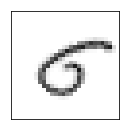

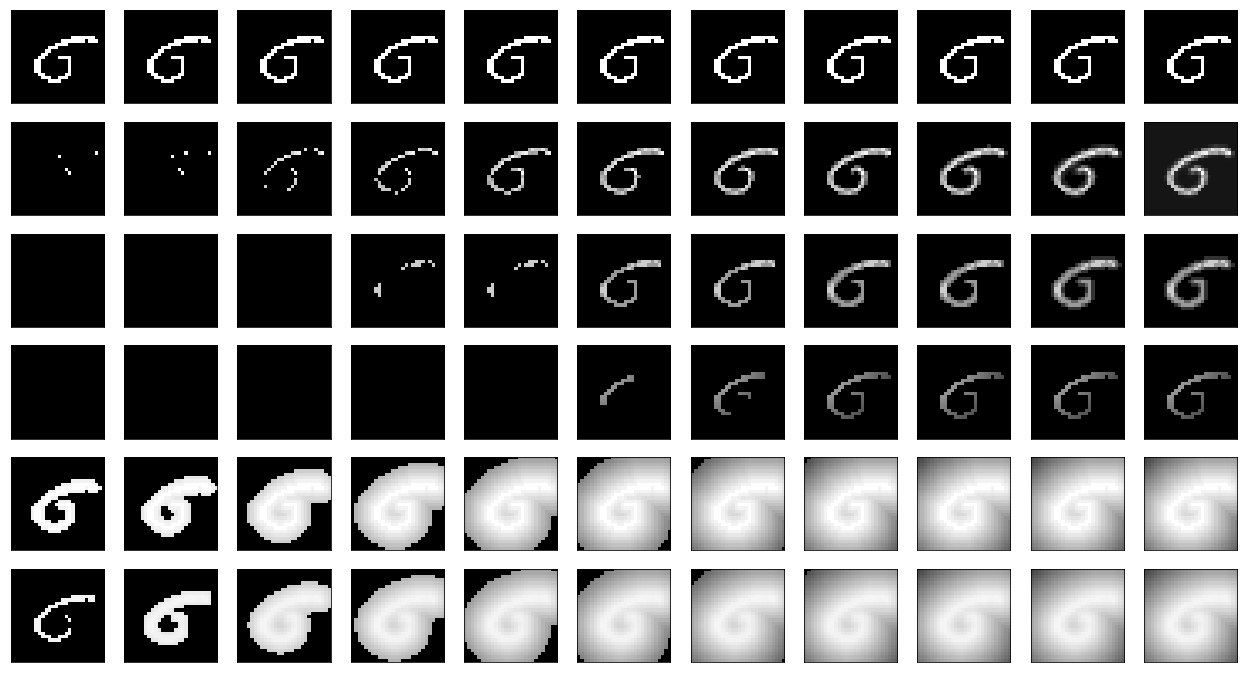

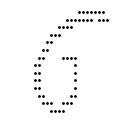

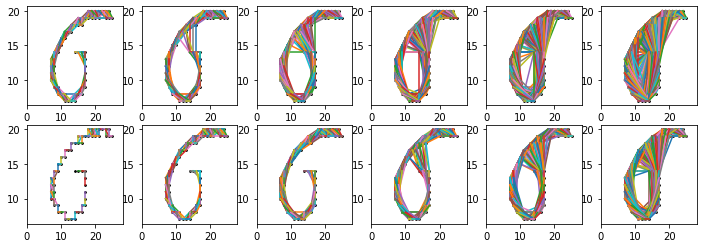

data_filt_trnsf[density, rotation 45].shape = (70, 784)
data_filt_trnsf[density, rotation 45][example].shape = (784,)
data_filt_trnsf[Rips, rotation 45].shape = (70, 784)
data_filt_trnsf[Rips, rotation 45][example].shape = (784,)

max_data_filt[ binary ] =  1.0
max_data_filt[ grsc ] =  255.00000000000003
max_data_filt[ density ] =  5.0
max_data_filt[ radial ] =  38.18376618407357
max_data_filt[ Rips ] =  20.808652046684813
max_data_filt[ DTM ] =  21.142374511865977

data_filt_trnsf[Rips, no noise][example] = 
 [[14.42 13.6  12.81 12.04 11.31 10.63  9.9   9.22  8.49  7.81  7.07  6.4
   5.66  5.    4.24  3.61  3.16  3.    3.    3.16  3.61  4.24  5.    5.83
   6.71  7.62  8.54  9.49]
 [13.89 13.04 12.21 11.4  10.63  9.9   9.22  8.49  7.81  7.07  6.4   5.66
   5.    4.24  3.61  2.83  2.24  2.    2.    2.24  2.83  3.61  4.47  5.39
   6.32  7.28  8.25  9.22]
 [13.42 12.53 11.66 10.82 10.    9.22  8.49  7.81  7.07  6.4   5.66  5.
   4.24  3.61  2.83  2.24  1.41  1.    1.    1.41  2.24  3.16  

In [21]:
# Auxiliary cell to visualize and explore filtration (function)s, for an example (noisy or non-noisy) image.
# and, if necessary, to adjust the choice of parameters for filtrations in the previous cell.

example = 18
trnsf = "rotation 45"

subfig_height = 2
subfig_width = 2
       
# Visualize image.
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_image(data_images_trnsf[trnsf][example], vmin = min_data, vmax = max_data, axes = axes)

# Visualize filtrations on image.
filt_func_vals_percentages = np.asarray([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
num_fig_rows = num_filts
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
for f, filt in enumerate(filts):
    filt_func_vals_pixels = np.copy(data_filt_trnsf[filt, trnsf][example])
    filt_func_vals_pixels = filt_func_vals_pixels.reshape((num_x_pixels, num_y_pixels)) 
    for p, perc in enumerate(filt_func_vals_percentages):
        cubical_complex = np.zeros((num_x_pixels, num_y_pixels)) + max_data_filt[filt]
        filt_func_val_upper_limit = perc * max_data_filt[filt]
        for i in range(num_x_pixels):
            for j in range(num_y_pixels):
                if(filt_func_vals_pixels[i, j] < filt_func_val_upper_limit):
                    cubical_complex[i, j] = filt_func_vals_pixels[i, j]                    
        plot_image(cubical_complex, vmin = 0, vmax = max_data_filt[filt], axes = axes[f, p])
    
# Visualize point cloud from image.
point_cloud = build_point_cloud(data_trnsf[trnsf][example], threshold_grsc_perc)
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
axes.scatter(point_cloud[:, 0], point_cloud[:, 1], c = "black", s = 3)
axes.set_xlim(0, num_x_pixels)
axes.set_xlim(0, num_y_pixels)
axes.axis('off')
   
# Visualize filtrations on point cloud.
filt_func_vals_percentages = np.asarray([0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) # [0.02, 0.03, 0.05, 0.1, 0.125, 0.15]
num_fig_rows = 2
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
for f, filt in enumerate(["Rips", "DTM"]):    
    num_points = point_cloud.shape[0]
    distances_between_points = euclidean_distances(point_cloud)    
    if filt == "Rips":
        filt_func_vals_points = np.zeros(num_points)
        filt_func_vals_edges = distances_between_points
    else:
        filt_func_vals = np.copy(data_filt_trnsf[filt, trnsf][example])   
        filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels)) 
        filt_func_vals_points = np.zeros(num_points, )
        for p, point in enumerate(point_cloud):  
            i = num_y_pixels - point[1].astype(int)
            j = point[0].astype(int)
            filt_func_vals_points[p] = filt_func_vals[i, j]
        filt_func_vals_edges = np.zeros((num_points, num_points))
        for i in range(num_points): 
            for j in range(i):           
                # This is how the filtration function is calculated on an edge in weighted_simplex_tree() above.
                if distances_between_points[i][j] <= np.abs(filt_func_vals_points[i] - filt_func_vals_points[j]):
                    filt_func_vals_edges[i][j] = 2 * np.maximum(filt_func_vals_points[i], filt_func_vals_points[j])
                else:
                    filt_func_vals_edges[i][j] = ( filt_func_vals_points[i] + filt_func_vals_points[j] + distances_between_points[i][j] ) # / 2
    max_filt_val_points = np.max(filt_func_vals_points)
    max_filt_val_edges = np.max(filt_func_vals_edges)
    max_filt_val = np.maximum(max_filt_val_points, max_filt_val_edges)    
    for p, perc in enumerate(filt_func_vals_percentages):
        filt_func_val_upper_limit = perc * max_filt_val        
        # Plot all point cloud points with filtration function value under the given limit.
        for i in range(num_points): 
            if filt_func_vals_points[i] < filt_func_val_upper_limit:
                axes[f, p].scatter(point_cloud[i, 0], point_cloud[i, 1], c = "black", s = 3)         
        # Plot all point cloud edges with filtration function value under the given limit.
        for i in range(num_points): 
            for j in range(i):           
                if filt_func_vals_edges[i, j] < filt_func_val_upper_limit:
                    edge_point_1 = point_cloud[i]
                    edge_point_2 = point_cloud[j]
                    x_values = [edge_point_1[0], edge_point_2[0]]
                    y_values = [edge_point_1[1], edge_point_2[1]]                    
                    axes[f, p].plot(x_values, y_values)    
        axes[f, p].set_xlim(0, num_x_pixels)
        axes[f, p].set_xlim(0, num_y_pixels)       
        # axes[f, p].axis('off')
        
plt.show()

# Explore filtration functions.    
print("data_filt_trnsf[density, rotation 45].shape =", data_filt_trnsf["density", "rotation 45"].shape)
print("data_filt_trnsf[density, rotation 45][example].shape =", data_filt_trnsf["density", "rotation 45"][example].shape)
print("data_filt_trnsf[Rips, rotation 45].shape =", data_filt_trnsf["Rips", "rotation 45"].shape)
print("data_filt_trnsf[Rips, rotation 45][example].shape =", data_filt_trnsf["Rips", "rotation 45"][example].shape)
print()
for filt in filts:
    print("max_data_filt[", filt, "] = ", max_data_filt[filt])
print()
print("data_filt_trnsf[Rips, no noise][example] = \n", 
      np.around(data_filt_trnsf["Rips", "no noise"][example].reshape((num_x_pixels, num_y_pixels)), 2))
print()
print("data_filt_trnsf[DTM, no noise][example] = \n", 
      np.around(data_filt_trnsf["DTM", "no noise"][example].reshape((num_x_pixels, num_y_pixels)), 2))

In [22]:
# Compute persistent homology information across filtrations and persistent signatures, on non-noisy and noisy datasets.
data_sign_homdim_filt_trnsf = {}
runtime_data_sign_homdim_filt_trnsf = {}

# Make a choice on the set of homological dimensions and persistent signatures to be considered in the experiments.
homdims = ["0-dim", "1-dim"]
signs = ["PD", "PL", "PI"]
# If we wish to investigate only some of the persistence signatures, or shorten the computation time, we can consider e.g.:
# signs = ["PI", "PL"]
num_homdims = len(homdims)
num_signs = len(signs)


# We cannot parallelize across all persistent signatures, because persistence diagramds (PDs) need to be calculated first,
# as they are input for persistence landscapes (PLs) and persistence images (PIs).
# Therefore, we first parallelize calculations of PDs across filtrations and transformations (not parallelizing across 
# homdims not to construct the filtrations, i.e. structured complexes filtered with a filtration function, multiple times). 
# Next, we parallelize calculations for remaining vector persistent signatures.
# 1) Parallel calculation of PDs, across filts, trnsfs.
# 2) Parallel calculation of PH, across remaining signs, homdims, filts, trnsfs.





# Auxiliary function to enable parallel computing of PDs.
def pers_intervals_filt_trnsf_across_homdims(filt, trnsf, filt_func_vals, data):   
    
    print(filt, trnsf)
    t0 = time.time()
    if filt == "binary":          
        ph = pers_intervals_across_homdims(filt_func_vals, "binary")               
    if filt == "grsc":          
        ph = pers_intervals_across_homdims(filt_func_vals, "grsc")    
    if filt == "density":
        ph = pers_intervals_across_homdims(filt_func_vals, "density")
    if filt == "radial":
        ph = pers_intervals_across_homdims(filt_func_vals, "radial")
    if filt == "Rips":         
        ph = pers_intervals_across_homdims(filt_func_vals, "Rips", data, threshold_grsc_perc, [rips_max_edge_length])   
    if filt == "DTM": 
        ph = pers_intervals_across_homdims(filt_func_vals, "DTM", data, threshold_grsc_perc, [dtm_max_filt_func_val])       
    ph_dict = {}    
    ph_dict["PD", "0-dim", filt, trnsf] = ph[0]
    ph_dict["PD", "1-dim", filt, trnsf] = ph[1]          
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict["PD", "0-dim", filt, trnsf] = runtime
    runtime_dict["PD", "1-dim", filt, trnsf] = runtime  
    return ph_dict, runtime_dict

# !!! Choice of parameters for the computation of PH wrt Rips and DTM filtrations.
rips_max_edge_length = np.inf # all cycles with lifespan > max_edge_length will be considered equally important/persistent 
dtm_max_filt_func_val = np.inf # all cycles with lifespan >dtm_max_filt_func_val will be considered equally important/persistent 

print("Parallel calculation of persistence intervals (for every homological dimension) across filtrations and data transformations...")
t0 = time.time()
ph_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(pers_intervals_filt_trnsf_across_homdims)(filt, trnsf, data_filt_trnsf[filt, trnsf], data_trnsf[trnsf])
    for filt in filts
    for trnsf in trnsfs)
for ph_dict, runtime_dict in ph_and_runtime_dicts:
    data_sign_homdim_filt_trnsf.update(ph_dict)
    runtime_data_sign_homdim_filt_trnsf.update(runtime_dict)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s \n" % runtime)

# Although the filtration function values are all finite, 0-dim PDs can contain features with np.inf as death value.
for filt in filts:
    for trnsf in trnsfs:
        for pers_intervals_homdim0_data_point in data_sign_homdim_filt_trnsf["PD", "0-dim", filt, trnsf]:
            for i, pers_interval in enumerate(pers_intervals_homdim0_data_point):
                if pers_interval[1] == np.inf:
                    if filt != "Rips" and filt != "DTM":
                        pers_interval[1] = max_data_filt[filt]
                    if filt == "Rips":
                        pers_interval[1] = np.sqrt(num_x_pixels**2 + num_y_pixels**2)
                    if filt == "DTM":
                        # This is how the filtration function is calculated on an edge in weighted_simplex_tree() above.
                        pers_interval[1] = ( max_data_filt["DTM"] + max_data_filt["DTM"] + np.sqrt(num_x_pixels**2 + num_y_pixels**2) ) # / 2
                        
                        
# Calculate min and max for PDs, as these are necessary to define:
# PL range, PI bandwidth, PI range (see below).
min_birth_PDs_homdim_filt = {}
max_birth_PDs_homdim_filt = {}
min_death_PDs_homdim_filt = {}
max_death_PDs_homdim_filt = {}
min_lifespan_PDs_homdim_filt = {}
max_lifespan_PDs_homdim_filt = {}
for homdim in homdims:
    for filt in filts:        
        min_birth_PDs_homdim_filt[homdim, filt] = np.inf
        max_birth_PDs_homdim_filt[homdim, filt] = 0
        min_death_PDs_homdim_filt[homdim, filt] = np.inf
        max_death_PDs_homdim_filt[homdim, filt] = 0
        min_lifespan_PDs_homdim_filt[homdim, filt] = np.inf
        max_lifespan_PDs_homdim_filt[homdim, filt] = 0
        for trnsf in trnsfs:            
            PDs_trnsf = data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf]            
            birth_values = []
            death_values = []
            lifespans = []
            for PD in PDs_trnsf:
                for pers_interval in PD:
                    b = pers_interval[0]
                    d = pers_interval[1]
                    birth_values.append(b)
                    death_values.append(d)
                    lifespans.append(d-b)
            min_birth_PDs_trnsf = np.min(birth_values)
            max_birth_PDs_trnsf = np.max(birth_values)
            min_death_PDs_trnsf = np.min(death_values)
            max_death_PDs_trnsf = np.max(death_values)
            min_lifespan_PDs_trnsf = np.min(lifespans)
            max_lifespan_PDs_trnsf = np.max(lifespans)
            if min_birth_PDs_trnsf < min_birth_PDs_homdim_filt[homdim, filt]:
                min_birth_PDs_homdim_filt[homdim, filt] = min_birth_PDs_trnsf  
            if max_birth_PDs_trnsf > max_birth_PDs_homdim_filt[homdim, filt]:
                max_birth_PDs_homdim_filt[homdim, filt] = max_birth_PDs_trnsf  
            if min_death_PDs_trnsf < min_death_PDs_homdim_filt[homdim, filt]:
                min_death_PDs_homdim_filt[homdim, filt] = min_death_PDs_trnsf  
            if max_death_PDs_trnsf > max_death_PDs_homdim_filt[homdim, filt]:
                max_death_PDs_homdim_filt[homdim, filt] = max_death_PDs_trnsf
            if min_lifespan_PDs_trnsf < min_lifespan_PDs_homdim_filt[homdim, filt]:
                min_lifespan_PDs_homdim_filt[homdim, filt] = min_lifespan_PDs_trnsf  
            if max_lifespan_PDs_trnsf > max_lifespan_PDs_homdim_filt[homdim, filt]:
                max_lifespan_PDs_homdim_filt[homdim, filt] = max_lifespan_PDs_trnsf
                
# for filt in filts:
#     for homdim in homdims:
#         print(filt, homdim)
#         print(min_birth_PDs_homdim_filt[homdim, filt]) 
#         print(max_birth_PDs_homdim_filt[homdim, filt]) 
#         print(min_death_PDs_homdim_filt[homdim, filt]) 
#         print(max_death_PDs_homdim_filt[homdim, filt]) 
#         print(min_lifespan_PDs_homdim_filt[homdim, filt])
#         print(max_lifespan_PDs_homdim_filt[homdim, filt]) 
#         print()


            
        
# Auxiliary function to enable parallel computing of PLs and PIs.
def transform_pers_intervals_to_vector_sign(sign, homdim, filt, trnsf, pers_ints):
    
    # print(sign, homdim, filt, trnsf, "\n")
    
    t0 = time.time()    
    if sign == "PL":
        # PL sample_range is the minimum and maximum of all piecewise-linear function domains, 
        # (the interval on which samples will be drawn evenly).
        # If sample range is not given, it is calculated within .fit()
        # as the minimum and maximum value of PDs.
        # However, we fit PLs separately across transformations, so that
        # if e.g. PD=[0, 10] changes under noise to [0, 20],
        # the base of the two PLs could span across the whole range on the x-axis.
        # To properly reflect the change in PDs in their PLs,
        # the range to plot the bases should be the same across all trasnformations!
        x_min = min_birth_PDs_homdim_filt[homdim, filt] 
        x_max = max_death_PDs_homdim_filt[homdim, filt]
        landscape = gd.representations.Landscape(num_landscapes = PL_num, 
                                                 resolution = PL_resolution,
                                                 sample_range = [x_min, x_max])
        ph = landscape.fit_transform(pers_ints)        
    if sign == "PI":       
        # Similarly as with PLs above, the im_range needs to be 
        # explicitly given when fitting PIs,
        # in order for the change in PDs under transfromations
        # to be properly reflected in the PIs.
        x_min = min_birth_PDs_homdim_filt[homdim, filt]
        x_max = max_birth_PDs_homdim_filt[homdim, filt]
        y_min = min_lifespan_PDs_homdim_filt[homdim, filt] # or should it be weighted with rho? 
        y_max = max_lifespan_PDs_homdim_filt[homdim, filt] # or should it be weighted with rho?        
        pers_image = gd.representations.PersistenceImage(bandwidth = PI_bandwidth[homdim, filt], 
                                                         weight = PI_weight_func, 
                                                         resolution = [PI_resolution, PI_resolution],
                                                         im_range = [x_min, x_max, y_min, y_max])  
        ph = pers_image.fit_transform(pers_ints)
    ph_dict = {}
    ph_dict[sign, homdim, filt, trnsf] = ph       
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[sign, homdim, filt, trnsf] = runtime    
    return ph_dict, runtime_dict

# !!! Choice of parameters for the computation of PLs and PIs.
PL_num = 10
PL_resolution = 100
PI_bandwidth = {}
for homdim in homdims:
    for filt in filts:
        PI_bandwidth[homdim, filt] = 0.05 * max_death_PDs_homdim_filt[homdim, filt]        
        # garin2019topological: Gaussian sigma (not for PI, but for a similar heat kernel above PD) is 10 and 15,
        # but "in the unit of disrete filtration values".        
PI_weight_func = lambda x: x[1]**2
PI_resolution = 10
# We only look at 10 most important landscape functions, implying that image with 2 cycles and image with 100 cycles
# (e.g., under salt and pepper noise) will be in any case considered less different for PLs then PDs or PIs !!!

print("Parallel transformation of persistence intervals into vectors, across vector persistent signatures, homological dimensions and filtrations ...")
t0 = time.time()
ph_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(transform_pers_intervals_to_vector_sign)(sign, homdim, filt, trnsf, data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf])
    for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"] 
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
for ph_dict, runtime_dict in ph_and_runtime_dicts:
    data_sign_homdim_filt_trnsf.update(ph_dict)
    runtime_data_sign_homdim_filt_trnsf.update(runtime_dict)
t1 = time.time()
runtime = t1 - t0
print("Runtime = %.3f s \n" % runtime)

# For persistence signs computed from PDs, calculate the runtime as the sum of the runtime needed to calculate PDs
# for the given filtration, and the runtime for transforming the PDs into the given persistence signature.
for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"]:
    for homdim in homdims:
        for filt in filts:
            for trnsf in trnsfs:  
                runtime_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] = runtime_data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf] + runtime_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf]

# Calculate PH maximum values, in order to properly visualize it later.
max_data_sign_homdim_filt = {}
for sign in [signs[s] for s in range(len(signs)) if signs[s] != "PD"]:
    for homdim in homdims:
        for filt in filts:
            max_data_sign_homdim_filt[sign, homdim, filt] = 0
            for trnsf in trnsfs:
                max_data_sign_homdim_filt_trnsf = np.max(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])
                if max_data_sign_homdim_filt_trnsf > max_data_sign_homdim_filt[sign, homdim, filt]:
                    max_data_sign_homdim_filt[sign, homdim, filt] = max_data_sign_homdim_filt_trnsf
                
                
                
# Store the variables.
with open("VARIABLES/data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(data_sign_homdim_filt_trnsf, f)    
with open("VARIABLES/runtime_data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(runtime_data_sign_homdim_filt_trnsf, f)

Parallel calculation of persistence intervals (for every homological dimension) across filtrations and data transformations...
Runtime = 146.929 s 

Parallel transformation of persistence intervals into vectors, across vector persistent signatures, homological dimensions and filtrations ...
Runtime = 14.231 s 



In [23]:
# Auxiliary cell to explore the persistent homology variables.

# Explore the computation times of different steps:
# %load_ext line_profiler
# %lprun -f density_filtration_function pers_intervals_filt_trnsf_across_homdims("density", "stretch-shear-flip 0.75 -20 v", data_filt_trnsf["density", "stretch-shear-flip 0.75 -20 v"], data_trnsf["stretch-shear-flip 0.75 -20 v"])
# %lprun -f distance_filtration_function pers_intervals_filt_trnsf_across_homdims("Rips", "stretch-shear-flip 0.75 -20 v", data_filt_trnsf["Rips", "stretch-shear-flip 0.75 -20 v"], data_trnsf["stretch-shear-flip 0.75 -20 v"])
   
# Explore the variables storing persistent homology information.
print("Persistent homology information for the dataset, across signatures, homological dimensions, filtrations, transformations:")
print("type(data_sign_homdim_filt_trnsf) = ", type(data_sign_homdim_filt_trnsf))
print("len(data_sign_homdim_filt_trnsf) = ", len(data_sign_homdim_filt_trnsf))
print()
print("Persistent diagrams for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) = ", type(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"]))
print("len(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) = ", len(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"]))
print("type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example]) = ", type(data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example]))
print("data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example].shape = ", data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example].shape)
print("data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise] = \n", data_sign_homdim_filt_trnsf["PD", "0-dim", "grsc", "no noise"][example])
print()
print("Persistent landscapes for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45]) = ", type(data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"]))
print("len(data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45]) = ", len(data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"]))
print("type(data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45][example]) = ", type(data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example]))
print("data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45].shape = ", data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example].shape)
print("data_sign_homdim_filt_trnsf[PL, 0-dim, grsc, rotation 45] = \n", data_sign_homdim_filt_trnsf["PL", "0-dim", "grsc", "rotation 45"][example])    
print()
print("Persistent images for the dataset and for an example image, for some homological dimension, filtration and transformation:")
print("type(data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2]) = ", type(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"]))
print("len(data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2]) = ", len(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"]))
print("type(data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example]) = ", type(data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example]))
print("data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example].shape = ", data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example].shape)
print("data_sign_homdim_filt_trnsf[PI, 1-dim, Rips, translation -2 -2][example] = \n", data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "translation -2 -2"][example])

Persistent homology information for the dataset, across signatures, homological dimensions, filtrations, transformations:
type(data_sign_homdim_filt_trnsf) =  <class 'dict'>
len(data_sign_homdim_filt_trnsf) =  612

Persistent diagrams for the dataset and for an example image, for some homological dimension, filtration and transformation:
type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) =  <class 'list'>
len(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise]) =  70
type(data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example]) =  <class 'numpy.ndarray'>
data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise][example].shape =  (10, 2)
data_sign_homdim_filt_trnsf[PD, 0-dim, grsc, no noise] = 
 [[ 12.  24.]
 [  2.  26.]
 [  8.  34.]
 [  4.  45.]
 [ 42.  46.]
 [  8.  55.]
 [  5.  60.]
 [  2.  62.]
 [  1.  74.]
 [  0. 255.]]

Persistent landscapes for the dataset and for an example image, for some homological dimension, filtration and transformation:
type(data_sign_homd

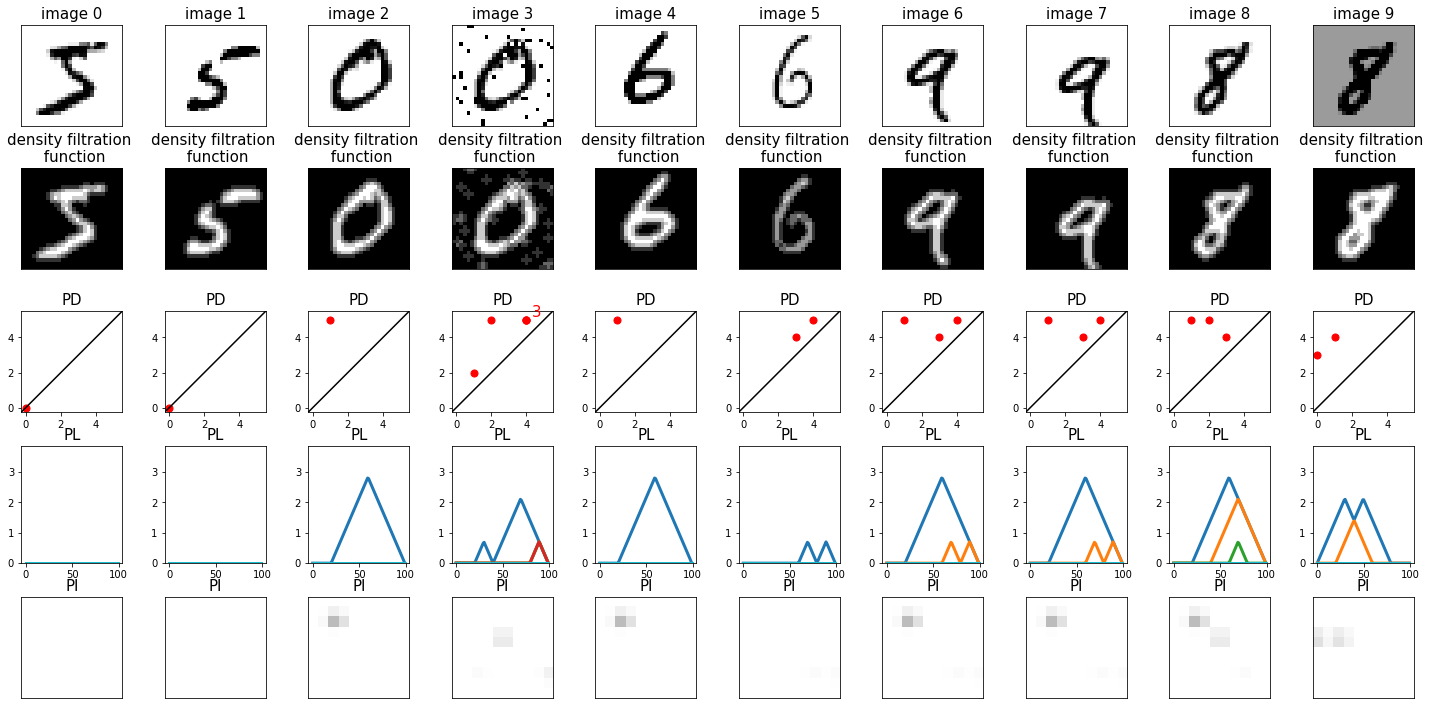

Inetermezzo: The image with the darkest pixel in a persistence image: 
max_PIs =  127.32395447351628 for image 31 under transformation  contrast 2
max_data_sign_homdim_filt[PI, homdim, filt] = 127.32395447351628


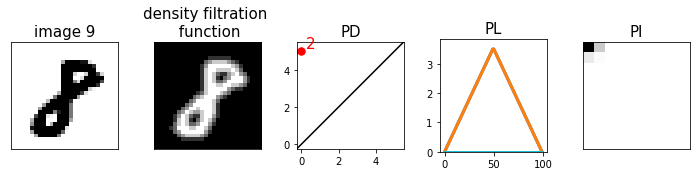

C:\Users\renat\Anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data' of function 'l_p_distance_matrix'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-399bff3d10a7>", line 51:
@njit(parallel = True)
def l_p_distance_matrix(data, p):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\renat\Anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data' of function '__numba_parfor_gufunc_0x14f5a7d6dc8'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line 1:
<

Distance matrices should have pretty white 2x2 pixel patches around the diagonal, d(non-noisy, noisy), for noise robustness;
and dark pixels outside, d(one class, other class), for discriminative power. 


Distances between images in the same class (0 for images 1 and 2, 6 for images 3 and 4, 9 for images 5 and 6)
are more reasonable for persistent homology than original image representation as greyscale pixel values
(note the small bright squares around the diagonal in Wasserstein distance matrices)! 


Consider also if distance matrices between PDs, PLs, PIs reflect each other.


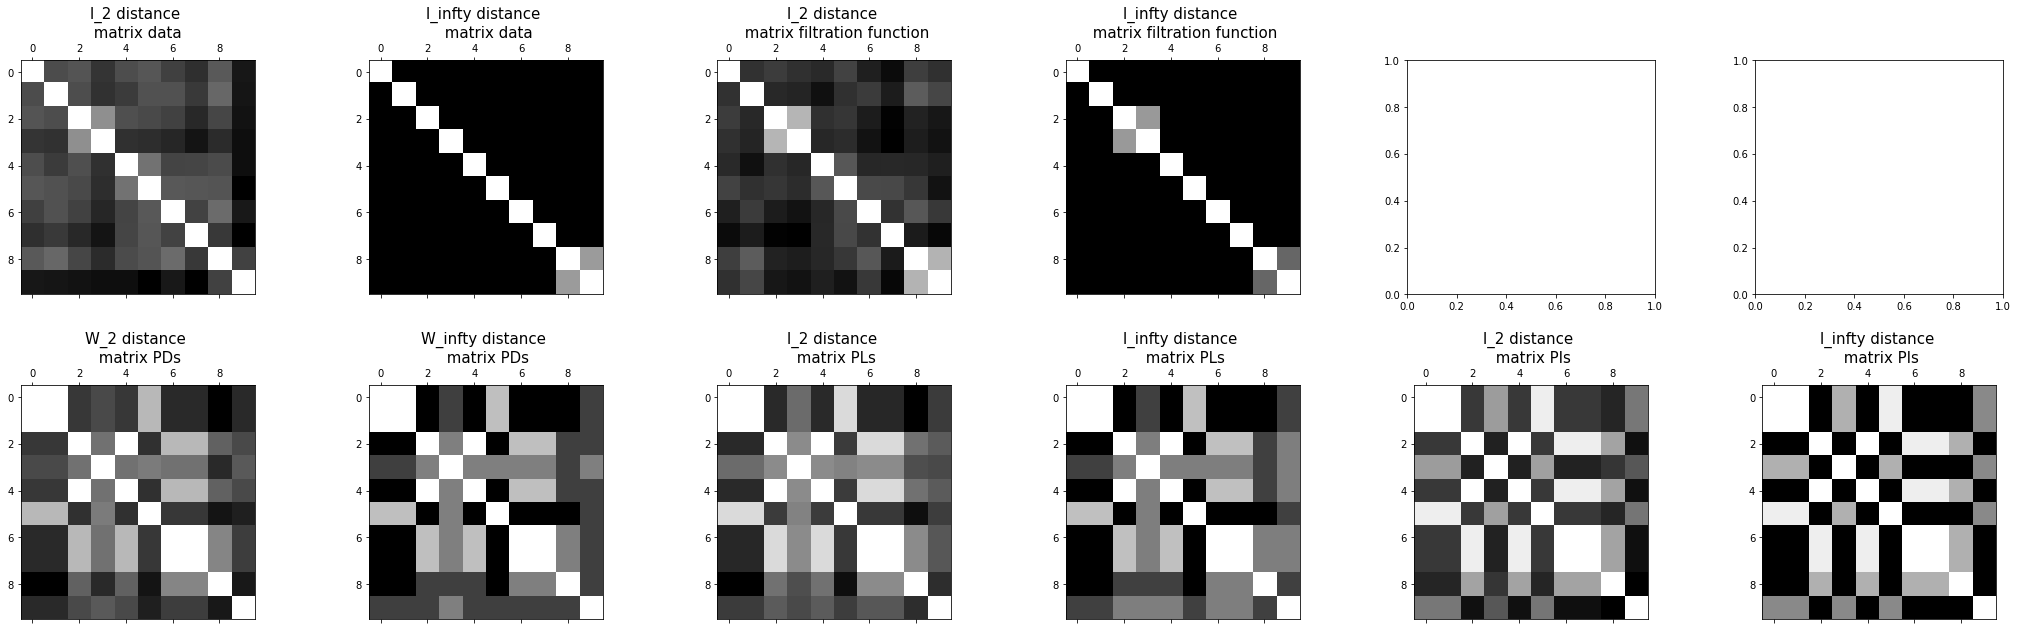

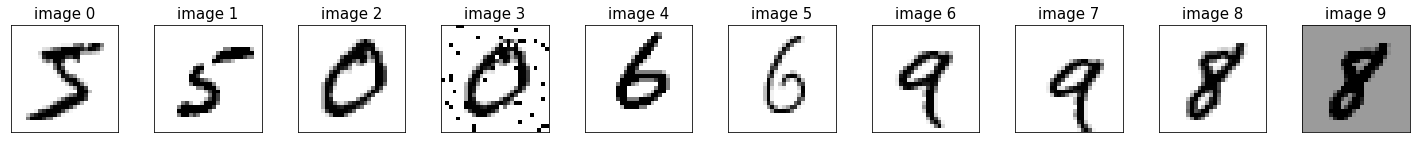

In [24]:
# Auxilary cell to visualize the persistent homology information across signatures, 
# for some filtration and homological dimension, 
# and to guide the choice of parameters for filtrations and persistence signatures in the cells above
# (based on the trade off between noise robustness and discriminative power across classes).

# In this cell, we thus plot a figure similar to (RQ1) in the manuscript, but with the exception that we do not only look
# at the filtration function and persistent homology information for an image and its noisy variant,
# but rather compare this against an image from another class (and its noisy variants).
# We also look at the Wasserstein or l2 distances between these data points.

# Choose interesting example data points, noisy versions of the same image, different examples from the same class,
# and different classes.
example_1 = 0
example_2 = 47 #
example_3 = 1
example_4 = 1 # salt and pepper noise
example_5 = 66 
example_6 = 18
example_7 = 4
example_8 = 4 # translation 
example_9 = 17
example_10 = 17 # brightness

data_point_1 = np.copy(data[example_1])
data_point_2 = np.copy(data[example_2]) # 47
data_point_3 = np.copy(data[example_3])
data_point_4 = np.copy(data_trnsf["salt and pepper noise 10"][example_4])
data_point_5 = np.copy(data[example_5]) # 66
data_point_6 = np.copy(data[example_6])
data_point_7 = np.copy(data[example_7])
data_point_8 = np.copy(data_trnsf["translation -2 -2"][example_8])
data_point_9 = np.copy(data[example_9])
data_point_10 = np.copy(data_trnsf["brightness 100"][example_10])
data_temp = np.asarray([data_point_1, data_point_2, data_point_3, data_point_4, data_point_5, data_point_6, data_point_7, 
                        data_point_8, data_point_9, data_point_10])

# Choose filtration function.
filt = "density"

filt_func_vals_1 = np.copy(data_filt_trnsf[filt, "no noise"][example_1])
filt_func_vals_2 = np.copy(data_filt_trnsf[filt, "no noise"][example_2])
filt_func_vals_3 = np.copy(data_filt_trnsf[filt, "no noise"][example_3])
filt_func_vals_4 = np.copy(data_filt_trnsf[filt, "salt and pepper noise 10"][example_4])
filt_func_vals_5 = np.copy(data_filt_trnsf[filt, "no noise"][example_5])
filt_func_vals_6 = np.copy(data_filt_trnsf[filt, "no noise"][example_6])
filt_func_vals_7 = np.copy(data_filt_trnsf[filt, "no noise"][example_7])
filt_func_vals_8 = np.copy(data_filt_trnsf[filt, "translation -2 -2"][example_8])
filt_func_vals_9 = np.copy(data_filt_trnsf[filt, "no noise"][example_9])
filt_func_vals_10 = np.copy(data_filt_trnsf[filt, "brightness 100"][example_10])
filt_func_vals_temp = [filt_func_vals_1, filt_func_vals_2, filt_func_vals_3, filt_func_vals_4, 
                       filt_func_vals_5, filt_func_vals_6, filt_func_vals_7, filt_func_vals_8,
                       filt_func_vals_9, filt_func_vals_10]

# Choose homological dimension.
homdim = "1-dim"

# Calculate PDs.
PD_1 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_1])
PD_2 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_2])
PD_3 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_3])
PD_4 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "salt and pepper noise 10"][example_4])
PD_5 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_5])
PD_6 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_6])
PD_7 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_7])
PD_8 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "translation -2 -2"][example_8])
PD_9 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "no noise"][example_9])
PD_10 = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, "brightness 100"][example_10])
PDs_temp = [PD_1, PD_2, PD_3, PD_4, PD_5, PD_6, PD_7, PD_8, PD_9, PD_10]     

# Calculate PLs.
PL_1 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_1])
PL_2 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_2])
PL_3 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_3])
PL_4 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "salt and pepper noise 10"][example_4])
PL_5 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_5])
PL_6 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_6])
PL_7 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_7])
PL_8 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "translation -2 -2"][example_8])
PL_9 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "no noise"][example_9])
PL_10 = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, "brightness 100"][example_10])
PLs_temp = [PL_1, PL_2, PL_3, PL_4, PL_5, PL_6, PL_7, PL_8, PL_9, PL_10]

# Calculate PIs.
PI_1 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_1])
PI_2 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_2])
PI_3 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_3])
PI_4 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "salt and pepper noise 10"][example_4])
PI_5 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_5])
PI_6 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_6])
PI_7 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_7])
PI_8 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "translation -2 -2"][example_8])
PI_9 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "no noise"][example_9])
PI_10 = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, "brightness 100"][example_10])
PIs_temp = [PI_1, PI_2, PI_3, PI_4, PI_5, PI_6, PI_7, PI_8, PI_9, PI_10]

# Plot images, PDs, PLs and PIs.
num_fig_rows = 5
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = min_data, vmax = max_data, axes = axes[0, column])
    axes[0, column].set_title("image %d" %column, fontsize = 15)
    # Filtration function values.
    filt_func_vals = np.copy(filt_func_vals_temp[column])
    filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
    plot_image(filt_func_vals, vmin = 0, vmax = max_data_filt[filt], axes = axes[1, column]) 
    axes[1, column].set_title(filt + " filtration \n function", fontsize = 15)
    # PD.
    PD = np.copy(PDs_temp[column])
    plot_PD(PD, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[2, column]) 
    axes[2, column].set_title("PD", fontsize = 15) 
    # PL.
    PL = np.copy(PLs_temp[column])
    plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[3, column])
    axes[3, column].set_title("PL", fontsize = 15)
    # PI.
    PI = np.copy(PIs_temp[column])
    plot_PI(PI, PI_resolution, vmin = 0, vmax = max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[4, column])
    axes[4, column].set_title("PI", fontsize = 15)     
plt.show()



# Identify the image with the longest/most persistent cycle.
max_PIs = 0
max_PIs_trnsf = 0
for trnsf in trnsfs:    
    for i, PI in enumerate(data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf]):
        max_PI_trnsf_i = np.max(PI)
        if max_PI_trnsf_i > max_PIs_trnsf:
            max_PIs_trnsf = max_PI_trnsf_i
            i_max = i
    if max_PIs_trnsf > max_PIs:
        max_PIs = max_PIs_trnsf
        trnsf_max = trnsf        
print("Inetermezzo: The image with the darkest pixel in a persistence image: ")
print("max_PIs = ", max_PIs, "for image", i_max, "under transformation ", trnsf_max)
print("max_data_sign_homdim_filt[PI, homdim, filt] =", max_data_sign_homdim_filt["PI", homdim, filt])

image_max = data_images_trnsf[trnsf_max][i_max]
filt_func_vals_max = data_filt_trnsf[filt, trnsf_max][i_max]
PD_max = data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf_max][i_max]
PL_max = data_sign_homdim_filt_trnsf["PL", homdim, filt, trnsf_max][i_max]
PI_max = data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf_max][i_max]

# Plot image, PD, PL and PI for the image that has the darkest pixel in a persistence image.
num_fig_rows = 1
num_fig_cols = 5
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
# Image.
plot_image(image_max, vmin = min_data, vmax = max_data, axes = axes[0])
axes[0].set_title("image %d" %column, fontsize = 15)
# Filtration function values.
filt_func_vals_max = filt_func_vals_max.reshape((num_x_pixels, num_y_pixels))
plot_image(filt_func_vals_max, vmin = 0, vmax = max_data_filt[filt], axes = axes[1]) 
axes[1].set_title(filt + " filtration \n function", fontsize = 15)
# PD.
plot_PD(PD_max, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[2]) 
axes[2].set_title("PD", fontsize = 15) 
# PL.
plot_PL(PL_max, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[3])
axes[3].set_title("PL", fontsize = 15)
# PI.
plot_PI(PI_max, PI_resolution, vmin = 0, vmax = max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[4])
axes[4].set_title("PI", fontsize = 15)     
plt.show()



# Calculate distances between original data representations.
l_2_distance_matrix_data_temp = l_p_distance_matrix(data_temp, p = 2)
l_infty_distance_matrix_data_temp = l_p_distance_matrix(data_temp, p = np.inf)
# print("l_2_distance_matrix_data_temp = \n", np.around(l_2_distance_matrix_data_temp, 2))
# print("l_infty_distance_matrix_data_temp = \n", np.around(l_infty_distance_matrix_data_temp, 2))
# print()

# Calculate distances between filtration functions.
l_2_distance_matrix_filt_func_vals_temp = l_p_distance_matrix(filt_func_vals_temp, p = 2)
l_infty_distance_matrix_filt_func_vals_temp = l_p_distance_matrix(filt_func_vals_temp, p = np.inf)
# print("l_2_distance_matrix_filt_func_vals_temp = \n", np.around(l_2_distance_matrix_filt_func_vals_data_temp, 2))
# print("l_infty_distance_matrix_filt_func_vals_temp = \n", np.around(l_infty_distance_matrix_filt_func_vals_data_temp, 2))
# print()

# Calculate distances between PDs.
W_2_distance_matrix_PDs_temp = wasserstein_p_q_distance_matrix(PDs_temp, p = 2, q = np.inf)
W_infty_distance_matrix_PDs_temp = wasserstein_p_q_distance_matrix(PDs_temp, p = np.inf, q = np.inf)
# print("W_2_distance_matrix_PDs_temp = \n", np.around(W_2_distance_matrix_PDS_temp, 2))
# print("W_infty_distance_matrix_PDs_temp = \n", np.around(W_infty_distance_matrix_PDs_temp, 2))
# print()

# Calculate distances between PLs.
l_2_distance_matrix_PLs_temp = l_p_distance_matrix(PLs_temp, p = 2)
l_infty_distance_matrix_PLs_temp = l_p_distance_matrix(PLs_temp, p = np.inf)
# print("l_2_distance_matrix_PLs_temp = \n", np.around(l_2_distance_matrix_PLs_temp, 2))
# print("l_infty_distance_matrix_PLs_temp = \n", np.around(l_infty_distance_matrix_PLs_temp, 2))
# print()

# Calculate distances between PIs.
l_2_distance_matrix_PIs_temp = l_p_distance_matrix(PIs_temp, p = 2)
l_infty_distance_matrix_PIs_temp = l_p_distance_matrix(PIs_temp, p = np.inf)
# print("l_2_distance_matrix_data_PIs_temp = \n", np.around(l_2_distance_matrix_PIs_temp, 2))
# print("l_infty_distance_matrix_PIs_temp = \n", np.around(l_infty_distance_matrix_PIs_temp, 2))
# print()

# Plot distance matrices.
num_fig_rows = 2
num_fig_cols = 6
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 7.0) 
# Images.
axes[0, 0].matshow(l_2_distance_matrix_data_temp, cmap = plt.cm.gray_r)
axes[0, 0].set_title("l_2 distance \n matrix data ", fontsize = 15)  
axes[0, 1].matshow(l_infty_distance_matrix_data_temp, cmap = plt.cm.gray_r)
axes[0, 1].set_title("l_infty distance \n matrix data", fontsize = 15)  
# Filtration functions. 
axes[0, 2].matshow(l_2_distance_matrix_filt_func_vals_temp, cmap = plt.cm.gray_r)
axes[0, 2].set_title("l_2 distance \n matrix filtration function", fontsize = 15)  
axes[0, 3].matshow(l_infty_distance_matrix_filt_func_vals_temp, cmap = plt.cm.gray_r)
axes[0, 3].set_title("l_infty distance \n matrix filtration function", fontsize = 15)  
# PDs.
axes[1, 0].matshow(W_2_distance_matrix_PDs_temp, cmap = plt.cm.gray_r)
axes[1, 0].set_title("W_2 distance \n matrix PDs", fontsize = 15)  
axes[1, 1].matshow(W_infty_distance_matrix_PDs_temp, cmap = plt.cm.gray_r)
axes[1, 1].set_title("W_infty distance \n matrix PDs", fontsize = 15)  
# PLs.
axes[1, 2].matshow(l_2_distance_matrix_PLs_temp, cmap = plt.cm.gray_r)
axes[1, 2].set_title("l_2 distance \n matrix PLs", fontsize = 15)  
axes[1, 3].matshow(l_infty_distance_matrix_PLs_temp, cmap = plt.cm.gray_r)
axes[1, 3].set_title("l_infty distance \n matrix PLs", fontsize = 15)  
# PIs.
axes[1, 4].matshow(l_2_distance_matrix_PIs_temp, cmap = plt.cm.gray_r)
axes[1, 4].set_title("l_2 distance \n matrix PIs", fontsize = 15)  
axes[1, 5].matshow(l_infty_distance_matrix_PIs_temp, cmap = plt.cm.gray_r)
axes[1, 5].set_title("l_infty distance \n matrix PIs", fontsize = 15)  

print("Distance matrices should have pretty white 2x2 pixel patches around the diagonal, d(non-noisy, noisy), for noise robustness;")
print("and dark pixels outside, d(one class, other class), for discriminative power. \n")
print()
print("Distances between images in the same class (0 for images 1 and 2, 6 for images 3 and 4, 9 for images 5 and 6)")
print("are more reasonable for persistent homology than original image representation as greyscale pixel values")
print("(note the small bright squares around the diagonal in Wasserstein distance matrices)! \n")
print()
print("Consider also if distance matrices between PDs, PLs, PIs reflect each other.")

# Plot images once again to better interpret the distance matrices.
num_fig_rows = 1
num_fig_cols = data_temp.shape[0]
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.5) 
for column, data_point in enumerate(data_temp):
    # Image.
    image = np.copy(data_temp[column])
    image = image.reshape((num_x_pixels, num_y_pixels))
    plot_image(image, vmin = min_data, vmax = max_data, axes = axes[column])
    axes[column].set_title("image %d" %column, fontsize = 15)

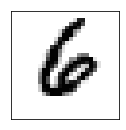

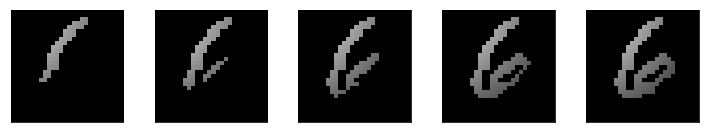

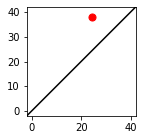

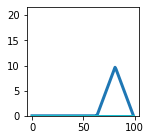

In [25]:
# Auxliary cell to visualize the persistent homology pipeline for an image 
# (Figure 1 in turkevs2021noise, top).
example = 13
subfig_height = 2
subfig_width = 2

# Image.
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_image(data_images[example], vmin = min_data, vmax = max_data, axes = axes)
fig.savefig("FIGURES/pipeline_image")

# Filtration (radial).
filt_func_vals_percentages = np.asarray([0.5, 0.55, 0.6, 0.65, 0.7])
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(1, num_fig_cols, figsize = (num_fig_cols * subfig_width, subfig_height)) 
fig.tight_layout(pad = 0.05)
filt_func_vals = np.copy(data_filt_trnsf["radial", "no noise"][example])
filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels)) 
max_filt_func_val = max_data_filt["radial"]
for p, perc in enumerate(filt_func_vals_percentages):
    cubical_complex = np.zeros((num_x_pixels, num_y_pixels)) + max_filt_func_val
    filt_val_upper_limit = perc * max_filt_func_val
    for i in range(num_x_pixels):
        for j in range(num_y_pixels):
            if(filt_func_vals[i, j] < filt_val_upper_limit):
                cubical_complex[i, j] = filt_func_vals[i, j]      
    plot_image(cubical_complex, vmin = 0, vmax = max_data_filt["radial"], axes = axes[p])
fig.savefig("FIGURES/pipeline_image_filtration")

# PD.
PD = data_sign_homdim_filt_trnsf["PD", "1-dim", "radial", "no noise"][example]
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PD(PD, xymax = max_death_PDs_homdim_filt["1-dim", "radial"], axes = axes)
fig.savefig("FIGURES/pipeline_image_PD")

# PL.
PL = data_sign_homdim_filt_trnsf["PL", "1-dim", "radial", "no noise"][example]
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, ymax = max_data_sign_homdim_filt["PL", "1-dim", "radial"], axes = axes)
fig.savefig("FIGURES/pipeline_image_PL")

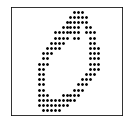

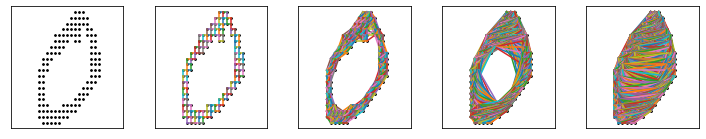

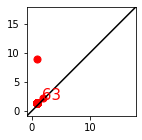

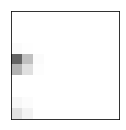

In [26]:
# Auxliary cell to visualize the persistent homology pipeline for a point cloud 
# (Figure 1 in turkevs2021noise, bottom).
example = 1 # 0
subfig_height = 2
subfig_width = 2

# Point cloud.
point_cloud = build_point_cloud(data[example], 0.5)
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
axes.scatter(point_cloud[:, 0], point_cloud[:, 1], c = "black", s = 3)
axes.set_xlim(0, num_x_pixels)
axes.set_xlim(0, num_y_pixels)
axes.set_xticks([])
axes.set_yticks([])
axes.set_xticklabels([])
axes.set_yticklabels([])
fig.savefig("FIGURES/pipeline_point_cloud")

# Filtration (Rips).
filt_func_vals = point_cloud
filt_func_vals_percentages = np.asarray([0.01, 0.03, 0.07, 0.2, 0.3])
num_fig_cols = len(filt_func_vals_percentages)
fig, axes = plt.subplots(1, num_fig_cols, figsize = (num_fig_cols * subfig_width, subfig_height)) 
fig.tight_layout(pad = 0.05)
for p, perc in enumerate(filt_func_vals_percentages):
    axes[p].scatter(filt_func_vals[:, 0], filt_func_vals[:, 1], c = "black", s = 3) 
    axes[p].set_xlim(0, num_x_pixels)
    axes[p].set_xlim(0, num_y_pixels)
    axes[p].set_xticks([])
    axes[p].set_yticks([])
    axes[p].set_xticklabels([])
    axes[p].set_yticklabels([])
    max_filt_func_val = np.sqrt(num_x_pixels**2 + num_y_pixels**2) # maximum possible edge lenght for rips
    filt_val_upper_limit = perc * max_filt_func_val
    simplicial_complex = gd.RipsComplex(points = filt_func_vals, max_edge_length = rips_max_edge_length)
    simplex_tree = simplicial_complex.create_simplex_tree(max_dimension = 2)         
    for simplex_filt in simplex_tree.get_skeleton(1):
        simplex = simplex_filt[0]
        filt = simplex_filt[1]
        if len(simplex) == 2 and filt <= filt_val_upper_limit:
            vertex_1_num = simplex[0]
            vertex_2_num = simplex[1]
            vertex_1_x_y_coords = filt_func_vals[vertex_1_num]
            vertex_2_x_y_coords = filt_func_vals[vertex_2_num]
            edge_x_vals = [vertex_1_x_y_coords[0], vertex_2_x_y_coords[0]]
            edge_y_vals = [vertex_1_x_y_coords[1], vertex_2_x_y_coords[1]]
            axes[p].plot(edge_x_vals, edge_y_vals)  
fig.savefig("FIGURES/pipeline_point_cloud_filtration")

# PD.
PD = data_sign_homdim_filt_trnsf["PD", "1-dim", "Rips", "no noise"][example]
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height)) 
plot_PD(PD, xymax = max_death_PDs_homdim_filt["1-dim", "Rips"], axes = axes)
fig.savefig("FIGURES/pipeline_point_cloud_PD")

# PI.
PI = data_sign_homdim_filt_trnsf["PI", "1-dim", "Rips", "no noise"][example]
fig, axes = plt.subplots(1, 1, figsize = (subfig_width, subfig_height))     
plot_PI(PI, PI_resolution, vmin = 0, vmax = 0.35 * max_data_sign_homdim_filt["PI", "1-dim", "Rips"], axes = axes)
fig.savefig("FIGURES/pipeline_point_cloud_PI")

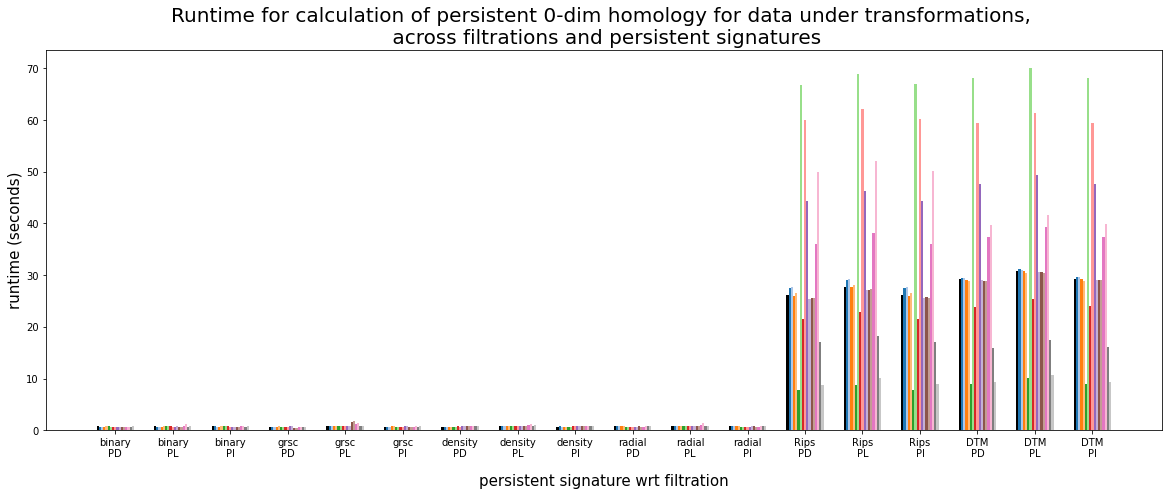

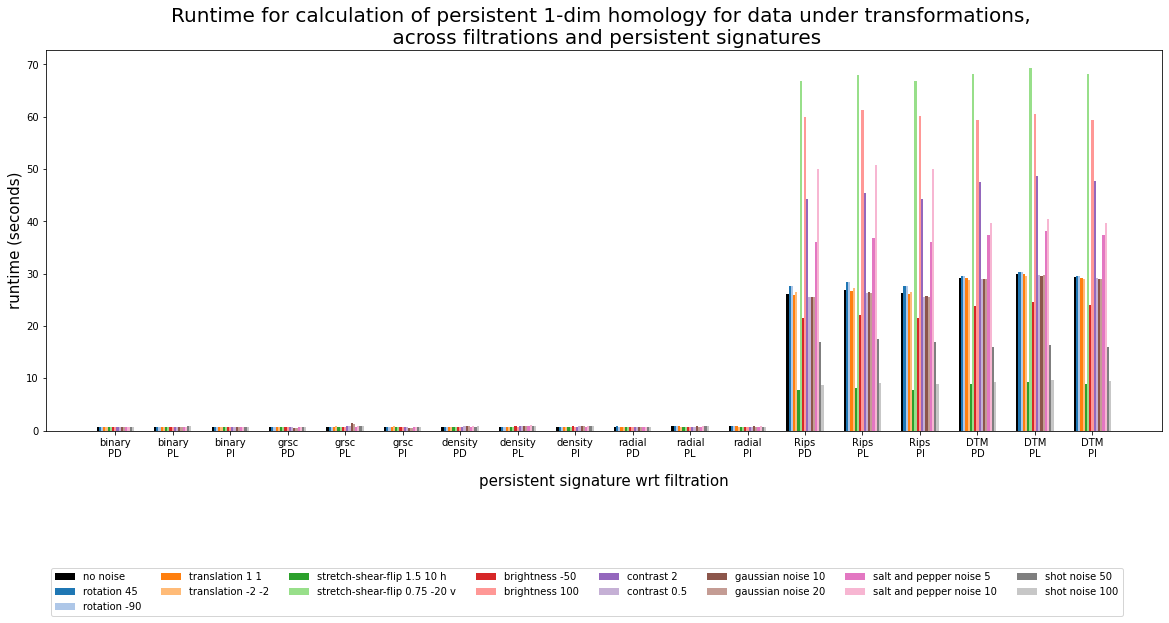

In [27]:
# How long does it take to construct persistent homology information?

# Figure 1-2 x-axis list of labels.
filts_signs = [filt + "\n" + sign for filt in filts for sign in signs]

# Figure 1: homdim0.
# Figure 1 y-axis, per different transformations (colors, or legend items), dictionary of lists.
runtime_data_homdim0_trnsfs = {}
for trnsf in trnsfs:
    runtime_data_homdim0_trnsfs[trnsf] = [np.around(runtime_data_sign_homdim_filt_trnsf[sign, "0-dim", filt, trnsf], 2)
                                          for filt in filts
                                          for sign in signs]  
fig, axes = plot_bar_containers(filts_signs, runtime_data_homdim0_trnsfs, trnsfs)
axes.set_xlabel("persistent signature wrt filtration", fontsize = 15, labelpad = 15)
axes.set_ylabel("runtime (seconds)", fontsize = 15)
# fig.savefig("FIGURES/runtime_PH_homdim0", bbox_inches = "tight")
axes.set_title("Runtime for calculation of persistent 0-dim homology for data under transformations, \n across filtrations and persistent signatures", fontsize = 20)

# Figure 2: homdim1.
# Figure 2 y-axis, per different transformations (colors, or legend items), dictionary of lists.
runtime_data_homdim1_trnsfs = {}
for trnsf in trnsfs:
    runtime_data_homdim1_trnsfs[trnsf] = [np.around(runtime_data_sign_homdim_filt_trnsf[sign, "1-dim", filt, trnsf], 2)
                                          for filt in filts
                                          for sign in signs]  
fig, axes = plot_bar_containers(filts_signs, runtime_data_homdim1_trnsfs, trnsfs)
axes.set_xlabel("persistent signature wrt filtration", fontsize = 15, labelpad = 15)
axes.set_ylabel("runtime (seconds)", fontsize = 15)
# fig.savefig("FIGURES/runtime_homdim1", bbox_inches = "tight")
axes.set_title("Runtime for calculation of persistent 1-dim homology for data under transformations, \n across filtrations and persistent signatures", fontsize = 20)

# Figure 2 legend.
legend = axes.legend(trnsfs, loc = "lower left", bbox_to_anchor=(0, -0.5), ncol = 8, fontsize = 10)
for t, line in enumerate(legend.get_lines()):
    line.set_linewidth(4.0)
    
plt.show()

## 5.2) Noise robustness  

In this section, we use the two dictionaries calculated in 5.1), data_filt_trnsf and data_sign_homdim_filt_trnsf, to gain some insights to the first research question identified in the manuscript:
> (RQ1) In what way, and to which degree, is the persistent homology information sensitive to noise, calculated with respect to different filtrations and persistent signatures?

To do so, we first visualize an example image under different transformations, represented with its filtration function values or persistent homology information. Next, we evaluate the distances between a non-noisy and noisy image, when the image is represented with its filtration function values or persistent homology information, stored in dictionaries: 
- $\color{red}{\text{dists_filt_trnsf_data_data}}$
- $\color{red}{\text{dists_sign_homdim_filt_trnsf_data_data}}$

which have as elements, e.g.,:
- dists_filt_trnsf_data_data[greyscale, rotation 1] = num_data_points x 1 array, l_p distances between the non-noisy and rotated images, represented with its filtration function values
- dists_sign_homdim_filt_trnsf_data_data[PD, 0-dim, density, rotation 1] = num_data_points x 1 array, W_p distances between the non-noosy and rotated images, represented with with its 0-dim PD (list of persistence intervals) wrt cubical density filtration
- dists_sign_homdim_filt_trnsf_data_data[PL, 0-dim, density, rotation 1] = num_data_points x 1 array, l_p distances between the non-nosi and rotated images, represented with with its 0-dim persistent landscape (a vector) wrt cubical density filtration

A table summary of these distances gives some insights into how much does a noisy image differ from the non-noisy image.

In [28]:
# Load the variables.
with open("VARIABLES/data_filt_trnsf.pkl", "rb") as f:
    data_filt_trnsf = pickle.load(f)
with open("VARIABLES/data_sign_homdim_filt_trnsf.pkl", "rb") as f:
    data_sign_homdim_filt_trnsf = pickle.load(f)

An example image, under transformations (in columns):


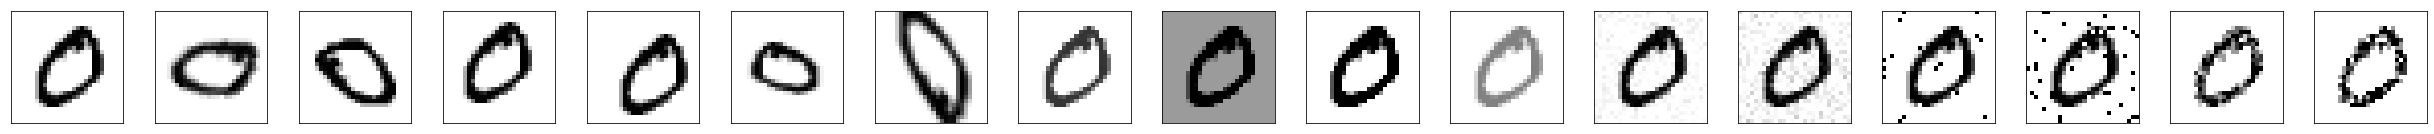

The example image, represented with its binary filtration function values, under transformations (in columns):


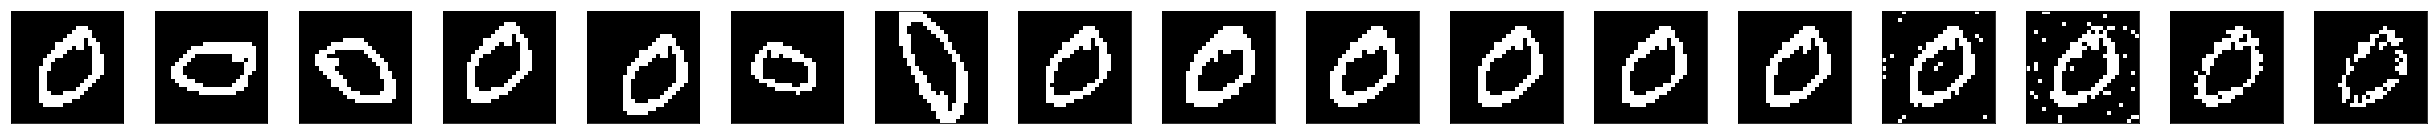

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


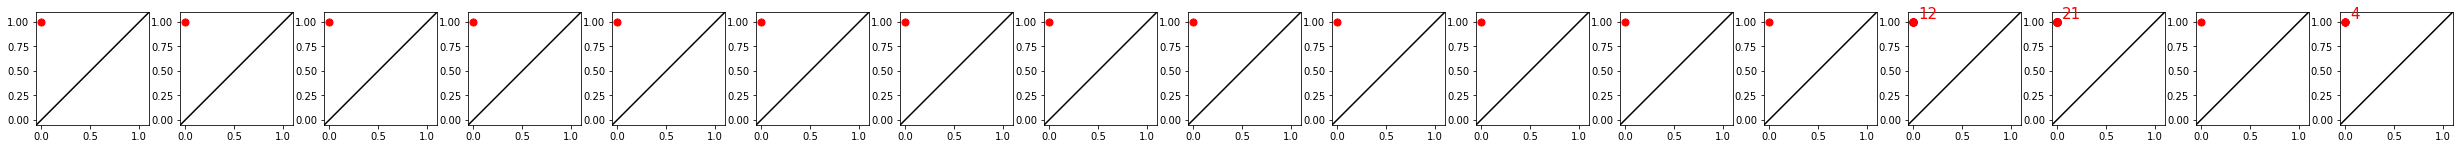

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


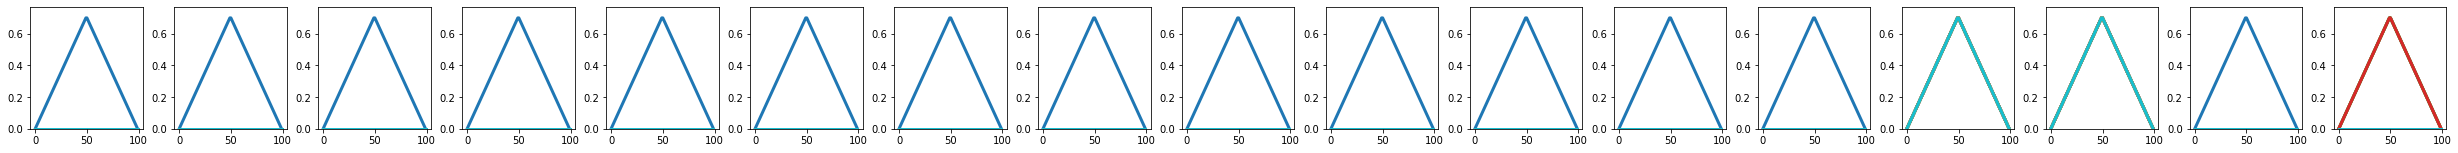

The example image, represented with  0-dim persistence images, under transformations (in columns):


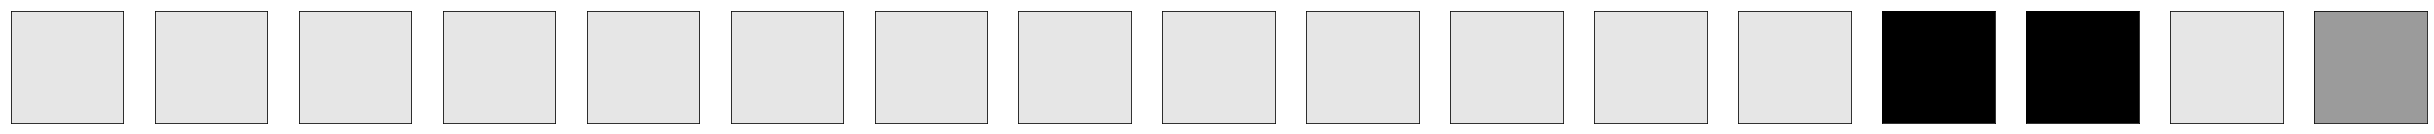

The example image, represented with its grsc filtration function values, under transformations (in columns):


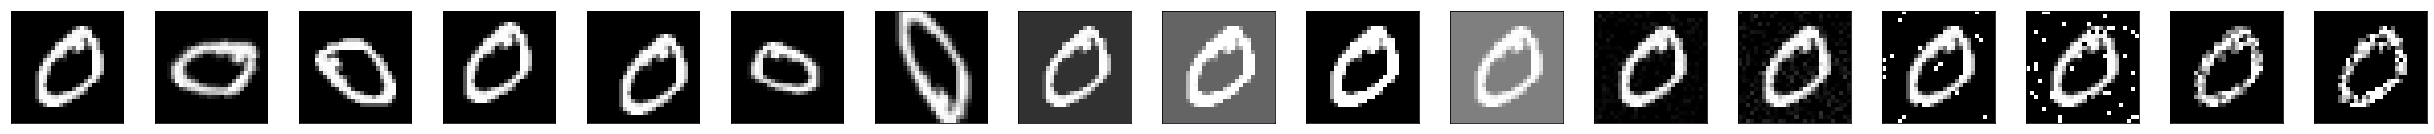

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


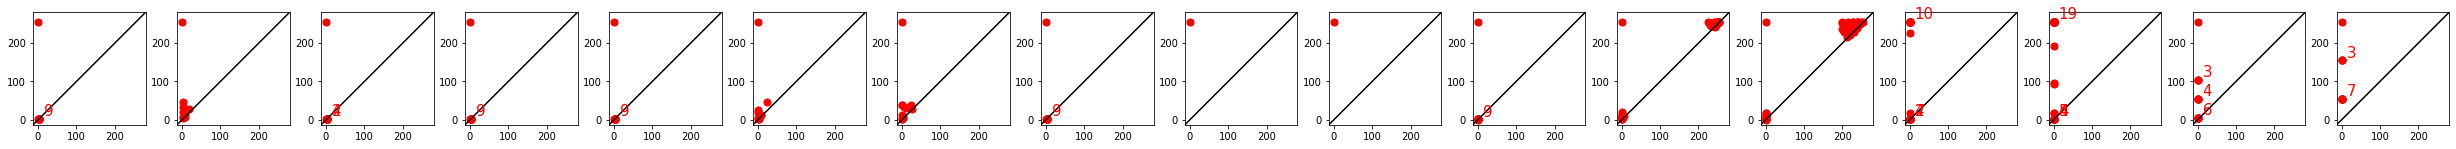

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


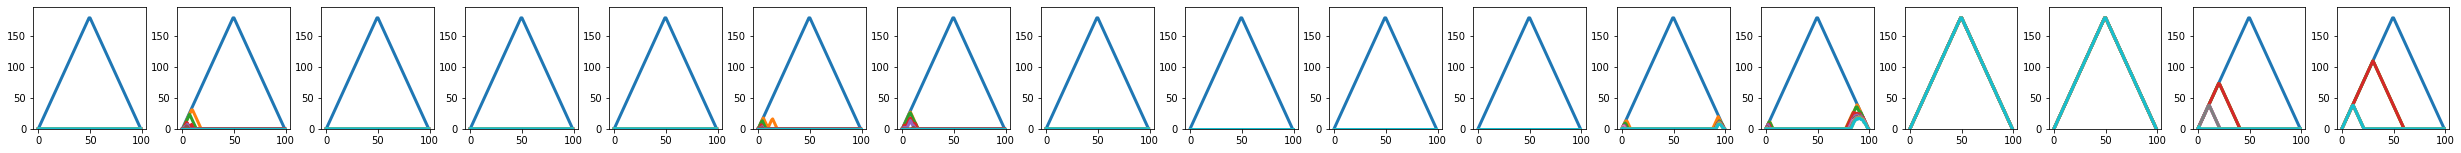

The example image, represented with  0-dim persistence images, under transformations (in columns):


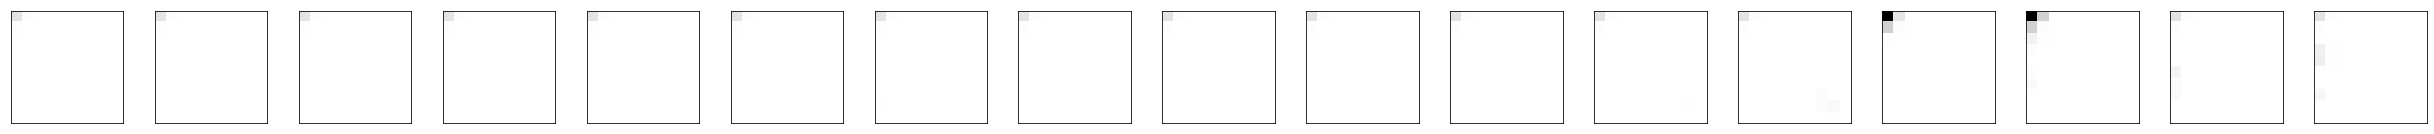

The example image, represented with its density filtration function values, under transformations (in columns):


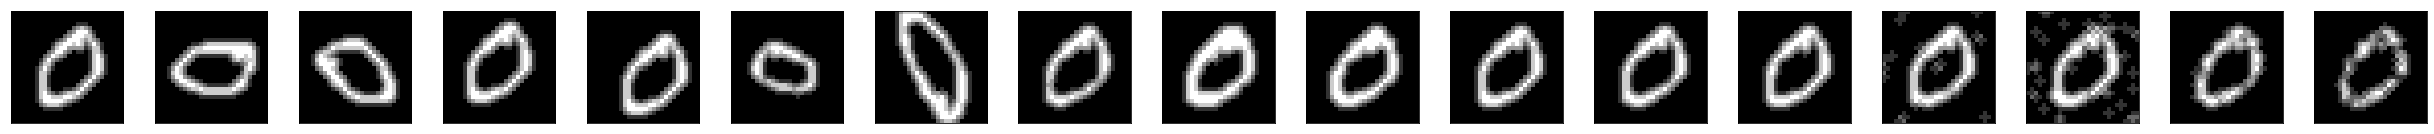

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


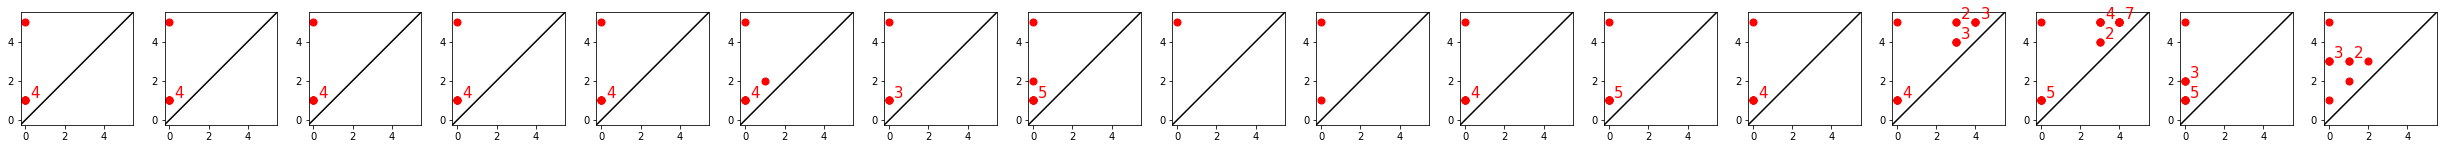

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


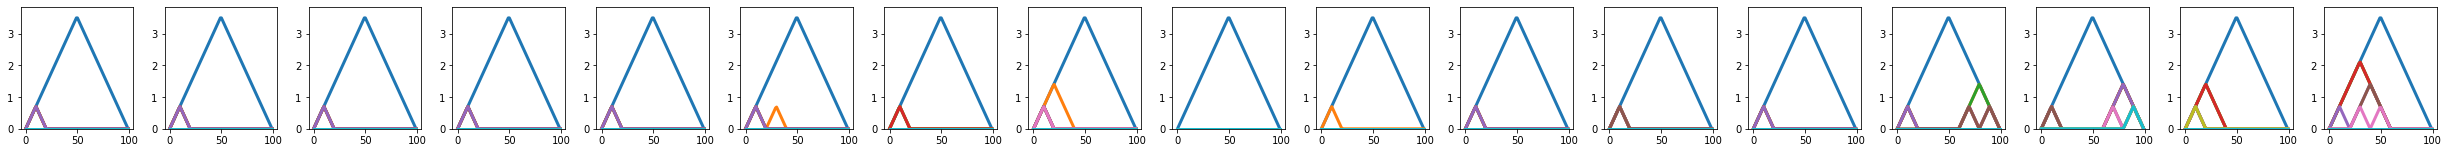

The example image, represented with  0-dim persistence images, under transformations (in columns):


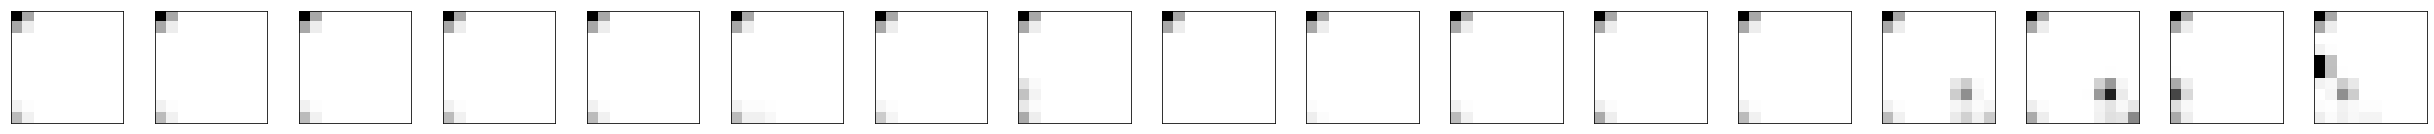

The example image, represented with its radial filtration function values, under transformations (in columns):


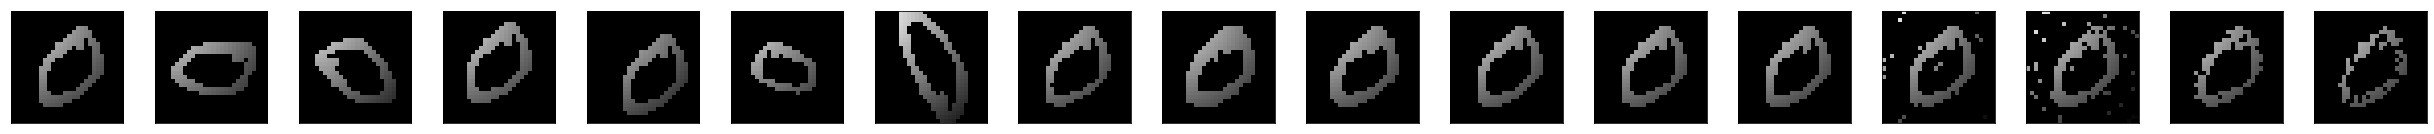

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


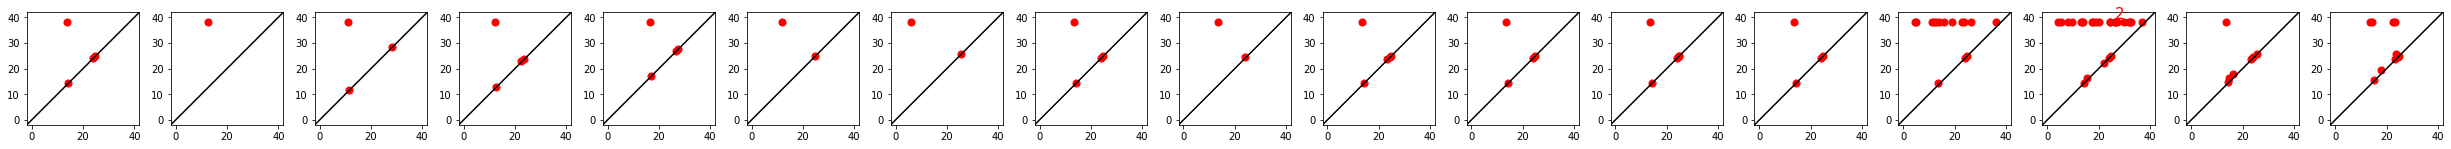

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


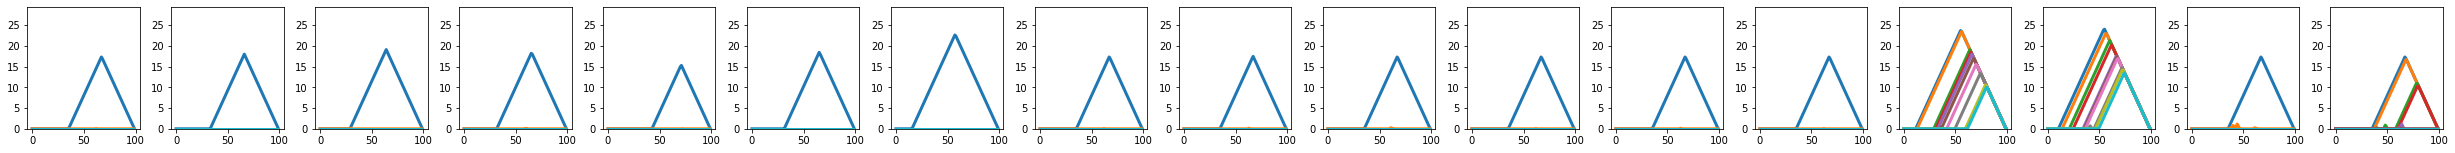

The example image, represented with  0-dim persistence images, under transformations (in columns):


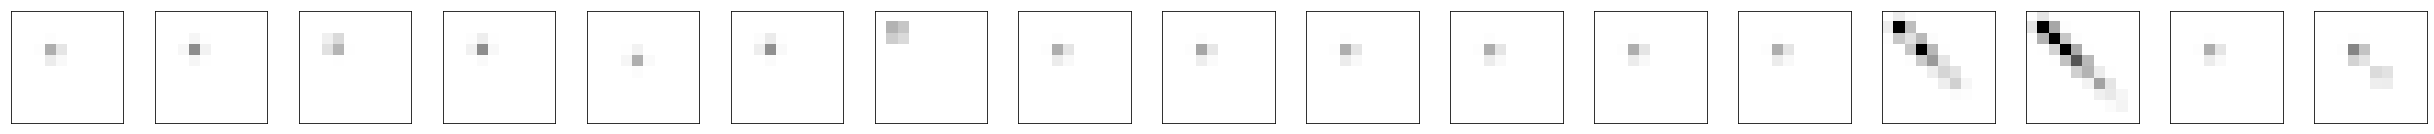

The example image, represented with its Rips filtration function values, under transformations (in columns):


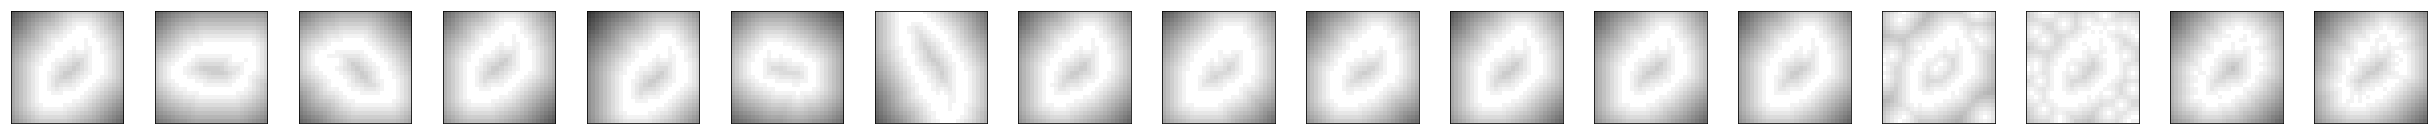

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


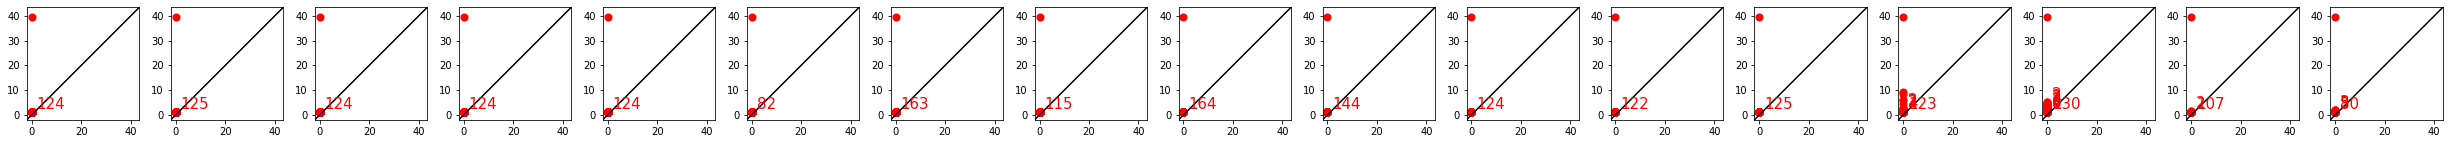

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


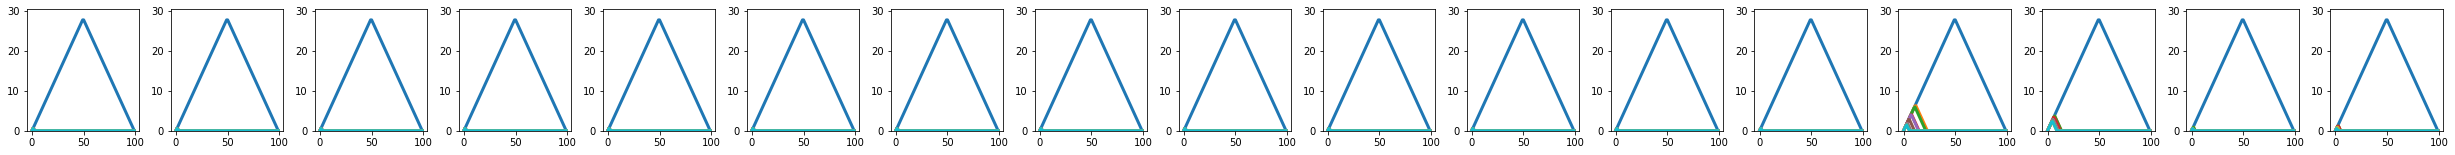

The example image, represented with  0-dim persistence images, under transformations (in columns):


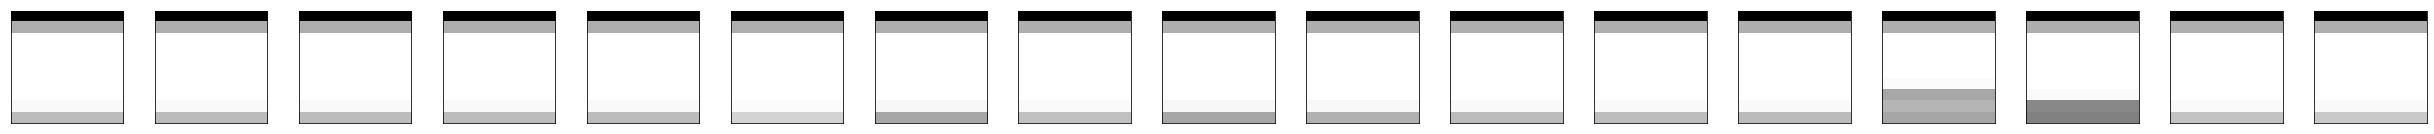

The example image, represented with its DTM filtration function values, under transformations (in columns):


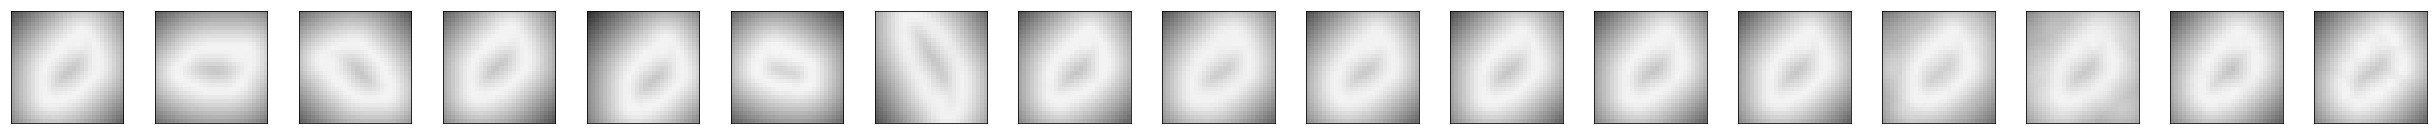

The example image, represented with its 0-dim persistence diagrams, under transformations (in columns):


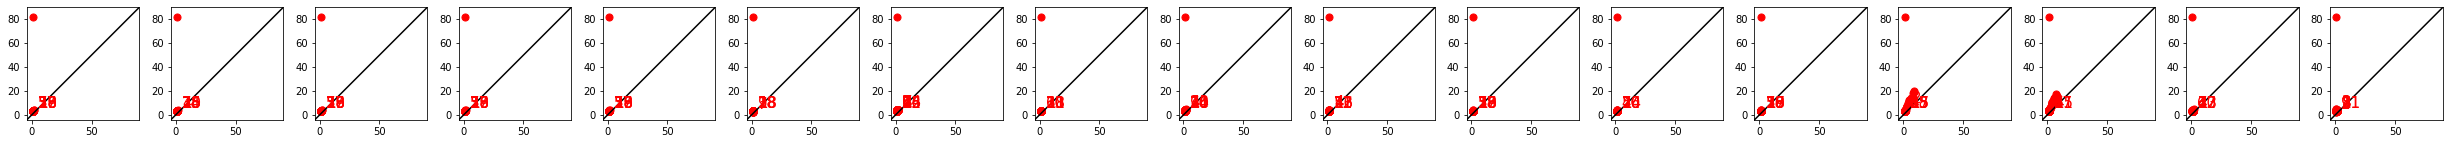

The example image, represented with its 0-dim persistence landscapes, under transformations (in columns):


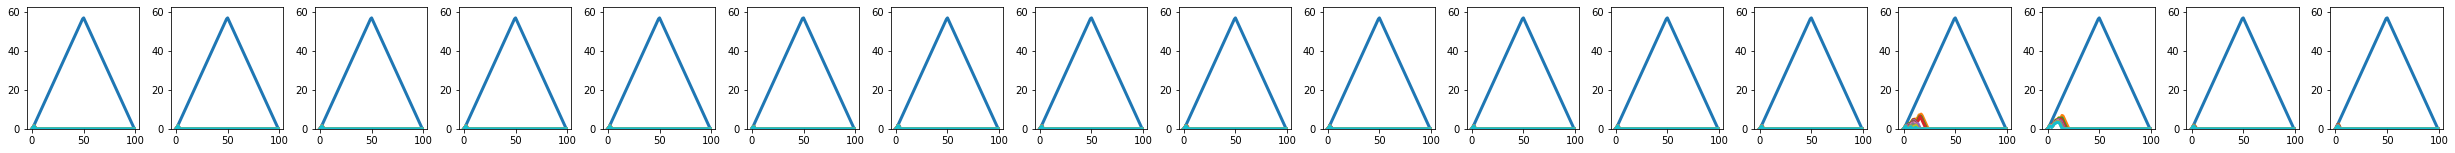

The example image, represented with  0-dim persistence images, under transformations (in columns):


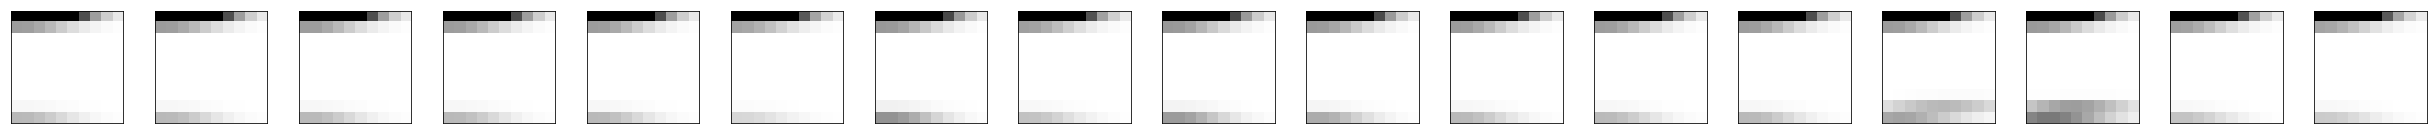

The example image, represented with its binary filtration function values, under transformations (in columns):


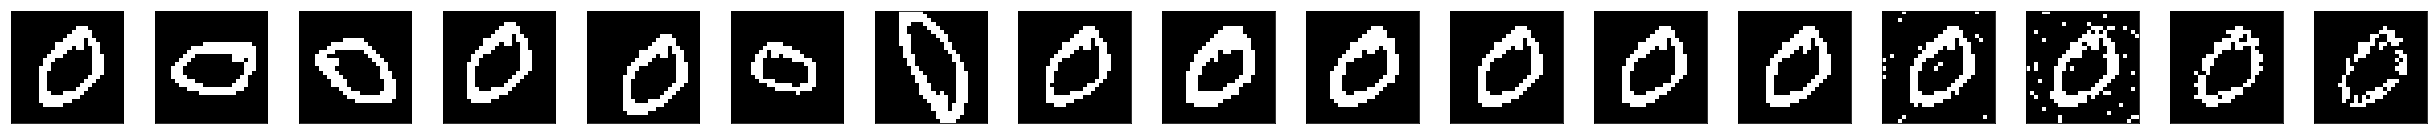

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


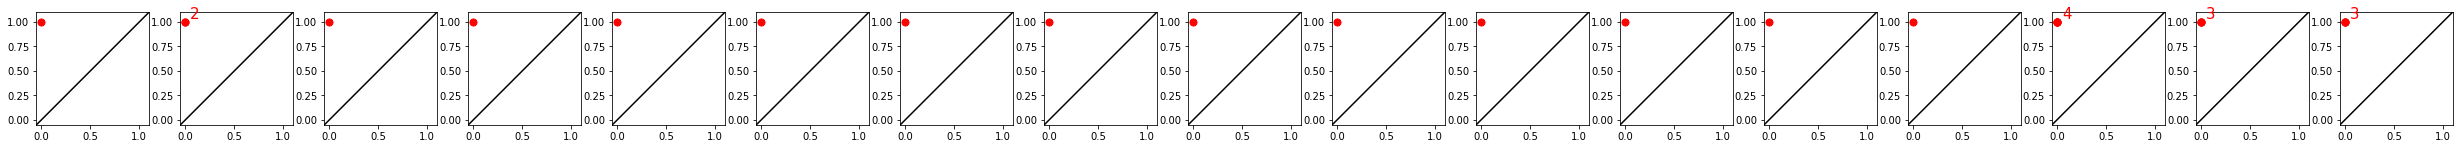

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


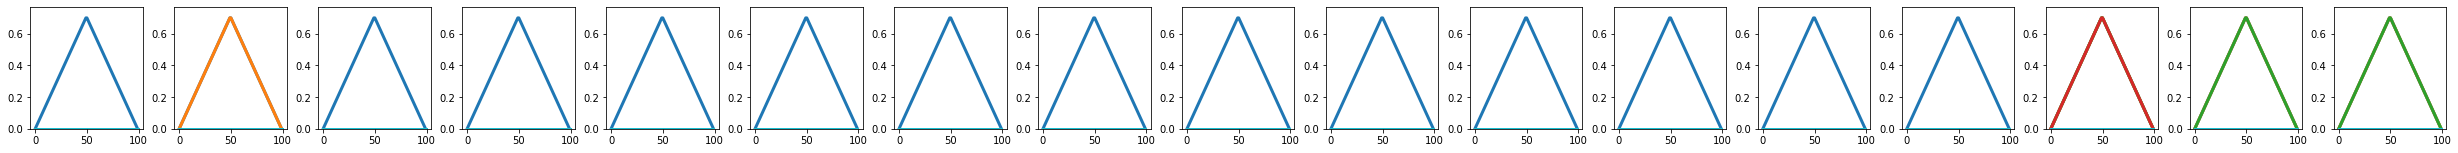

The example image, represented with  1-dim persistence images, under transformations (in columns):


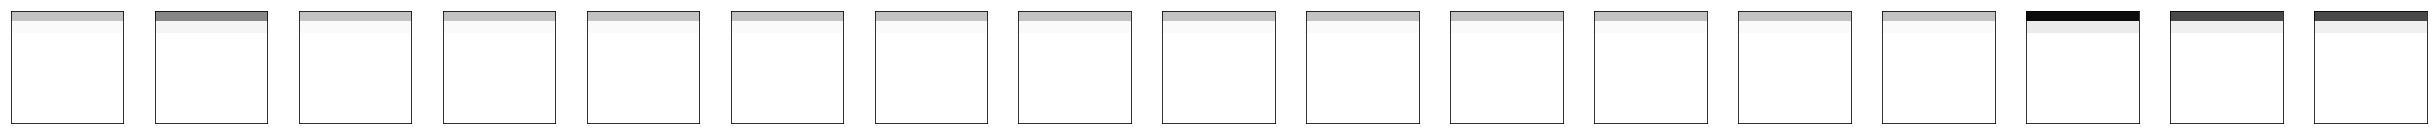

The example image, represented with its grsc filtration function values, under transformations (in columns):


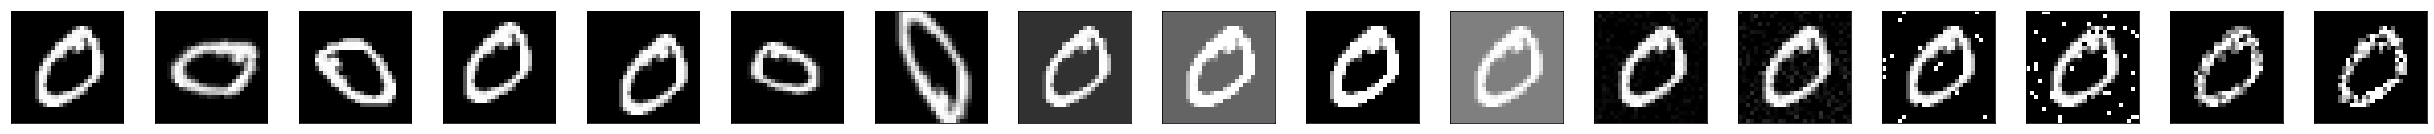

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


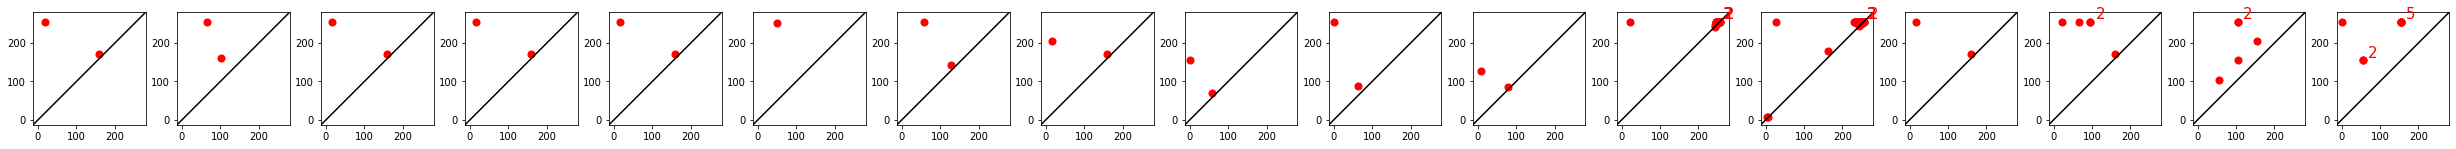

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


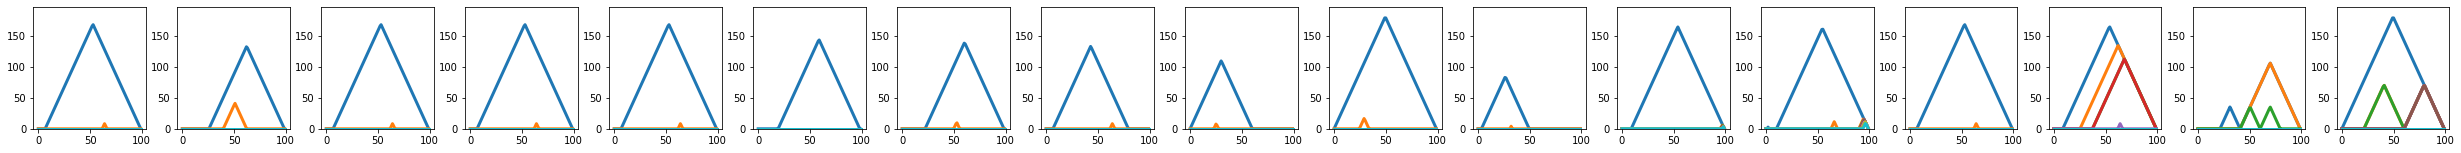

The example image, represented with  1-dim persistence images, under transformations (in columns):


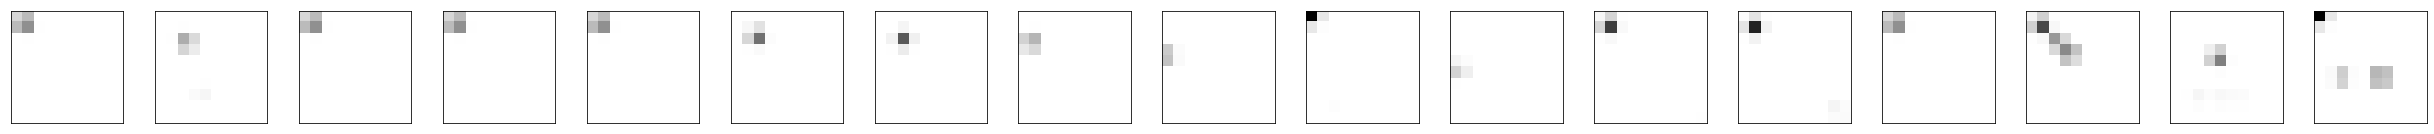

The example image, represented with its density filtration function values, under transformations (in columns):


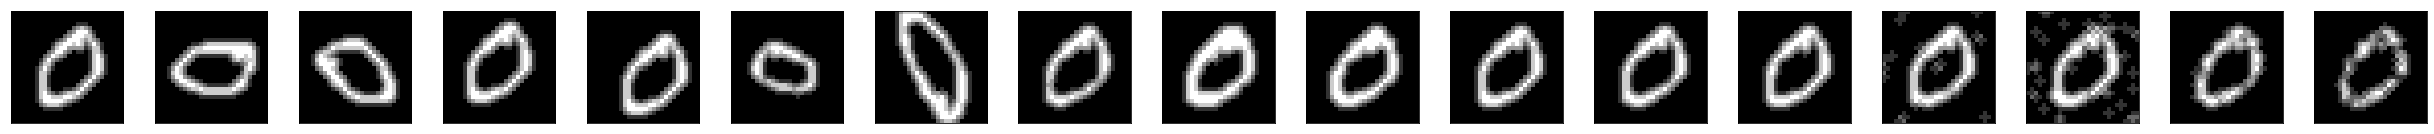

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


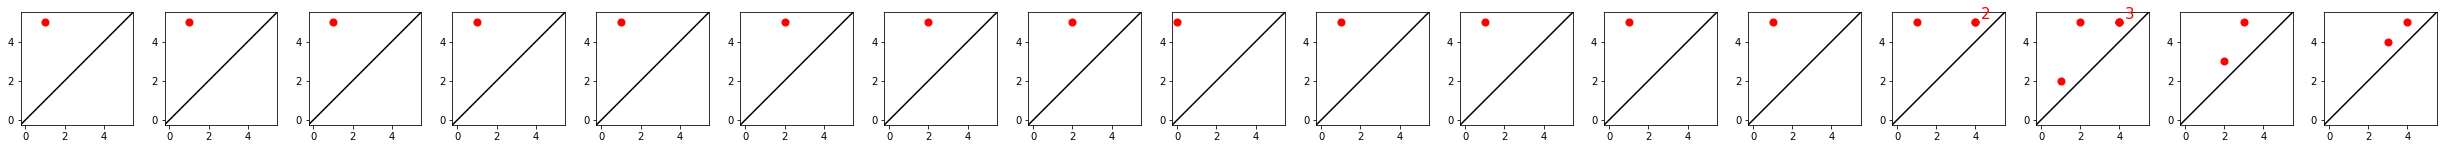

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


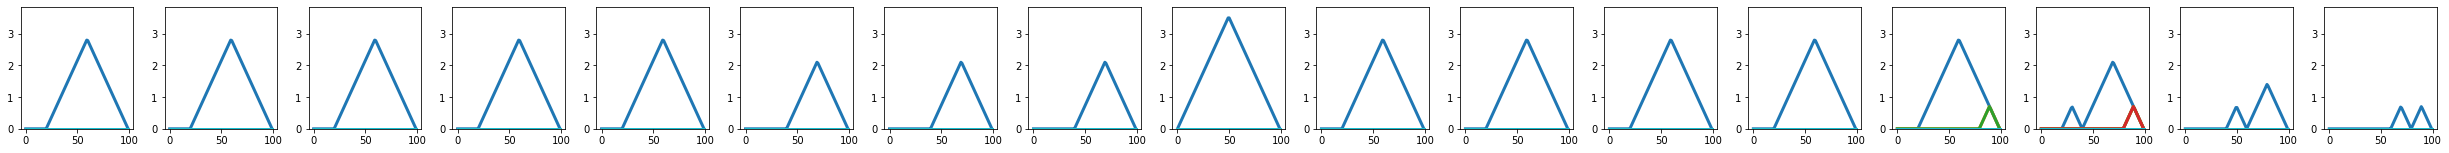

The example image, represented with  1-dim persistence images, under transformations (in columns):


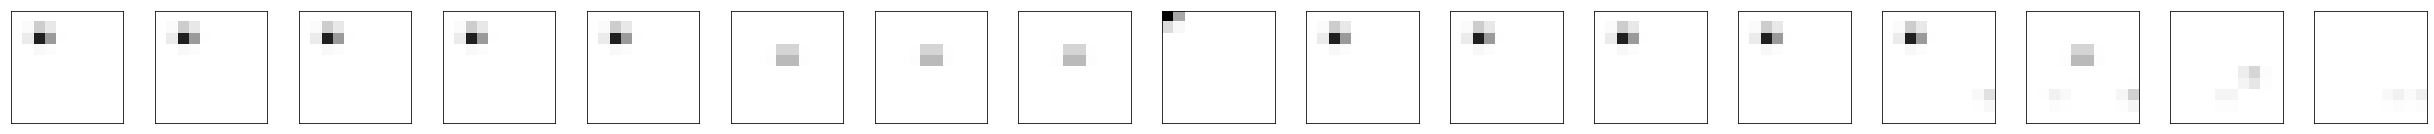

The example image, represented with its radial filtration function values, under transformations (in columns):


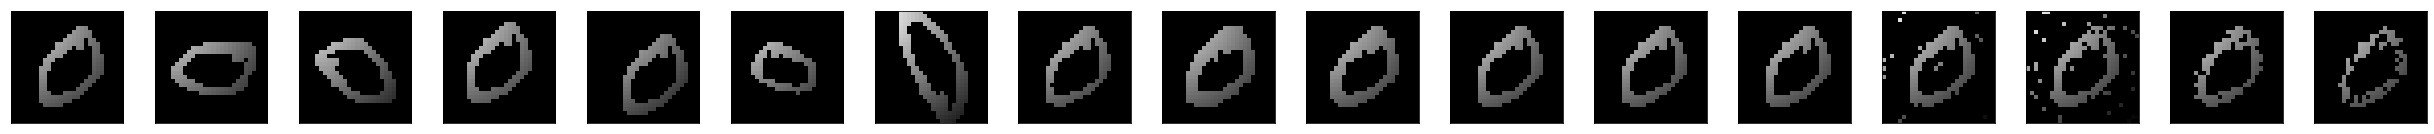

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


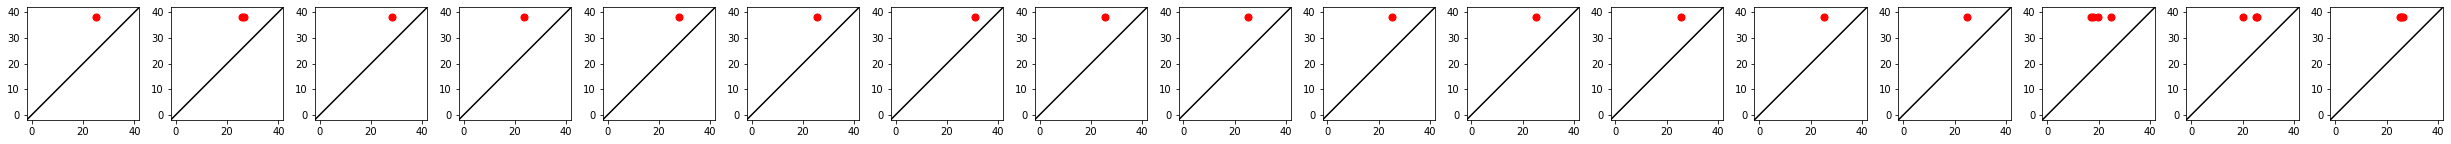

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


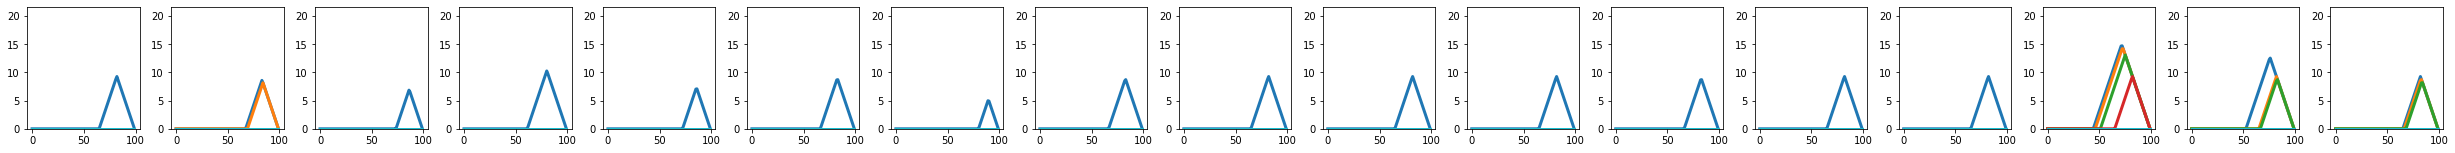

The example image, represented with  1-dim persistence images, under transformations (in columns):


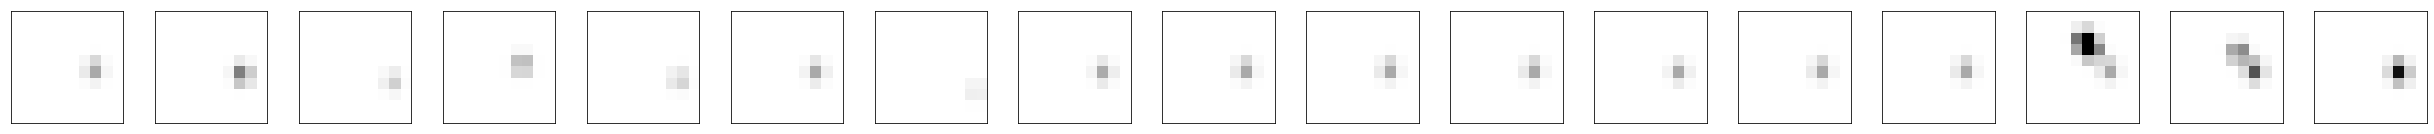

The example image, represented with its Rips filtration function values, under transformations (in columns):


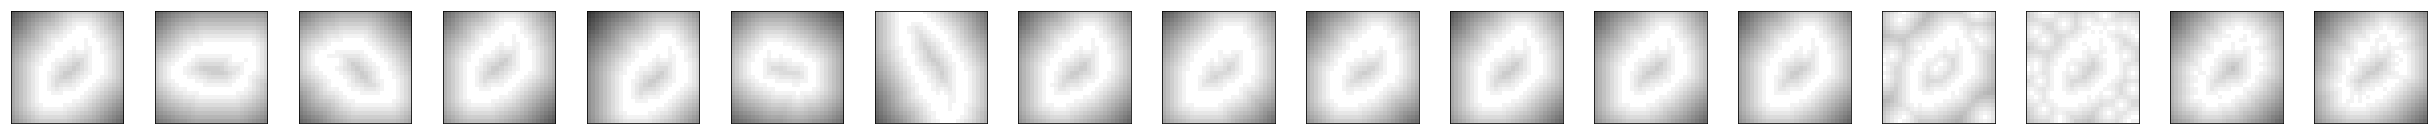

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


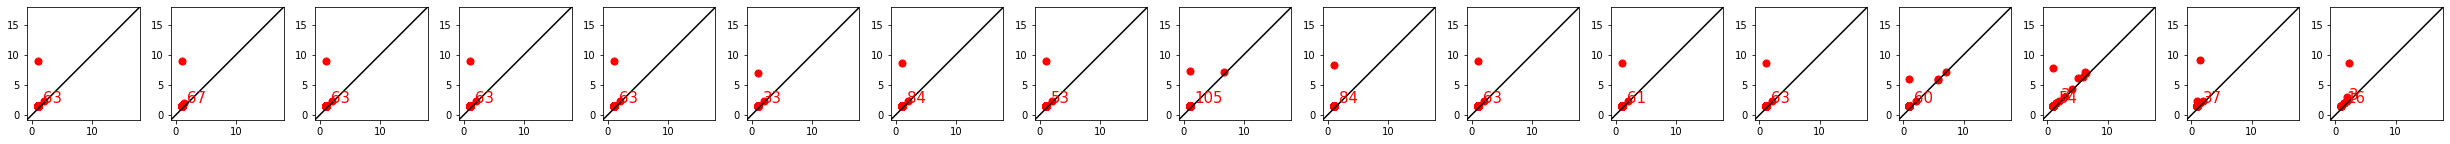

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


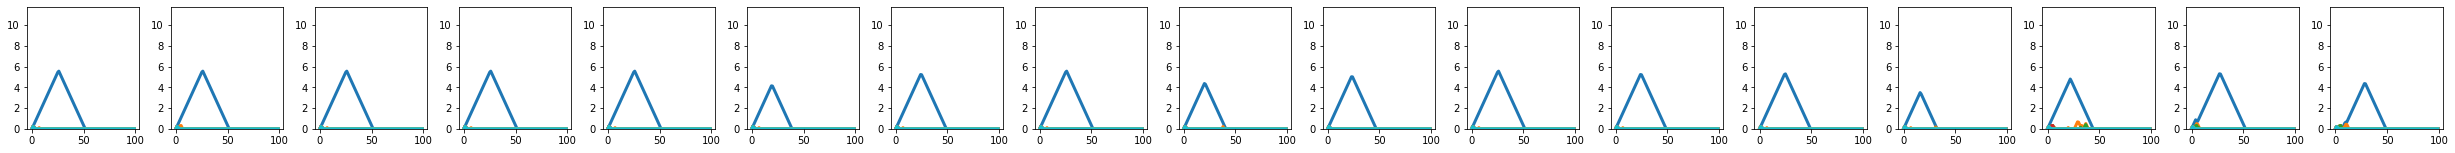

The example image, represented with  1-dim persistence images, under transformations (in columns):


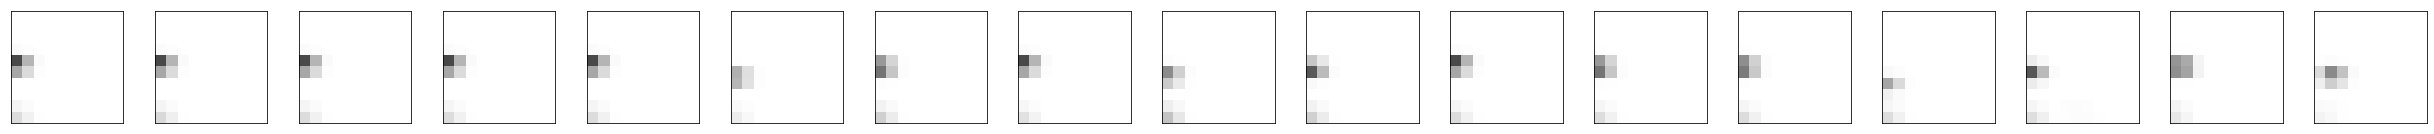

The example image, represented with its DTM filtration function values, under transformations (in columns):


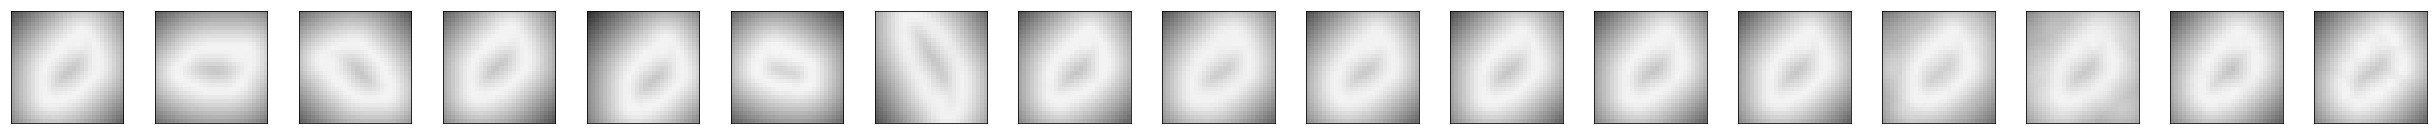

The example image, represented with its 1-dim persistence diagrams, under transformations (in columns):


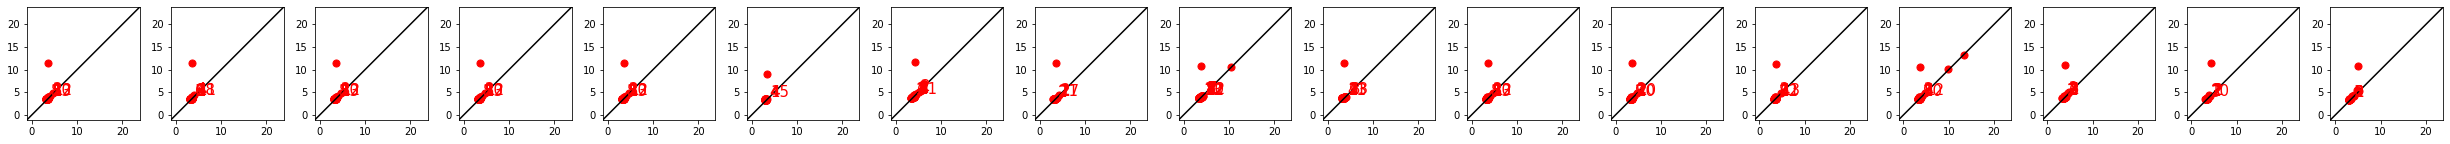

The example image, represented with its 1-dim persistence landscapes, under transformations (in columns):


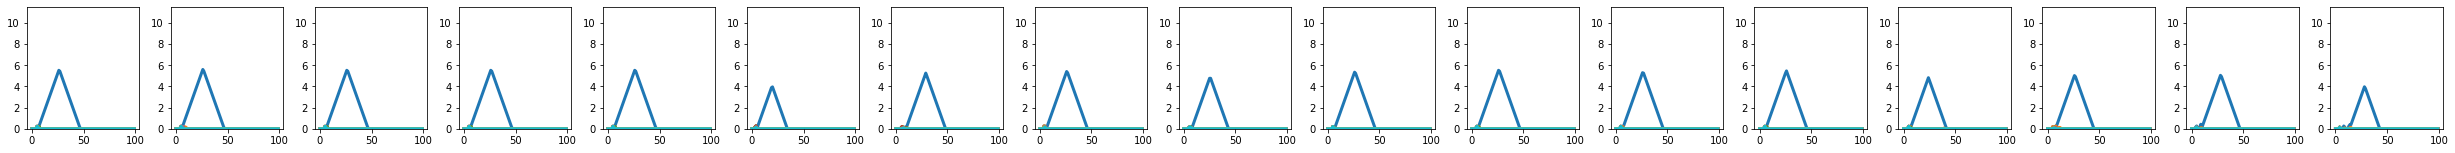

The example image, represented with  1-dim persistence images, under transformations (in columns):


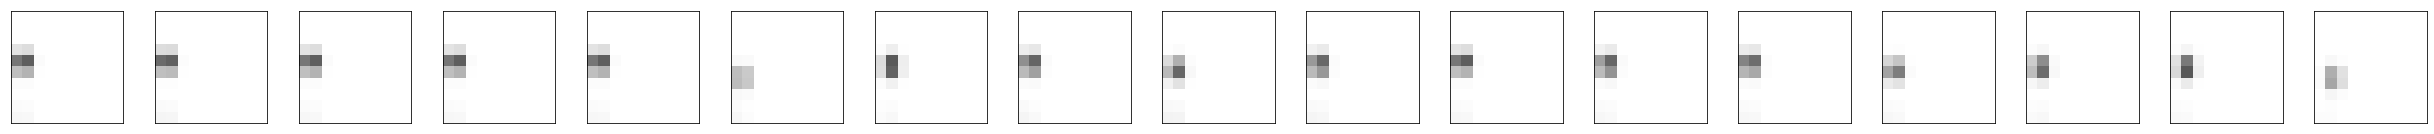

In [29]:
# What does noise do to an image, represented with its filtration function values, 
# and with its persistent homology information?
# (Figure 2 and Figure 3 in turkevs2021noise)

example = 1

# Image.
print("An example image, under transformations (in columns):")
num_fig_rows = 1 
num_fig_cols = len(trnsfs)
subfig_height = 2
subfig_width = 2
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.05)           
for t, trnsf in enumerate(trnsfs):
    image = np.copy(data_images_trnsf[trnsf][example])
    plot_image(image, vmin = 0, vmax = max_data, axes = axes[t])    
fig.savefig("FIGURES/noise_robustness_example_image")
plt.show()   

    
for h, homdim in enumerate(homdims):
    for f, filt in enumerate(filts):     

        # Filtration function values.
        print("The example image, represented with its", filt, "filtration function values, " 
              "under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):
            filt_func_vals = np.copy(data_filt_trnsf[filt, trnsf][example])
            filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
            plot_image(filt_func_vals, vmin = 0, vmax = max_data_filt[filt], axes = axes[t])  
        fig.savefig("FIGURES/noise_robustness_example_" + filt)
        plt.show() 
        
        # PDs.
        print("The example image, represented with its", homdim, "persistence diagrams, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PD = np.copy(data_sign_homdim_filt_trnsf["PD", homdim, filt, trnsf][example])            
            plot_PD(PD, xymax = max_death_PDs_homdim_filt[homdim, filt], axes = axes[t])
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PD")
        plt.show() 
 
        # PLs.
        print("The example image, represented with its", homdim, "persistence landscapes, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PL = np.copy(data_sign_homdim_filt_trnsf["PL", homdim, filt, trnsf][example])            
            plot_PL(PL, num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
                    ymax = max_data_sign_homdim_filt["PL", homdim, filt], axes = axes[t])
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PL")
        plt.show() 
       
        # PIs.
        print("The example image, represented with ", homdim, "persistence images, under transformations (in columns):")
        num_fig_rows = 1 
        num_fig_cols = len(trnsfs)
        subfig_height = 2
        subfig_width = 2
        fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
        fig.tight_layout(pad = 0.05)  
        for t, trnsf in enumerate(trnsfs):   
            PI = np.copy(data_sign_homdim_filt_trnsf["PI", homdim, filt, trnsf][example])
            plot_PI(PI, PI_resolution, vmin = 0, vmax = 0.3 * max_data_sign_homdim_filt["PI", homdim, filt], axes = axes[t])            
        fig.savefig("FIGURES/noise_robustness_example_" + filt + "_" + homdim + "_PI")
        plt.show() 

Change in 0-dim PH wrt density filtration, under rotation 45 , for an example image: 

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 5.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 5.]]


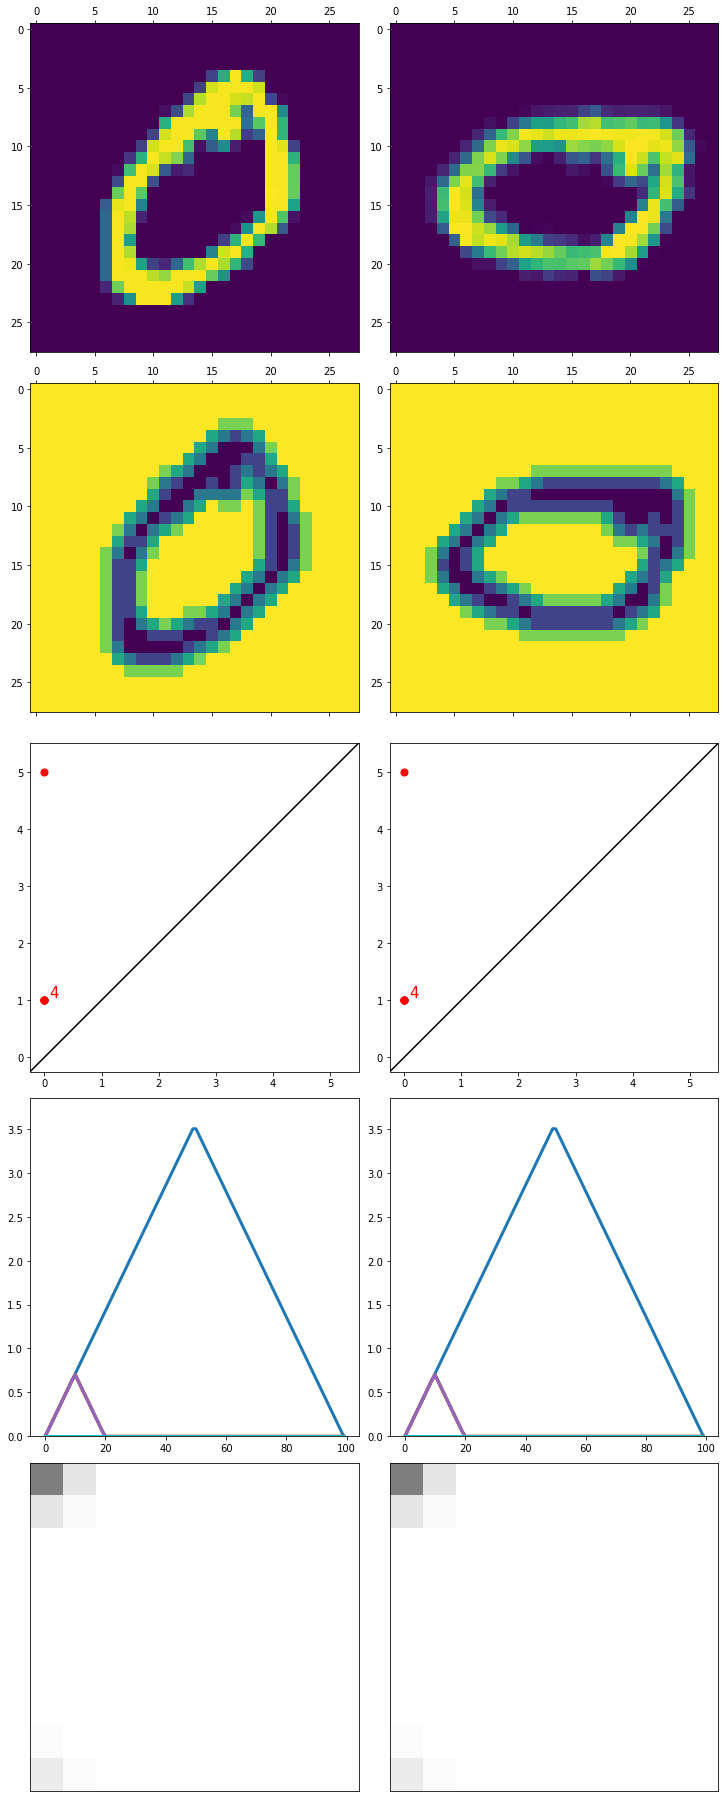

In [30]:
# TODAY

# Auxiliary cell to better understand the change in PH under some transformation, 
# on an example image.
# (same as cell above, but for a given filtration, homological dimension and transformation).
example = 1
filt_temp = "density"
homdim_temp = "0-dim"
trnsf_temp = "rotation 45"

# trnsf_temp = "stretch-shear-flip 1.5 10 h"
# trnsf_temp = "stretch-shear-flip 0.75 -20 v"
# trnsfs = ["no noise", 
#           "rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", 
#           "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
#           "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
#           "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", 
#           "shot noise 50", "shot noise 100"]


print("Change in", homdim_temp, "PH wrt", filt_temp, "filtration, under", trnsf_temp, ", for an example image: \n")
num_fig_rows = 5
num_fig_cols = 2
subfig_height = 5
subfig_width = 5
fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
fig.tight_layout(pad = 0.05) 
axes[0, 0].matshow(data_trnsf["no noise"][example].reshape((num_x_pixels, num_y_pixels)))
axes[0, 1].matshow(data_trnsf[trnsf_temp][example].reshape((num_x_pixels, num_y_pixels)))
axes[1, 0].matshow(data_filt_trnsf[filt_temp, "no noise"][example].reshape((num_x_pixels, num_y_pixels)))
axes[1, 1].matshow(data_filt_trnsf[filt_temp, trnsf_temp][example].reshape((num_x_pixels, num_y_pixels)))
plot_PD(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, "no noise"][example], 
        xymax = max_death_PDs_homdim_filt[homdim_temp, filt_temp], axes = axes[2, 0])
plot_PD(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp][example], 
        xymax = max_death_PDs_homdim_filt[homdim_temp, filt_temp], axes = axes[2, 1])
plot_PL(data_sign_homdim_filt_trnsf["PL", homdim_temp, filt_temp, "no noise"][example], 
        num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
        ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[3, 0])
plot_PL(data_sign_homdim_filt_trnsf["PL", homdim_temp, filt_temp, trnsf_temp][example], 
        num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
        ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[3, 1])
plot_PI(data_sign_homdim_filt_trnsf["PI", homdim_temp, filt_temp, "no noise"][example], 
        PI_resolution, vmin = 0, vmax = 1 * max_data_sign_homdim_filt["PI", homdim_temp, filt_temp], axes = axes[4, 0])    
plot_PI(data_sign_homdim_filt_trnsf["PI", homdim_temp, filt_temp, trnsf_temp][example], 
        PI_resolution, vmin = 0, vmax = 1 * max_data_sign_homdim_filt["PI", homdim_temp, filt_temp], axes = axes[4, 1])    


print(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, "no noise"][example])
print(data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp][example])


# # Visualize filtrations on image.
# filt_func_vals_percentages = np.asarray([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# num_fig_rows = 1
# num_fig_cols = len(filt_func_vals_percentages)
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# filt_func_vals = np.copy(data_filt_trnsf[filt_temp, trnsf_temp][example])
# filt_func_vals = filt_func_vals.reshape((num_x_pixels, num_y_pixels))
# for p, perc in enumerate(filt_func_vals_percentages):
#     cubical_complex = np.zeros((num_x_pixels, num_y_pixels)) + max_data_filt[filt_temp]
#     filt_func_val_upper_limit = perc * max_data_filt[filt_temp]
#     for i in range(num_x_pixels):
#         for j in range(num_y_pixels):
#             if(filt_func_vals[i, j] < filt_func_val_upper_limit):
#                 cubical_complex[i, j] = filt_func_vals[i, j]                    
#     plot_image(cubical_complex, vmin = 0, vmax = max_data_filt[filt_temp], axes = axes[p])

In [31]:
# # Calculation of PLs should not be parallelized across trnsfs.
# PD1 = data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, "no noise"][example]
# PD2 = data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp][example]
# PDs = [PD1, PD2]     
# print("PD1 = ", PD1)
# print("PD2 = ", PD2)


# landscape_ = gd.representations.Landscape(num_landscapes = 10, resolution = 100)

# # PLs obtained seaprately across transformations.
# PL1_1 = landscape_.fit_transform([PD1])[0]
# PL2_1 = landscape_.fit_transform([PD2])[0]

# # PLs obtained together across transformations.
# PLs = landscape_.fit_transform(PDs)
# PL1_2 = PLs[0]
# PL2_2 = PLs[1]

# num_fig_rows = 2
# num_fig_cols = 2
# subfig_height = 5
# subfig_width = 5
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 0.05) 
# plot_PL(PL1_1, num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
#         ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[0, 0])
# plot_PL(PL2_1, num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
#         ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[0, 1])
# plot_PL(PL1_2, num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
#         ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[1, 0])
# plot_PL(PL2_2, num_lndscs = PL_num, lndsc_resolution = PL_resolution, 
#         ymax = max_data_sign_homdim_filt["PL", homdim_temp, filt_temp], axes = axes[1, 1])



In [32]:
# Calculate the l_p distance between each data point and its transformed data point, 
# when images are represented with their filtration function values.
dists_filt_trnsf_data_data = {}
runtime_dists_filt_trnsf_data_data = {}

# Auxiliary function to enable parallel computing of distances.
def compute_dists_filt_trnsf_data_data(filt, trnsf, data_1, data_2):    
    t0 = time.time()        
    dists = l_p_distances(data_1, data_2, p = 2)
    dists_dict = {}
    dists_dict[filt, trnsf] = dists 
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[filt, trnsf] = runtime
    return dists_dict, runtime_dict

print("Parallel calculation of distances between non-noisy and noisy data points across transformations, when images are represented with their filtration functions ...")
t0 = time.time()
dists_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(compute_dists_filt_trnsf_data_data)(filt, trnsf, data_filt_trnsf[filt, "no noise"], data_filt_trnsf[filt, trnsf])
    for filt in filts
    for trnsf in trnsfs)
t1 = time.time()
runtime = t1 - t0
for dists_dict, runtime_dict in dists_and_runtime_dicts:
    dists_filt_trnsf_data_data.update(dists_dict)
    runtime_dists_filt_trnsf_data_data.update(runtime_dict)
print("Runtime = %.3f s" % runtime)
    
# Store the variables.    
with open("VARIABLES/dists_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(dists_filt_trnsf_data_data, f)    
with open("VARIABLES/runtime_dists_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(runtime_dists_filt_trnsf_data_data, f)  

Parallel calculation of distances between non-noisy and noisy data points across transformations, when images are represented with their filtration functions ...
Runtime = 0.309 s


In [33]:
# Calculate the W_p distance between each data point and its transformed data point, 
# when images are represented with their persistent homology information.
dists_sign_homdim_filt_trnsf_data_data = {}
runtime_dists_sign_homdim_filt_trnsf_data_data = {}

def compute_dists_sign_homdim_filt_trnsf_data_data(sign, homdim, filt, trnsf, data_1, data_2):    
    t0 = time.time()        
    if(sign == "PD"):
        dists = wasserstein_p_q_distances(data_1, data_2, p = 2, q = np.inf)
    else: 
        dists = l_p_distances(data_1, data_2, p = 2)
    dists_dict = {}
    dists_dict[sign, homdim, filt, trnsf] = dists 
    t1 = time.time()
    runtime = t1 - t0
    runtime_dict = {}
    runtime_dict[sign, homdim, filt, trnsf] = runtime
    return dists_dict, runtime_dict

# Auxiliary function to enable parallel computing of distances.
print("Parallel calculation of distances between non-noisy and noisy data points across signs, homdims, filts, trnsfs, when images are represented with persistent homology information...")
t0 = time.time()
dists_and_runtime_dicts = Parallel(n_jobs = -1)(
    delayed(compute_dists_sign_homdim_filt_trnsf_data_data)(sign, homdim, filt, trnsf, 
                                                            data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"],
                                                            data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])
    for sign in signs
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
t1 = time.time()
runtime = t1 - t0
for dists_dict, runtime_dict in dists_and_runtime_dicts:
    dists_sign_homdim_filt_trnsf_data_data.update(dists_dict)
    runtime_dists_sign_homdim_filt_trnsf_data_data.update(runtime_dict) 
print("Runtime = %.3f s" % runtime)

# Store the variables.
with open("VARIABLES/dists_sign_homdim_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(dists_sign_homdim_filt_trnsf_data_data, f)    
with open("VARIABLES/runtime_dists_sign_homdim_filt_trnsf_data_data.pkl", "wb") as f:
    pickle.dump(runtime_dists_sign_homdim_filt_trnsf_data_data, f)

Parallel calculation of distances between non-noisy and noisy data points across signs, homdims, filts, trnsfs, when images are represented with persistent homology information...
Runtime = 3.779 s


In [34]:
# How different is the noisy image from the non-noisy image, when images are represented with filtration function values,
# and with persistent homology information?
# (Boxplot for Table 2 in turkevs2021noise)

# print("The range of distances between non-noisy and noisy image, represented with a filtration function, or PH, across transformations (in columns): \n")
# num_fig_rows = num_filts * (1 + num_homdims * num_signs)
# num_fig_cols = len(trnsfs_noisy)
# subfig_height = 2
# subfig_width = 2
# fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
# fig.tight_layout(pad = 5)   
# for t, trnsf in enumerate(trnsfs_noisy):
#     for f, filt in enumerate(filts):
#         axes[f*(1+num_homdims*num_signs), t].boxplot(dists_filt_trnsf_data_data[filt, trnsf])
#         axes[f*(1+num_homdims*num_signs), t].set_title(filt + "\n" + trnsf, fontsize = 10)  
#         for h, homdim in enumerate(homdims):
#             for s, sign in enumerate(signs):
#                 axes[f*(1+num_homdims*num_signs) + h*num_signs + s + 1, t].boxplot(dists_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf])
#                 axes[f*(1+num_homdims*num_signs) + h*num_signs + s + 1, t].set_title(homdim + " " + sign + "\n" + filt + "\n" + trnsf, fontsize = 10) 

In [35]:
# How different is the noisy image from the non-noisy image, when images are represented with filtration function values,
# and with persistent homology information?
# (Table 2 in turkevs2021noise)

avg_dist_filt_trnsf_data_data = {}
avg_dist_sign_homdim_filt_trnsf_data_data = {}
trnsfs_noisy = ["rotation -90", "translation -2 -2", "stretch-shear-flip 0.75 -20 v", "brightness 100","contrast 0.5",          
                "gaussian noise 20", "salt and pepper noise 10", "shot noise 100"]

# LaTeX table body.
for filt in filts:
    print("\\multirow{", 1+num_homdims*num_signs, "}{2cm}{", filt, "} & - & -", end = " ")
    for trnsf in trnsfs_noisy:
        avg_dist_filt_trnsf_data_data[filt, trnsf] = np.mean(dists_filt_trnsf_data_data[filt, trnsf])
        if np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2) == 0:
            print("& \\textbf{", np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2), "}", end = " ")
        else:
            print("&", np.around(avg_dist_filt_trnsf_data_data[filt, trnsf], 2), end = " ")
    print("\\\\")
    for h, homdim in enumerate(homdims):
        print("\\cline{2-", 1+1+1+len(trnsfs_noisy), "}")
        print("& \\multirow{", num_signs, "}{*}{", h, "}")
        for sign in signs:
            if sign == "PD":
                print("&", sign, end = " ")
            else: 
                print("&&", sign, end = " ")
            for trnsf in trnsfs_noisy:
                avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf] = np.mean(dists_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf])
                if np.around(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf], 2) == 0:
                    print("& \\textbf{", "{:.2f}".format(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf]), "}", end = " ")
                else:
                    print("&", "{:.2f}".format(avg_dist_sign_homdim_filt_trnsf_data_data[sign, homdim, filt, trnsf]), end = " ")
            print("\\\\")
    print("\n\\midrule \n")       


\multirow{ 7 }{2cm}{ binary } & - & - & 11.74 & 11.65 & 11.99 & 5.66 & \textbf{ 0.0 } & 2.12 & 6.32 & 6.32 \\
\cline{2- 11 }
& \multirow{ 3 }{*}{ 0 }
& PD & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.01 & 0.03 & \textbf{ 0.00 } & 0.01 & 2.42 & 0.63 \\
&& PL & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.12 & 0.23 & \textbf{ 0.00 } & 0.08 & 12.15 & 5.11 \\
&& PI & \textbf{ 0.00 } & \textbf{ 0.00 } & 18.19 & 36.38 & \textbf{ 0.00 } & 18.19 & 15060.60 & 1373.28 \\
\cline{2- 11 }
& \multirow{ 3 }{*}{ 1 }
& PD & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.03 & 0.12 & \textbf{ 0.00 } & 0.02 & 0.56 & 0.67 \\
&& PL & \textbf{ 0.00 } & \textbf{ 0.00 } & 0.23 & 0.99 & \textbf{ 0.00 } & 0.17 & 4.57 & 5.39 \\
&& PI & \textbf{ 0.00 } & \textbf{ 0.00 } & 11.54 & 54.84 & \textbf{ 0.00 } & 8.66 & 366.55 & 536.84 \\

\midrule 

\multirow{ 7 }{2cm}{ grsc } & - & - & 2651.21 & 2610.48 & 2579.43 & 2649.12 & 3298.06 & 412.49 & 1578.97 & 1088.97 \\
\cline{2- 11 }
& \multirow{ 3 }{*}{ 0 }
& PD & 0.56 & \textbf{ 0.00 } & 25.23

## 5.3) Noise robustness and discriminative power


This section relies on the two dictionaries calculated in section 5.1) data_filt_trnsf and data_sign_homdim_filt_trnsf, to answer the second research question identified in the paper:

> (RQ2) How discriminative is the persistent homology information with respect to different filtrations and persistence signatures, when data does or does not contain noise?

To do so, we evaluate the accuracy of SVM trained on non-noisy and tested on noisy data, when an image is represented with its filtration function, or with its persistent homology:
- $\color{red}{\text{svm_acc_data_filt_trnsf}}$
- $\color{red}{\text{svm_acc_data_sign_homdim_filt_trnsf}}.$

These variables are then used to plot two figures (for 0-dim and 1-dim PH) that show the SVM accuracy. However, to evaluate the noise robustness of persistent homology, we are rather interested in the drop of SVM accuracy when the test data is noisy compared to non-noisy images, and we therefore also provide a table summary of the SVM drop in accuracy.

In [36]:
# Split the data into a training and test (sub)set.
train_size = 0.7
num_train_data_points = int(train_size * num_data_points)

data_filt_trnsf_train = {}
data_filt_trnsf_test = {}
data_sign_homdim_filt_trnsf_train = {}
data_sign_homdim_filt_trnsf_test = {}

permutation = np.random.permutation(num_data_points)
train_indices = permutation[:num_train_data_points]
test_indices = permutation[num_train_data_points:]
# train_num_data_points = np.size(train_indices)
# test_num_data_points = np.size(test_indices)

for trnsf in trnsfs:          
    for filt in filts:        
        data_filt_trnsf_train[filt, trnsf] = np.array(data_filt_trnsf[filt, trnsf])[train_indices]  
        data_filt_trnsf_test[filt, trnsf] = np.array(data_filt_trnsf[filt, trnsf])[test_indices]               
        for homdim in homdims:                    
            for sign in signs:
                data_sign_homdim_filt_trnsf_train[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[train_indices]  
                data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf] = np.array(data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf])[test_indices]  
        
labels_train = np.array(labels)[train_indices]
labels_test = np.array(labels)[test_indices]

print("Number of training data points = ", len(labels_train))
print("Number of training data points = ", len(labels_test))

Number of training data points =  49
Number of training data points =  21


In [37]:
# Build the SVM pipeline. 
# Persistence diagrams are multi-sets and not vectors, and we thus consider SVM with a kernel
# obtained from Wasserstein_p or l_p distances between PDs, PLs or PIs.

class distance_matrix(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None, **fit_params):
        self.X_train_ = X
        return self    
    def transform(self, X, y = None):        
        num_data_points = len(X)
        num_train_data_points = len(self.X_train_)
        distance_matrix = np.zeros((num_data_points, num_train_data_points))
        if type(X[0][0]) == np.float64: 
            for i in range(num_data_points):
                for j in range(num_train_data_points):
                    distance_matrix[i, j] = np.linalg.norm(X[i] - self.X_train_[j], ord = 2)
        else: # Element of a PD is not a number, but a persistence interval (1x2 numpy array, birth and death value).
            for i in range(num_data_points):
                for j in range(num_train_data_points):
                    distance_matrix[i, j] = gudhi.wasserstein.wasserstein_distance(X[i], self.X_train_[j], 
                                                                                   order = 2, internal_p = np.inf) 
        return distance_matrix
    

class kernel_rbf(BaseEstimator, TransformerMixin):     
    def __init__(self, gamma = 1.00):
        self.gamma = gamma       
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y = None):  
        return np.exp(-self.gamma * X**2) 
    

# Pipeline with SVM custom kernel, and SVM, in order to enable to simultaneously tune the kernel and SVM parameters.
pipeline = Pipeline(
    steps = [
        ('distance_matrix', distance_matrix()),
        ('kernel_rbf', kernel_rbf()),
        ('svm', SVC())
        ])

  
# !!! Choice of SVM parameter values.
gamma_range = np.logspace(-6, -2, 5) # np.logspace(-9, 4, 14) 
C_range = np.logspace(-1, 2, 4) # np.logspace(-2, 10, 13) #   
parameters_grid = dict([
    ('kernel_rbf__gamma', gamma_range),
    ('svm__kernel', ['precomputed']),
    ('svm__C', C_range)
]) 
print("SVM parameters: ")
print("gamma_range = ", gamma_range)
print("C_range = ", C_range)

SVM parameters: 
gamma_range =  [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
C_range =  [  0.1   1.   10.  100. ]


In [38]:
# Compute the accuracy of SVM trained on non-noisy images, and tested on non-noisy and noisy images,
# when an image is represented with its filtration function values.
svm_classifier_data_filt = {} # stored so that confusion matrices can directly be plotted later
runtime_svm_tune_parameters_data_filt = {}
# We also store the SVM coefficients to see what is learned for each class, 
# when images are represented with their filtration functions.
# The SVM coefficients are learned from the training data, which is always non-noisy in our experimental set-up 
# (whereas the test data can be subject to noise), so that the following variable does not depend on the transformation of data.
# svm_coeffs_data_filt = {}
svm_acc_data_filt_trnsf = {}


# Auxiliary function to enable parallel tuning of SVM parameters, across filtrations.
def SVM_tune_parameters_and_fit_best(filt, data_train, labels_train): 
    print("Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, ")
    print("when images are represented with their " + filt + " filtration function:")
    t0 = time.time()   
    grid_search = GridSearchCV(pipeline, parameters_grid, n_jobs = -1)      
    grid_search = grid_search.fit(data_train, labels_train)     
    t1 = time.time()
    print("Runtime for this step =", t1-t0)  
    print("Best parameters:", grid_search.best_params_)
    cv_accuracies = grid_search.cv_results_['mean_test_score']
    print("Number of parameter combinations = ", len(cv_accuracies))
    print("cv_accuracies = ", np.around(cv_accuracies, 2))
    print("Best accuracy = ", np.max(cv_accuracies))
    print()
    svm_classifier_dict = {}
    svm_classifier_dict[filt] = clone(grid_search.best_estimator_) 
    svm_classifier_dict[filt] = svm_classifier_dict[filt].fit(data_train, labels_train)
    # svm_coeffs_data_filt[filt] = svm_classifier_data_filt[filt].coef_
    runtime_svm_tune_parameters_dict = {}
    runtime_svm_tune_parameters_dict[filt] = t1-t0   
    return svm_classifier_dict, runtime_svm_tune_parameters_dict

print("Parallel tuning of SVM parameters when images are represented with their filtration function values, across filtrations ... \n")
t0 = time.time()
svm_classifier_runtime_dicts = Parallel(n_jobs = 1)(
    delayed(SVM_tune_parameters_and_fit_best)(filt, data_filt_trnsf_train[filt, "no noise"], labels_train)
            for filt in filts)
for svm_classifier_dict, runtime_svm_tune_parameters_dict in svm_classifier_runtime_dicts:
    svm_classifier_data_filt.update(svm_classifier_dict)
    runtime_svm_tune_parameters_data_filt.update(runtime_svm_tune_parameters_dict)
with open("VARIABLES/svm_classifier_data_filt.pkl", "wb") as f:
    pickle.dump(svm_classifier_data_filt, f)    
with open("VARIABLES/runtime_svm_tune_parameters_data_filt.pkl", "wb") as f:
    pickle.dump(runtime_svm_tune_parameters_data_filt, f)    
# with open("VARIABLES/svm_coeffs_data_filt.pkl", "wb") as f:
#     pickle.dump(svm_coeffs_data_filt, f)   


# Auxiliary function to enable parallel calculation of SVM accuracies, across filtrations.
def compute_accuracy(estimator, filt, trnsf, data_test_, labels_test):          
    svm_acc_dict = {}
    svm_acc_dict[filt, trnsf] = estimator.score(data_test_, labels_test) 
    # labels_predicted = svm_classifier_dict[filt].predict(data_test_trnsfs[t])
    # print("labels_predicted = ", labels_predicted)
    # print("labels_test =      ", labels_test, "\n")    
    return svm_acc_dict

print("Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across filtrations and transformations... \n")
svm_acc_dicts = Parallel(n_jobs = -1)(
    delayed(compute_accuracy)(svm_classifier_data_filt[filt], filt, trnsf,
                              data_filt_trnsf_test[filt, trnsf], labels_test)
    for filt in filts
    for trnsf in trnsfs)
for svm_acc_dict in svm_acc_dicts:
    svm_acc_data_filt_trnsf.update(svm_acc_dict)  
with open("VARIABLES/svm_acc_data_filt_trnsf.pkl", "wb") as f:
    pickle.dump(svm_acc_data_filt_trnsf, f)
t1 = time.time()
runtime = t1 - t0
print("Total runtime = %.3f s" % runtime)


# This cell, with Parallel(n_jobs = 1) and GridSearchCV(n_jobs = -1), computation time = 165 seconds
# This cell, with Parallel(n_jobs = -1) and GridSearchCV(n_jobs = -1), computation time = 668

Parallel tuning of SVM parameters when images are represented with their filtration function values, across filtrations ... 

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their binary filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9546513557434082
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.63 0.2  0.2
 0.61 0.61 0.18 0.45 0.57 0.57]
Best accuracy =  0.6333333333333333

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their grsc filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9614295959472656
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.29 0.33 0.33 0.16 0.18 0.18 0.18 0.16 0.16 0.16 0.16 0.12 0.12
 0.12 0.12 0.1  0.1  0.1  0.1 ]
Best accuracy =  0.3266666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their density filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9355990886688232
Best parameters: {'kernel_rbf__gamma': 1e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.72 0.2  0.2  0.72 0.68 0.2  0.55
 0.63 0.63 0.16 0.2  0.2  0.2 ]
Best accuracy =  0.7155555555555555

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their radial filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9474327564239502
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.35 0.66 0.18 0.22 0.66 0.66 0.18 0.39 0.49 0.49 0.16 0.16
 0.16 0.16 0.16 0.18 0.18 0.18]
Best accuracy =  0.6555555555555556

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their Rips filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9165799617767334
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.53 0.16 0.16 0.51 0.65 0.18 0.35 0.67 0.69 0.18 0.61
 0.66 0.66 0.18 0.2  0.2  0.2 ]
Best accuracy =  0.6933333333333334

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their DTM filtration function:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8806114196777344
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.4  0.16 0.16 0.4  0.64 0.16 0.27 0.7  0.69 0.18 0.64
 0.64 0.64 0.16 0.2  0.22 0.22]
Best accuracy =  0.6955555555555556

Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across filtrations and transformations... 

Total runtime = 6.454 s


In [39]:
# Compute the accuracy of SVM trained on non-noisy images, and tested on noisy images,
# when an image is represented with its persistent homology information.
svm_classifier_data_sign_homdim_filt = {} # stored so that conf matrices can be plotted later
runtime_svm_tune_parameters_data_sign_homdim_filt = {}
# The SVM coefficients are learned from the training data, which is always non-noisy in our 
# experimental set-up (whereas the test data can be subject to noise), so that the following variable does not 
# depend on the transformation of data.
svm_coeffs_data_sign_homdim_filt = {}
svm_acc_data_sign_homdim_filt_trnsf = {}


# Auxiliary function to enable parallel tuning of SVM parameters, 
# across persistence signatures, homological dimensions and filtrations.
def SVM_tune_parameters_and_fit_best(sign, homdim, filt, data_train, labels_train):
    print("Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, ")
    print("when images are represented with their " + homdim + " " + sign + " wrt " + filt + " filtration:")
    t0 = time.time()     
    grid_search = GridSearchCV(pipeline, parameters_grid, n_jobs = -1)      
    grid_search = grid_search.fit(data_train, labels_train)       
    t1 = time.time()
    print("Runtime for this step =", t1-t0)
    print("Best parameters:", grid_search.best_params_)
    cv_accuracies = grid_search.cv_results_['mean_test_score']
    print("Number of parameter combinations = ", len(cv_accuracies))
    print("cv_accuracies = ", np.around(cv_accuracies, 2))
    print("Best accuracy = ", np.max(cv_accuracies))    
    print()
    svm_classifier_dict = {}
    svm_classifier_dict[sign, homdim, filt] = clone(grid_search.best_estimator_) 
    svm_classifier_dict[sign, homdim, filt] = svm_classifier_dict[sign, homdim, filt].fit(data_train, labels_train) 
    # svm_coeffs_data_sign_homdim_filt[sign, homdim, filt] = svm_classifier_data_sign_homdim_filt[sign, homdim, filt].coef_
    runtime_svm_tune_parameters_dict = {}
    runtime_svm_tune_parameters_dict[sign, homdim, filt] = t1-t0    
    return svm_classifier_dict, runtime_svm_tune_parameters_dict



print("Parallel tuning of SVM parameters when images are represented with their persistent homology information, across persistence signatures, homological dimensions and filtrations... \n")
t0 = time.time()
svm_classifier_runtime_dicts = Parallel(n_jobs = 1)(
    delayed(SVM_tune_parameters_and_fit_best)(sign, homdim, filt, 
                                              data_sign_homdim_filt_trnsf_train[sign, homdim, filt, "no noise"], labels_train)
    for sign in signs
    for homdim in homdims
    for filt in filts)
for svm_classifier_dict, runtime_svm_tune_parameters_dict in svm_classifier_runtime_dicts:
    svm_classifier_data_sign_homdim_filt.update(svm_classifier_dict)
    runtime_svm_tune_parameters_data_sign_homdim_filt.update(runtime_svm_tune_parameters_dict) 
with open("VARIABLES/svm_classifier_data_sign_homdim_filt.pkl", "wb") as f:
    pickle.dump(svm_classifier_data_sign_homdim_filt, f)    
with open("VARIABLES/runtime_svm_tune_parameters_data_sign_homdim_filt.pkl", "wb") as f:
    pickle.dump(runtime_svm_tune_parameters_data_sign_homdim_filt, f)    
# with open("VARIABLES/svm_coeffs_data_sign_homdim_filt.pkl", "wb") as f:
#     pickle.dump(svm_coeffs_data_sign_homdim_filt, f)    


# Auxiliary function to enable parallel calculation of SVM accuracies, 
# across persistence signatures, homological dimensions and filtrations.
def compute_accuracy(estimator, sign, homdim, filt, trnsf, data_test, labels_test):        
    svm_acc_dict = {}
    svm_acc_dict[sign, homdim, filt, trnsf] = estimator.score(data_test, labels_test)   
    return svm_acc_dict
    

print("Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across persistence signatures, homological dimensions and filtrations... \n")
svm_acc_dicts = Parallel(n_jobs = -1)(
    delayed(compute_accuracy)(svm_classifier_data_sign_homdim_filt[sign, homdim, filt], sign, homdim, filt, trnsf,
                              data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf], labels_test)
    for sign in signs
    for homdim in homdims
    for filt in filts
    for trnsf in trnsfs)
for svm_acc_dict in svm_acc_dicts:
    svm_acc_data_sign_homdim_filt_trnsf.update(svm_acc_dict)
with open("VARIABLES/svm_acc_data_sign_homdim_filt_trnsf.pkl", "wb") as f:
    pickle.dump(svm_acc_data_sign_homdim_filt_trnsf, f)
    
t1 = time.time()
runtime = t1 - t0
print("Total runtime = %.3f s" % runtime)

Parallel tuning of SVM parameters when images are represented with their persistent homology information, across persistence signatures, homological dimensions and filtrations... 

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.171152591705322
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
Best accuracy =  0.10222222222222221

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.923974514007568
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.16 0.1  0.1  0.18 0.12 0.1  0.16
 0.14 0.2  0.12 0.14 0.19 0.14]
Best accuracy =  0.20444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.471014261245728
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
 0.12 0.12 0.12 0.12 0.12 0.2 ]
Best accuracy =  0.20444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.572923183441162
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.18 0.14 0.14
 0.18 0.26 0.14 0.18 0.28 0.33]
Best accuracy =  0.32666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 61.78786635398865
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.14 0.14 0.14 0.14 0.14]
Best accuracy =  0.14444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PD wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 81.38031363487244
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.18 0.14 0.14
 0.18 0.2  0.14 0.16 0.2  0.12]
Best accuracy =  0.20444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.521183729171753
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.14 0.14 0.14 0.14 0.16]
Best accuracy =  0.16

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.81338095664978
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.3  0.14 0.14 0.3  0.31 0.14 0.28 0.31 0.33 0.12 0.26
 0.23 0.29 0.12 0.23 0.23 0.23]
Best accuracy =  0.32666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.560197830200195
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.12 0.12 0.12 0.14 0.12 0.12 0.12 0.14 0.12 0.12 0.12 0.14 0.12
 0.12 0.26 0.14 0.12 0.28 0.28]
Best accuracy =  0.2844444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 11.459320068359375
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.26 0.14 0.14
 0.26 0.32 0.14 0.26 0.3  0.28]
Best accuracy =  0.3222222222222223

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 27.267372846603394
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.29 0.16 0.16 0.29 0.39]
Best accuracy =  0.38666666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PD wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 30.668550968170166
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.16 0.14 0.14
 0.16 0.35 0.14 0.14 0.32 0.43]
Best accuracy =  0.42666666666666664

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7758924961090088
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
Best accuracy =  0.10222222222222221

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8606326580047607
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.1  0.14 0.18 0.1  0.12 0.16 0.12 0.1  0.16 0.14 0.18 0.12 0.14
 0.16 0.14 0.14 0.16 0.16 0.14]
Best accuracy =  0.18444444444444447

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8607761859893799
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.16 0.14 0.14 0.14 0.14]
Best accuracy =  0.1622222222222222

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8807084560394287
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.18 0.18 0.18 0.22 0.18 0.18 0.22 0.2  0.18 0.22 0.2  0.28 0.18 0.22
 0.22 0.28 0.14 0.25 0.26 0.26]
Best accuracy =  0.2844444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8508281707763672
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
Best accuracy =  0.10222222222222221

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PL wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8498401641845703
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.2  0.16 0.16
 0.2  0.31 0.16 0.2  0.31 0.27]
Best accuracy =  0.30666666666666664

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.871563196182251
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.18 0.14 0.14 0.18 0.18]
Best accuracy =  0.18

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8785412311553955
Best parameters: {'kernel_rbf__gamma': 1e-05, 'svm__C': 1.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.3  0.33 0.28 0.16 0.35 0.29 0.29 0.14 0.16 0.21 0.19 0.14 0.24
 0.25 0.25 0.12 0.24 0.24 0.24]
Best accuracy =  0.3466666666666666

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8447413444519043
Best parameters: {'kernel_rbf__gamma': 0.0001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.14 0.14 0.14 0.16 0.14 0.14 0.22 0.16 0.14 0.22 0.3  0.16 0.22
 0.3  0.26 0.16 0.28 0.26 0.2 ]
Best accuracy =  0.3044444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8454298973083496
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.16 0.14 0.14 0.16 0.26 0.14 0.16 0.24 0.28 0.14 0.26
 0.28 0.28 0.14 0.3  0.3  0.34]
Best accuracy =  0.34444444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.9055447578430176
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.2  0.14 0.14 0.2  0.24 0.14 0.2
 0.24 0.34 0.14 0.2  0.32 0.3 ]
Best accuracy =  0.34444444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PL wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8787007331848145
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.22 0.16 0.16 0.22 0.24 0.16 0.22
 0.24 0.39 0.16 0.24 0.39 0.51]
Best accuracy =  0.5088888888888888

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7291958332061768
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 0.1, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
Best accuracy =  0.10222222222222221

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7548520565032959
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.14 0.1  0.1
 0.14 0.14 0.1  0.14 0.14 0.12]
Best accuracy =  0.14444444444444443

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8000636100769043
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.16 0.12 0.14 0.12 0.12]
Best accuracy =  0.16444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7769200801849365
Best parameters: {'kernel_rbf__gamma': 0.001, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.12 0.16 0.16 0.12 0.2  0.16 0.12
 0.18 0.29 0.14 0.2  0.24 0.24]
Best accuracy =  0.2866666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7728934288024902
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.14 0.12 0.12
 0.14 0.16 0.14 0.16 0.18 0.18]
Best accuracy =  0.18444444444444444

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 0-dim PI wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7765429019927979
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 10.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.18 0.14 0.14
 0.16 0.22 0.14 0.18 0.24 0.24]
Best accuracy =  0.24444444444444446

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt binary filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.813788890838623
Best parameters: {'kernel_rbf__gamma': 1e-06, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.2  0.24 0.14 0.22 0.2  0.22 0.14 0.18 0.2  0.2  0.14 0.18
 0.18 0.18 0.14 0.18 0.18 0.18]
Best accuracy =  0.24

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt grsc filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7411465644836426
Best parameters: {'kernel_rbf__gamma': 1e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.12 0.12 0.12 0.14 0.12 0.12 0.14 0.22 0.12 0.12 0.22 0.2  0.16 0.22
 0.2  0.2  0.16 0.22 0.2  0.2 ]
Best accuracy =  0.22444444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt density filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.789886474609375
Best parameters: {'kernel_rbf__gamma': 1e-05, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.14 0.14 0.14 0.16 0.14 0.14 0.26 0.16 0.14 0.24 0.22 0.16 0.24
 0.22 0.18 0.16 0.22 0.2  0.18]
Best accuracy =  0.2644444444444445

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt radial filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7479660511016846
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.14 0.12 0.12 0.14 0.26 0.12 0.12
 0.28 0.28 0.14 0.26 0.33 0.35]
Best accuracy =  0.3466666666666667

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt Rips filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.7879080772399902
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.2  0.16 0.16
 0.2  0.35 0.16 0.22 0.33 0.39]
Best accuracy =  0.3888888888888889

Tuning SVM hyper-parameters C and gamma with GridSearchCV() on non-noisy data, 
when images are represented with their 1-dim PI wrt DTM filtration:


C:\Users\renat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Runtime for this step = 0.8008570671081543
Best parameters: {'kernel_rbf__gamma': 0.01, 'svm__C': 100.0, 'svm__kernel': 'precomputed'}
Number of parameter combinations =  20
cv_accuracies =  [0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.18 0.14 0.14
 0.18 0.18 0.14 0.2  0.2  0.35]
Best accuracy =  0.3488888888888889

Parallel testing of SVM with the best parameters on the non-noisy and noisy test data, across persistence signatures, homological dimensions and filtrations... 

Total runtime = 353.855 s


C:\Users\renat\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\renat\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'runtime')

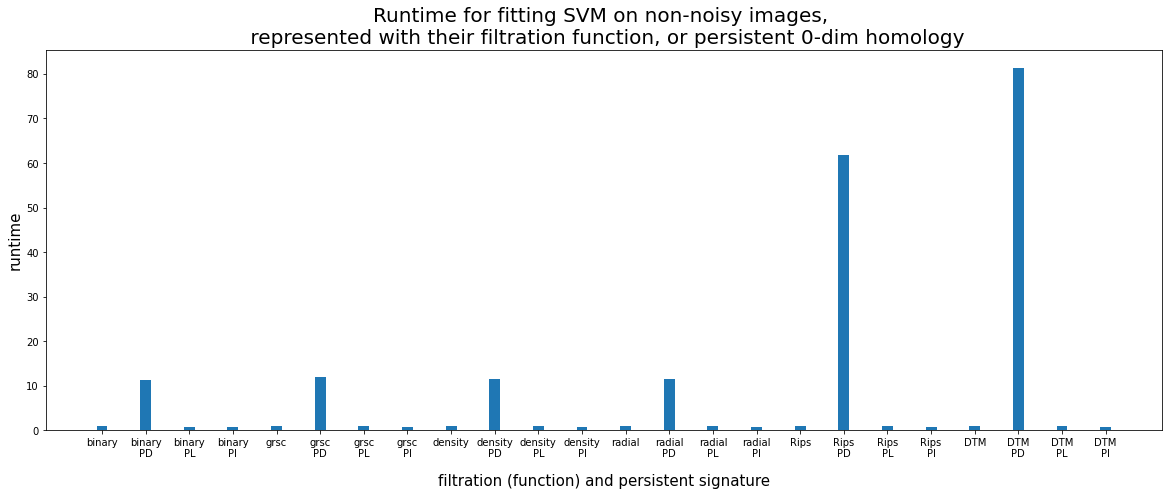

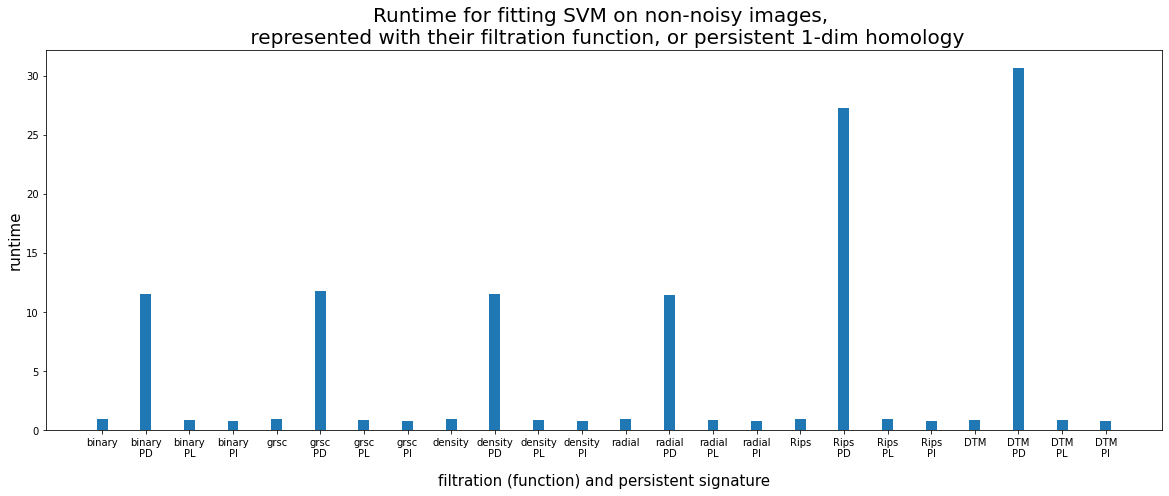

In [40]:
# How long does it take to fit SVM on non-noisy data, when images are represented with 
# their filtration functions or persistent homology information?

# Figure 1-2 x-axis.
filts_and_signs = [filt +  "\n" + sign 
                   for filt in filts
                   for sign in [" "] + signs]

# Figure 1: homdim0.
# Figure 1 y-axis, dictionary with elements as list of runtimes for fitting SVM on different representations of the non-noisy dataset.
runtime_svm_tune_parameters_data_homdim0 = [[runtime_svm_tune_parameters_data_filt[filt]] + [runtime_svm_tune_parameters_data_sign_homdim_filt[sign, "0-dim", filt]
                                                                                   for sign in signs] 
                                       for filt in filts]       
runtime_svm_tune_parameters_data_homdim0 = [j for i in runtime_svm_tune_parameters_data_homdim0
                                       for j in i]    
fig, axis = plt.subplots(figsize = (20, 7))
axis.bar(filts_and_signs, runtime_svm_tune_parameters_data_homdim0, width = 0.25)
axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")
axis.set_title("Runtime for fitting SVM on non-noisy images, \n represented with their filtration function, or persistent 0-dim homology", fontsize = 20)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("runtime", fontsize = 15)
# fig.savefig("FIGURES/runtime_SVM_tune_parameters_homdim0", bbox_inches = "tight")

# Figure 2: homdim1.
# Figure 2 y-axis, dictionary with elements as list of runtimes for fitting SVM on different representations of the non-noisy dataset.
runtime_svm_tune_parameters_data_homdim1 = [[runtime_svm_tune_parameters_data_filt[filt]] + [runtime_svm_tune_parameters_data_sign_homdim_filt[sign, "1-dim", filt]
                                                                                   for sign in signs] 
                                       for filt in filts]       
runtime_svm_tune_parameters_data_homdim1 = [j for i in runtime_svm_tune_parameters_data_homdim1
                                       for j in i]  
fig, axis = plt.subplots(figsize = (20, 7))
axis.bar(filts_and_signs, runtime_svm_tune_parameters_data_homdim1, width = 0.25)
axis.set_xticklabels(filts_and_signs) # fontsize = 12, rotation = 45, horizontalalignment = "right", verticalalignment = "top")
axis.set_title("Runtime for fitting SVM on non-noisy images, \n represented with their filtration function, or persistent 1-dim homology", fontsize = 20)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("runtime", fontsize = 15)
# fig.savefig("FIGURES/runtime_SVM_tune_parameters_homdim1", bbox_inches = "tight")

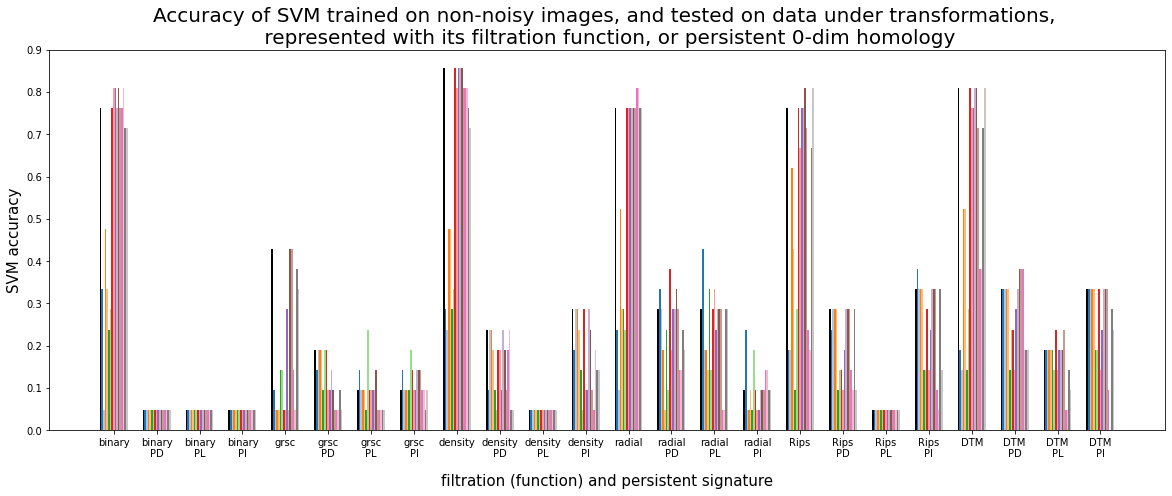

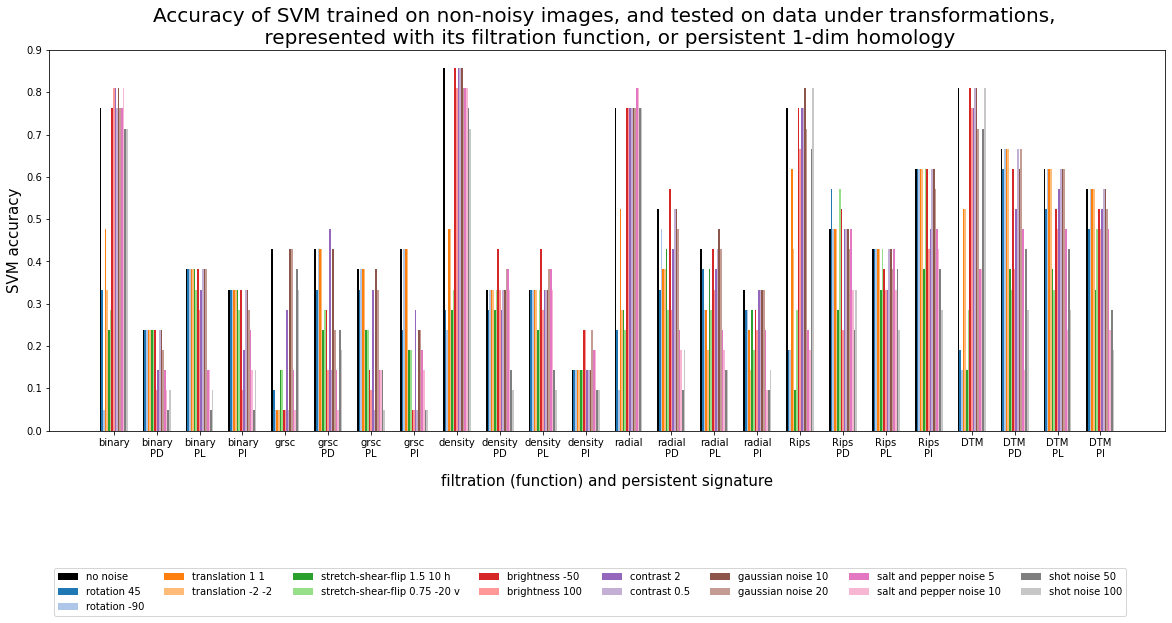

In [41]:
# How well does SVM trained on non-noisy data classifies the noisy dataset, when images are represented
# with their filtration function values, and persistent homology information?

# Figure 1: homdim0.
# Figure 1 y-axis, per different transformations (colors, or legend items), dictionary of lists.
svm_acc_data_homdim0_nonoise_trnsfs = {}
for trnsf in trnsfs:
    svm_acc_data_homdim0_nonoise_trnsfs[trnsf] = [[svm_acc_data_filt_trnsf[filt, trnsf]] + [svm_acc_data_sign_homdim_filt_trnsf[sign, "0-dim", filt, trnsf]
                                                                                            for sign in signs]
                                                  for filt in filts] 
    svm_acc_data_homdim0_nonoise_trnsfs[trnsf] = [j for i in svm_acc_data_homdim0_nonoise_trnsfs[trnsf]
                                                  for j in i]      
fig, axis = plot_bar_containers(filts_and_signs, svm_acc_data_homdim0_nonoise_trnsfs, trnsfs)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("SVM accuracy", fontsize = 15)
# fig.savefig("FIGURES/svm_acc_homdim0", bbox_inches = "tight")
axis.set_title("Accuracy of SVM trained on non-noisy images, and tested on data under transformations, \n represented with its filtration function, or persistent 0-dim homology", fontsize = 20)

# Figure 2: homdim1.
# Figure 2 y-axis, per different transformations (colors, or legend items), dictionary of lists.
svm_acc_data_homdim1_nonoise_trnsfs = {}
for trnsf in trnsfs:
    svm_acc_data_homdim1_nonoise_trnsfs[trnsf] = [[svm_acc_data_filt_trnsf[filt, trnsf]] + [svm_acc_data_sign_homdim_filt_trnsf[sign, "1-dim", filt, trnsf]
                                                                                            for sign in signs]
                                                   for filt in filts] 
    svm_acc_data_homdim1_nonoise_trnsfs[trnsf] = [j for i in svm_acc_data_homdim1_nonoise_trnsfs[trnsf]
                                                  for j in i]      
fig, axis = plot_bar_containers(filts_and_signs, svm_acc_data_homdim1_nonoise_trnsfs, trnsfs)
axis.set_xlabel("filtration (function) and persistent signature", fontsize = 15, labelpad = 15)
axis.set_ylabel("SVM accuracy", fontsize = 15)

# Figure 2 legend.
legend = axis.legend(trnsfs, loc = "lower left", bbox_to_anchor=(0, -0.5), ncol = 8, fontsize = 10)
for t, line in enumerate(legend.get_lines()):
    line.set_linewidth(4.0)

# fig.savefig("FIGURES/svm_acc_homdim1", bbox_inches = "tight")
axis.set_title("Accuracy of SVM trained on non-noisy images, and tested on data under transformations, \n represented with its filtration function, or persistent 1-dim homology", fontsize = 20)

plt.show()

In [42]:
# Print SVM drop in accuracy LaTeX table.      
trnsfs_noisy = ["rotation 45", "rotation -90", "translation 1 1", "translation -2 -2", 
                "stretch-shear-flip 1.5 10 h", "stretch-shear-flip 0.75 -20 v",
                "brightness -50", "brightness 100", "contrast 2", "contrast 0.5",
                "gaussian noise 10", "gaussian noise 20", "salt and pepper noise 5", "salt and pepper noise 10", 
                "shot noise 50", "shot noise 100"]

# Print LaTeX table with SVM drop in accuracy.
for filt in filts:
    print("\\multirow{", 1+num_homdims*num_signs, "}{2cm}{", filt, "} & - & -", end = " ")
    for trnsf in trnsfs_noisy:
        svm_acc_drop = ( svm_acc_data_filt_trnsf[filt, "no noise"] - svm_acc_data_filt_trnsf[filt, trnsf] ) / svm_acc_data_filt_trnsf[filt, "no noise"]
        if svm_acc_drop < 0:
            svm_acc_drop = 0            
        print("& {\color{red!", np.around(100 * svm_acc_drop, 2), "!blue} \\scalebox{", np.around(svm_acc_data_filt_trnsf[filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
    print("\\\\")
    for h, homdim in enumerate(homdims):
        print("\\cline{2-", 1+1+1+len(trnsfs_noisy), "}")
        print("& \\multirow{", num_signs, "}{*}{", h, "}")
        for sign in signs:
            if sign == "PD":
                print("&", sign, end = " ")
            else:
                print("&&", sign, end = " ")
            for trnsf in trnsfs_noisy:
                svm_acc_drop = ( svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"] - svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] ) / svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"]
                if svm_acc_drop < 0:
                    svm_acc_drop = 0                 
                print("& {\color{red!", "{:.2f}".format(100 * svm_acc_drop), "!blue} \\scalebox{", np.around(svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"], 2), "}{\\rule{0.5cm}{0.5cm}}}", end = " ")
            print("\\\\")
    print("\n\\midrule \n")
        

# for filt in filts:
#     print(filt, end = " ")
#     # print(filt, end = "              ")
#     for trnsf in trnsfs_noisy:
#         svm_acc_drop = ( svm_acc_data_filt_trnsf[filt, "no noise"] - svm_acc_data_filt_trnsf[filt, trnsf] ) / svm_acc_data_filt_trnsf[filt, "no noise"]
#         print("&", np.around(svm_acc_drop, 2), end = " ")
#     print("\\\\")
#     for homdim in homdims:
#         for sign in signs:
#             print("&&", sign, end = " ")
#             # print(filt, "&", homdim, "&", sign, end = " ")
#             for trnsf in trnsfs_noisy:
#                 svm_acc_drop = (svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"] - svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, trnsf] ) / svm_acc_data_sign_homdim_filt_trnsf[sign, homdim, filt, "no noise"]
#                 print("&", "{:.2f}".format(svm_acc_drop), end = " ")
#             print("\\\\")
#     print()

\multirow{ 7 }{2cm}{ binary } & - & - & {\color{red! 56.25 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 93.75 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 37.5 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 56.25 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 68.75 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 62.5 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0 !blue} \scalebox{ 0.76 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 6.25 !blue} \scalebox

&& PI & {\color{red! 14.29 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 14.29 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 28.57 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 57.14 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 14.29 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 42.86 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 14.29 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 28.57 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 28.57 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 71.43 !blue} \scalebox{ 0.33 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 71.43 !blue} \scalebox{ 0.33 }{

&& PL & {\color{red! 15.38 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 38.46 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 46.15 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 15.38 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 23.08 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 7.69 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 0.00 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 23.08 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 61.54 !blue} \scalebox{ 0.62 }{\rule{0.5cm}{0.5cm}}} & {\color{red! 30.77 !blue} \scalebox{ 0.62 }{\ru

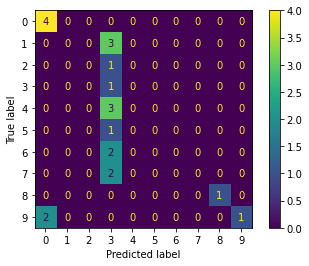

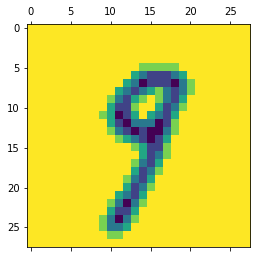

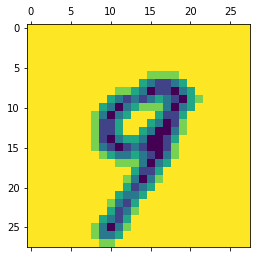

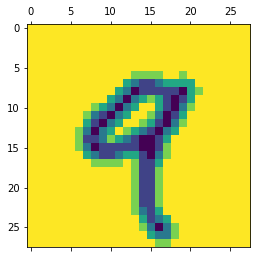

In [43]:
# How does SVM trained on non-noisy misclassify the noisy dataset, when images are represented 
# with their filtration function values, and persistent homology information?
    
# def plot_conf_matrix_across_signs_filts_trnsfs(homdim, trnsfs):       
#     num_fig_rows = num_filts * (1 + num_signs)
#     num_fig_cols = len(trnsfs)
#     subfig_height = 2
#     subfig_width = 2
#     fig, axes = plt.subplots(num_fig_rows, num_fig_cols, figsize = (num_fig_cols * subfig_width, num_fig_rows * subfig_height)) 
#     fig.tight_layout(pad = 0.01)
#     # fig.subplots_adjust(top = 0.94)        
#     for f, filt in enumerate(filts):        
#         # SVM trained on filtration functions, svm_conf_matrix_data_filt_trnsf.
#         for t, trnsf in enumerate(trnsfs):
#             svm_conf_matrix_data_filt_trnsf = plot_confusion_matrix(svm_classifier_data_filt[filt], 
#                                                                     data_filt_trnsf_test[filt, trnsf], 
#                                                                     labels_test, 
#                                                                     ax = axes[f*(1+num_signs), t])
#             axes[f*(1+num_signs), t].set_title(filt + "\n" + trnsf, fontsize = 10)
#             # svm_conf_matrix_trnsf_data.figure_.suptitle(filt + "\n" + trnsf, fontsize = 20)        
#         # SVM trained on persistence signatures, svm_classifier_sign_homdim_filt_data.
#         for s, sign in enumerate(signs):
#             for t, trnsf in enumerate(trnsfs):
#                 svm_conf_matrix_data_sign_homdim_filt_trnsf = plot_confusion_matrix(svm_classifier_data_sign_homdim_filt[sign, homdim, filt],
#                                                                                     data_sign_homdim_filt_trnsf_test[sign, homdim, filt, trnsf],
#                                                                                     labels_test, 
#                                                                                     ax = axes[f*(1+num_signs) + 1+s, t])
#                 axes[f*(1+num_signs) + 1+s, t].set_title(sign + ", " + filt + "\n" + trnsf, fontsize = 10)
#                 # svm_conf_matrix_data_sign_homdim_filt_trnsf.figure_.suptitle(sign + ", " + filt + "\n" + trnsf, fontsize = 20) 
#     return fig

# # # # Figure 1: homdim0.
# # fig = plot_conf_matrix_across_signs_filts_trnsfs("0-dim", trnsfs)
# # fig.savefig("FIGURES/RQ2g_SVM_conf_matrix_across_data_representations_under_trnsfs_homdim0", bbox_inches = "tight")
# # # fig.suptitle("Confusion matrix for SVM trained on non-noisy images, \n represented with their filtration functions or 0-dim persistent homology (rows), \n tested on data under transformations (columns)", fontsize = 50)

# # Figure 2: homdim1.
# fig = plot_conf_matrix_across_signs_filts_trnsfs("1-dim", trnsfs)
# fig.savefig("FIGURES/RQ2g_SVM_conf_matrix_across_data_representations_under_trnsfs_homdim1", bbox_inches = "tight")
# # fig.suptitle("Confusion matrix for SVM trained on non-noisy images, \n represented with their filtration functions or 1-dim persistent homology (rows), \n tested on data under transformations (columns)", fontsize = 50)

sign_temp = "PD"
homdim_temp = "1-dim"
filt_temp = "density"
trnsf_temp = "no noise"
plot_confusion_matrix(svm_classifier_data_sign_homdim_filt[sign_temp, homdim_temp, filt_temp], 
                      data_sign_homdim_filt_trnsf_test[sign_temp, homdim_temp, filt_temp, trnsf_temp],
                      labels_test) 
plt.show()

# Plot all images (represented with their filtration function values) 
# in the dataset, with the given label.
label_temp = 9
for i, data_point_test in enumerate(data_filt_trnsf_test[filt_temp, trnsf_temp]):
    if labels_test[i] == label_temp:
        plt.matshow(data_point_test.reshape((num_x_pixels, num_y_pixels)))

In [44]:
end_time = time.time()
print("Total runtime of the notebook = ", end_time - start_time)

Total runtime of the notebook =  681.081090927124


In [62]:
# Compare my x_min, x_max, y_min and y_max for PL sample_range and PI im_range,
# to how they are calculated by GUDHI within fit method.

homdim_temp = "1-dim"
filt_temp = "DTM"
trnsf_temp = "no noise"

PDs = data_sign_homdim_filt_trnsf["PD", homdim_temp, filt_temp, trnsf_temp]


print(min_birth_PDs_homdim_filt[homdim_temp, filt_temp]) 
print(max_birth_PDs_homdim_filt[homdim_temp, filt_temp]) 
print(min_death_PDs_homdim_filt[homdim_temp, filt_temp]) 
print(max_death_PDs_homdim_filt[homdim_temp, filt_temp]) 
print(min_lifespan_PDs_homdim_filt[homdim_temp, filt_temp])
print(max_lifespan_PDs_homdim_filt[homdim_temp, filt_temp]) 
print()



from gudhi.representations.preprocessing import DiagramScaler, BirthPersistenceTransform

# gudhi PL fit:
pre = DiagramScaler(use=True, scalers=[([0], MinMaxScaler()), ([1], MinMaxScaler())]).fit(PDs)
[mx,my],[Mx,My] = [pre.scalers[0][1].data_min_[0], pre.scalers[1][1].data_min_[0]], [pre.scalers[0][1].data_max_[0], pre.scalers[1][1].data_max_[0]]
sample_range = np.where(np.asarray([True, True]), np.array([mx, My]), np.asarray([np.nan, np.nan]))
print("gudhi PL sample_range = ", sample_range)

# gudhi PI fit:
new_X = BirthPersistenceTransform().fit_transform(PDs)
pre = DiagramScaler(use=True, scalers=[([0], MinMaxScaler()), ([1], MinMaxScaler())]).fit(new_X)
[mx,my],[Mx,My] = [pre.scalers[0][1].data_min_[0], pre.scalers[1][1].data_min_[0]], [pre.scalers[0][1].data_max_[0], pre.scalers[1][1].data_max_[0]]
im_range = np.where(np.asarray([True, True, True, True]), np.array([mx, Mx, my, My]), np.asarray([np.nan, np.nan, np.nan, np.nan]))
print("gudhi PL im_range = ", im_range)


2.414213562373095
21.45352473061706
2.8284271247461903
21.646907722014475
0.00011348801962896005
14.800336129586848

gudhi PL sample_range =  [ 2.63299316 15.92365296]
gudhi PL im_range =  [2.63299316e+00 1.11602469e+01 1.63043885e-03 1.17613753e+01]


In [57]:
a = np.asarray([0, 2, np.nan, -3, np.nan, 4])
nans_in_range_a = np.isnan(a)
print(nans_in_range_a)
b = np.asarray([False, False])
print(b)
print(type(b))

[False False  True False  True False]
[False False]
<class 'numpy.ndarray'>
